In [11]:
from google.colab import drive
drive.mount('/content/drive')
import os
!pip install pymoo


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import itertools
import torch
import torch.nn as nn
import copy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from collections import OrderedDict
from torch import optim

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# Data cleaning

In [13]:
def mix_sigma(series_list, weights):
    final_sigma = pd.Series(np.zeros(len(series_list[0])), index=series_list[0].index)
    for i in range(len(series_list)):
        final_sigma += series_list[i] * weights[i]
    return final_sigma

def make_df_from_series(series_list):
    df = pd.DataFrame()
    for i in range(len(series_list)):
        df[series_list[i].name] = series_list[i]
    return df

def df_to_np(df):
    return df.to_numpy()


def trapezoidal_area(arr, x_gap=0.001):
    area = np.zeros((arr.shape[0], 1))
    for i in range(arr.shape[1] - 1):
        area += (arr[:,(i,)] + arr[:,(i + 1,)]) / 2 * x_gap
    return area

In [14]:
# Load the Excel file to read and extract relevant data
folder_path = r"/content/drive/MyDrive/Colab Notebooks/D PhD/All codes/Objective 4/Safique_solvents"
file_path = r"/content/drive/MyDrive/Colab Notebooks/D PhD/All codes/Objective 4/Safique_solvents/sigma profile_BOLs.xls"

# Load all sheets into a dictionary
data_sheets = pd.read_excel(file_path, sheet_name=None)
experimental_data_file_path =r"/content/drive/MyDrive/Colab Notebooks/D PhD/All codes/Objective 4/Safique_solvents/Experimental data...BOLS.xlsx"
experimental_data = pd.read_excel(experimental_data_file_path, sheet_name=None)
density_data = experimental_data['density']
viscosity_data = experimental_data['viscosity']
vapor_pressure = experimental_data['vapor pressure']


density_data.columns = density_data.iloc[3]
density_data = density_data.iloc[4:]
# drop first two columns
density_data = density_data.drop(density_data.columns[0], axis=1)
density_data = density_data.drop(density_data.columns[0], axis=1)



viscosity_data.columns = viscosity_data.iloc[2]
viscosity_data = viscosity_data.iloc[3:]
# drop first column
viscosity_data = viscosity_data.drop(viscosity_data.columns[0], axis=1)




vapor_pressure = vapor_pressure.iloc[2:,2:]
vapor_pressure = vapor_pressure.ffill()
vapor_pressure_copy = {}
vapor_pressure_copy_keys = ["CO2BOL",]+[str(i) + " K"  for i in vapor_pressure["Unnamed: 3"].unique()]
for i in vapor_pressure_copy_keys:
    vapor_pressure_copy[i] = []
vapor_pressure_copy[vapor_pressure_copy_keys[0]] = [i for i in vapor_pressure["Unnamed: 2"].unique()]
for i in vapor_pressure_copy[vapor_pressure_copy_keys[0]]:
    _ = vapor_pressure[vapor_pressure["Unnamed: 2"] == i]
    for t in [i  for i in vapor_pressure["Unnamed: 3"].unique()]:
        vapor_pressure_copy[str(t)+" K"].append(np.nan)
        try:
            vapor_pressure_copy[str(t)+" K"][-1] = _[_["Unnamed: 3"] == t]["Unnamed: 4"].item()
        except:
            None
vapor_pressure_data = pd.DataFrame(vapor_pressure_copy)

<ipython-input-14-54df43fb15fa>:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vapor_pressure = vapor_pressure.ffill()


In [15]:
# get all sheet names
sheets = list(data_sheets.keys())
pure_sigmas_df = data_sheets['SIGMA PROFILES\n No.2 298.15 K']
pure_sigmas_df.columns = pure_sigmas_df.iloc[0]
pure_sigmas_df = pure_sigmas_df.iloc[1:]
pure_sigmas_df = pure_sigmas_df.iloc[:61]
pure_sigmas_df_column_names = ["sigma", "DBU", "BuOH", "HexOH", 'EGME', 'EGEE']
pure_sigmas_df.columns = pure_sigmas_df_column_names
# display(pure_sigmas_df)

In [16]:
cleaned_pure_sigma_df = pure_sigmas_df.copy()
cleaned_pure_sigma_df['all'] = mix_sigma([cleaned_pure_sigma_df[i] for i in pure_sigmas_df_column_names[1:]], [1, 1, 1, 1, 1])
cleaned_pure_sigma_df = pure_sigmas_df[cleaned_pure_sigma_df['all'] != 0]
print(cleaned_pure_sigma_df)
sigma_values = np.array(cleaned_pure_sigma_df['sigma'])
# print(sigma_values)


    sigma     DBU    BuOH   HexOH    EGME    EGEE
12 -0.019       0   0.032   0.036       0       0
13 -0.018       0   0.197   0.213   0.012       0
14 -0.017       0   0.719   0.741   0.289   0.086
15 -0.016       0   1.079   1.075   0.702   0.334
16 -0.015       0   0.782   0.771   0.719   0.606
17 -0.014       0     0.8   0.792   0.616   0.708
18 -0.013       0   1.176   1.234     0.7   0.682
19 -0.012       0   1.114   1.152   0.631   0.595
20 -0.011       0   0.792   0.646   0.636   0.387
21  -0.01       0   0.466   0.372   0.785   0.262
22 -0.009       0   0.467   0.474   0.636   0.428
23 -0.008       0   0.622   0.607   0.748   0.944
24 -0.007   0.839   0.572   0.584    2.49   2.156
25 -0.006   4.292   1.338    1.32    7.24   5.806
26 -0.005   12.91   4.811   4.707  13.778   13.45
27 -0.004  23.824  10.668  11.601  16.164  19.451
28 -0.003   28.95  15.438  19.017  12.706  17.588
29 -0.002   26.87  16.333  22.968   9.347  12.426
30 -0.001  21.547  13.425  21.609   8.025   9.966


In [17]:
def process_property_data(data, cleaned_pure_sigma_df):
    # Initialize variables
    components = []
    composition = []
    mole_fractions = []

    pure_components = ["DBU", "BuOH", "hol", 'mol', 'eol']
    _ = data['CO2BOL']
    for i in _:
        composition.append([i[-4], i[-2]])
        components.append([i[:3], i[4:-6]])
        mole_fractions.append([float(i[-4])/(float(i[-4])+float(i[-2])), float(i[-2])/(float(i[-4])+float(i[-2]))])

    # Collect property data
    property_all_data = []
    for i in data['CO2BOL'].values:
        for j in list(data.columns)[1:]:
            property_all_data.append([])
            property_all_data[-1] += [float(j[:-2]), ]
            components = [i[:3], i[4:-6]]
            mole_fractions = [float(i[-4])/(float(i[-4])+float(i[-2])), float(i[-2])/(float(i[-4])+float(i[-2]))]
            c1 = cleaned_pure_sigma_df[components[0]]
            c2 = cleaned_pure_sigma_df[components[1]]
            property_all_data[-1] += list(mix_sigma([c1, c2], mole_fractions))
            property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
    property_all_data_np = np.array(property_all_data)
    property_all_data_np = property_all_data_np[~np.isnan(property_all_data_np).any(axis=1)]
    return property_all_data_np

In [18]:
def get_cut_areas(property_p_data, sigma_values, sigma_cuts):
    """
    sigma_cuts is a list with elements as [low, high] for each cut
    """
    areas = []
    for low, high in sigma_cuts:
        valid_cols = (sigma_values>=low) & (sigma_values<high)
        valid_p_data = property_p_data[:,valid_cols]
        areas.append(trapezoidal_area(valid_p_data, x_gap = 0.001))
    return np.concatenate(areas, axis = 1)

def get_uniform_cuts(gap, _start = -0.019, _end = 0.027):
    cuts = []
    while _start < _end:
        cuts.append([_start, _start + gap])
        _start += gap
    return cuts

def merge_cuts_and_other_feats(cut_areas, other_feats):
    # both must be 2D array
    return np.hstack((cut_areas, other_feats))

def get_train_val_test(X_data, y_data, test_size = 0.15, val_size = 0.15, random_split = True):
    rand_ind = np.random.permutation(len(X_data))
    X_data = X_data[rand_ind]
    y_data = y_data[rand_ind]
    X_test = X_data[int(len(X_data)*(1-test_size)):]
    y_test = y_data[int(len(X_data)*(1-test_size)):]
    X_val = X_data[int(len(X_data)*(1-test_size-val_size)):int(len(X_data)*(1-test_size))]
    y_val = y_data[int(len(X_data)*(1-test_size-val_size)):int(len(X_data)*(1-test_size))]
    X_train = X_data[:int(len(X_data)*(1-test_size-val_size))]
    y_train = y_data[:int(len(X_data)*(1-test_size-val_size))]
    return X_train, X_val, X_test, y_train, y_val, y_test, rand_ind

def scale_data(X_train, X_val, X_test, y_train, y_val, y_test, method = 'standard'):
    if method == 'standard':
        x_scaler = StandardScaler()
        X_train = x_scaler.fit_transform(X_train)
        X_val = x_scaler.transform(X_val)
        X_test = x_scaler.transform(X_test)
        y_scaler = StandardScaler()
        y_train = y_scaler.fit_transform(y_train)
        y_val = y_scaler.transform(y_val)
        y_test = y_scaler.transform(y_test)

    elif method == 'min_max':
        x_scaler = MinMaxScaler()
        X_train = x_scaler.fit_transform(X_train)
        X_val = x_scaler.transform(X_val)
        X_test = x_scaler.transform(X_test)
        y_scaler = MinMaxScaler()
        y_train = y_scaler.fit_transform(y_train)
        y_val = y_scaler.transform(y_val)
        y_test = y_scaler.transform(y_test)

    else:
        raise ValueError("Invalid scaling method. Choose 'standard' or 'min_max'.")
    return X_train, X_val, X_test, y_train, y_val, y_test, x_scaler, y_scaler

def descale_data(X_data = None, y_data = None, x_scaler = None, y_scaler = None):
    if X_data is not None:
        X_data = x_scaler.inverse_transform(X_data)
    if y_data is not None:
        y_data = y_scaler.inverse_transform(y_data)
    return X_data, y_data

# Train feed forward neural network on complete data

In [19]:
# FFNN architecture design

class FFNN(nn.Module):
    def __init__(self, layer_details):
        super(FFNN, self).__init__()
        self.layers = nn.ModuleList()
        for layer_name in layer_details.keys():
            self.layers.append(nn.Linear(layer_details[layer_name]["input_dimension"],
                                         layer_details[layer_name]["output_dimension"]))
            if layer_details[layer_name]["activation_fn"] is not None:
                self.layers.append(layer_details[layer_name]["activation_fn"]())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [20]:
# prepare viscosity data

processed_viscosity_data = process_property_data(viscosity_data, cleaned_pure_sigma_df)
X_viscosity_data = processed_viscosity_data[:,:-1]
y_viscosity_data = processed_viscosity_data[:,(-1,)]
X_train_viscosity, \
X_val_viscosity, \
X_test_viscosity, \
y_train_viscosity, \
y_val_viscosity, \
y_test_viscosity, \
rand_ind_viscosity = get_train_val_test(X_viscosity_data,
                                        y_viscosity_data,
                                        test_size = 0.15,
                                        val_size = 0.15,
                                        random_split = True)
X_train_scaled_viscosity, \
X_val_scaled_viscosity, \
X_test_scaled_viscosity, \
y_train_scaled_viscosity, \
y_val_scaled_viscosity, \
y_test_scaled_viscosity, \
x_scaler_viscosity, \
y_scaler_viscosity = scale_data(X_train_viscosity,
                                X_val_viscosity,
                                X_test_viscosity,
                                y_train_viscosity,
                                y_val_viscosity,
                                y_test_viscosity,
                                method = 'standard')


X_train_scaled_viscosity_tsr = torch.tensor(X_train_scaled_viscosity, dtype=torch.float32)
X_val_scaled_viscosity_tsr = torch.tensor(X_val_scaled_viscosity, dtype=torch.float32)
X_test_scaled_viscosity_tsr = torch.tensor(X_test_scaled_viscosity, dtype=torch.float32)
y_train_scaled_viscosity_tsr = torch.tensor(y_train_scaled_viscosity, dtype=torch.float32)
y_val_scaled_viscosity_tsr = torch.tensor(y_val_scaled_viscosity, dtype=torch.float32)
y_test_scaled_viscosity_tsr = torch.tensor(y_test_scaled_viscosity, dtype=torch.float32)




# prepare density data

processed_density_data = process_property_data(density_data, cleaned_pure_sigma_df)
X_density_data = processed_density_data[:,:-1]
y_density_data = processed_density_data[:,(-1,)]
X_train_density, \
X_val_density, \
X_test_density, \
y_train_density, \
y_val_density, \
y_test_density, \
rand_ind_density = get_train_val_test(X_density_data,
                                      y_density_data,
                                      test_size = 0.15,
                                      val_size = 0.15,
                                      random_split = True)
X_train_scaled_density, \
X_val_scaled_density, \
X_test_scaled_density, \
y_train_scaled_density, \
y_val_scaled_density, \
y_test_scaled_density, \
x_scaler_density, \
y_scaler_density = scale_data(X_train_density,
                              X_val_density,
                              X_test_density,
                              y_train_density,
                              y_val_density,
                              y_test_density,
                              method = 'standard')

X_train_scaled_density_tsr = torch.tensor(X_train_scaled_density, dtype=torch.float32)
X_val_scaled_density_tsr = torch.tensor(X_val_scaled_density, dtype=torch.float32)
X_test_scaled_density_tsr = torch.tensor(X_test_scaled_density, dtype=torch.float32)
y_train_scaled_density_tsr = torch.tensor(y_train_scaled_density, dtype=torch.float32)
y_val_scaled_density_tsr = torch.tensor(y_val_scaled_density, dtype=torch.float32)
y_test_scaled_density_tsr = torch.tensor(y_test_scaled_density, dtype=torch.float32)



# prepare vapor_pressure data

processed_vapor_pressure_data = process_property_data(vapor_pressure_data, cleaned_pure_sigma_df)
X_vapor_pressure_data = processed_vapor_pressure_data[:,:-1]
y_vapor_pressure_data = processed_vapor_pressure_data[:,(-1,)]
X_train_vapor_pressure, \
X_val_vapor_pressure, \
X_test_vapor_pressure, \
y_train_vapor_pressure, \
y_val_vapor_pressure, \
y_test_vapor_pressure, \
rand_ind_vapor_pressure = get_train_val_test(X_vapor_pressure_data,
                                             y_vapor_pressure_data,
                                             test_size = 0.15,
                                             val_size = 0.15,
                                             random_split = True)
X_train_scaled_vapor_pressure, \
X_val_scaled_vapor_pressure, \
X_test_scaled_vapor_pressure, \
y_train_scaled_vapor_pressure, \
y_val_scaled_vapor_pressure, \
y_test_scaled_vapor_pressure, \
x_scaler_vapor_pressure, \
y_scaler_vapor_pressure = scale_data(X_train_vapor_pressure,
                                     X_val_vapor_pressure,
                                     X_test_vapor_pressure,
                                     y_train_vapor_pressure,
                                     y_val_vapor_pressure,
                                     y_test_vapor_pressure,
                                     method = 'standard')

X_train_scaled_vapor_pressure_tsr = torch.tensor(X_train_scaled_vapor_pressure, dtype=torch.float32)
X_val_scaled_vapor_pressure_tsr = torch.tensor(X_val_scaled_vapor_pressure, dtype=torch.float32)
X_test_scaled_vapor_pressure_tsr = torch.tensor(X_test_scaled_vapor_pressure, dtype=torch.float32)
y_train_scaled_vapor_pressure_tsr = torch.tensor(y_train_scaled_vapor_pressure, dtype=torch.float32)
y_val_scaled_vapor_pressure_tsr = torch.tensor(y_val_scaled_vapor_pressure, dtype=torch.float32)
y_test_scaled_vapor_pressure_tsr = torch.tensor(y_test_scaled_vapor_pressure, dtype=torch.float32)


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]


In [29]:
def train_ffnn(
    train_data=None,
    val_data=None,
    layers_nodes_range=None,     # e.g. [[l1_low, l1_high], [l2_low, l2_high], [l3_low, l3_high], ...]
    activation_fn_layers=None,   # e.g. [nn.ReLU, nn.ReLU, nn.Sigmoid, None]
    input_dimension=None,
    output_dimension=None,
    optimizer_fn=optim.Adam,
    learning_rate=0.001,
    weight_decay=1e-2,
    loss_fn=nn.MSELoss,
    max_epochs=25000,
    seed = 42
):
    """
    Trains a feedforward neural network with given parameters.

    Args:
        train_data (tuple): (X_train_scaled, y_train_scaled).
        val_data (tuple): (X_val_scaled, y_val_scaled).
        layers_nodes_range (list of lists):
            - Each inner list is [low, high] for that layer's node range.
            - Example: [[10, 20], [20, 30]] for 2 hidden layers.
        activation_fn_layers (list):
            - Activation functions for each layer (length = number_of_hidden_layers + 1).
            - The last one is for the final layer (often None if regression).
        input_dimension (int): Input dimension for the first layer.
        output_dimension (int): Output dimension for the final layer.
        optimizer_fn (callable): Optimizer class (e.g. torch.optim.Adam).
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization).
        loss_fn (callable): Loss function class (e.g. nn.MSELoss).
        max_epochs (int): Maximum number of epochs for training.

    Returns:
        dict: A dictionary containing training results for each model configuration.
    """

    torch.manual_seed(42)  # Set the seed here
    random.seed(42)
    np.random.seed(42)
    # Basic checks
    if layers_nodes_range is None or len(layers_nodes_range) == 0:
        raise ValueError(
            "layers_nodes_range must be a non-empty list of [low, high] ranges for each hidden layer."
        )
    if activation_fn_layers is None or len(activation_fn_layers) != len(layers_nodes_range) + 1:
        raise ValueError(
            "activation_fn_layers must have exactly (num_hidden_layers + 1) elements. "
            "If you have N hidden layers, you need N+1 functions (last one for the final output layer)."
        )

    # Unpack training and validation data
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data

    # Convert to tensors
    X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
    X_val_tsr = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tsr = torch.tensor(y_val_scaled, dtype=torch.float32)

    # We'll store results here
    property_ffnn_results = {}

    # For each layer range, we create a range object to iterate over
    # E.g. if layer_nodes_range[i] = [10, 20], we do range(10, 21) if we want inclusive
    # or range(10, 20) if we want to exclude the high endpoint. Adjust as needed:
    all_ranges = [range(r[0], r[1]) for r in layers_nodes_range]

    # Use itertools.product to get every combination
    # Example:
    # layers_nodes_range = [[10, 12], [20, 22]]
    # all_ranges = [range(10,12), range(20,22)]
    # product(*all_ranges) yields (10,20), (10,21), (11,20), (11,21)
    for combo in itertools.product(*all_ranges):
        # combo is a tuple, e.g. (l1_nodes, l2_nodes, l3_nodes, ...)

        # Construct layer_details
        layer_details = {}

        # Hidden layers
        for i in range(len(combo)):
            if i == 0:
                # First hidden layer
                layer_details[f"layer{i+1}"] = {
                    "input_dimension": input_dimension,
                    "output_dimension": combo[i],
                    "activation_fn": activation_fn_layers[i]
                }
            else:
                # Subsequent hidden layers
                layer_details[f"layer{i+1}"] = {
                    "input_dimension": combo[i-1],
                    "output_dimension": combo[i],
                    "activation_fn": activation_fn_layers[i]
                }

        # Add the final layer
        # This layer goes from the last hidden layer's output to the final output dimension
        last_idx = len(combo)
        last_hidden_out = combo[-1] if combo else input_dimension  # handle edge case if no hidden layers
        layer_details[f"layer{last_idx+1}"] = {
            "input_dimension": last_hidden_out,
            "output_dimension": output_dimension,
            "activation_fn": activation_fn_layers[last_idx]  # the last function in the list
        }

        # Create a string to identify this model by the node counts, e.g. "10_20" ...
        config_name = "_".join(str(x) for x in combo) if combo else "no_hidden"
        print(f"Training model with hidden layers = {combo}")

        # Initialize the model
        ffnn_model = FFNN(layer_details)
        # Initialize the optimizer
        optimizer = optimizer_fn(ffnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # Loss function
        criterion = loss_fn()

        train_losses = []
        val_losses = []
        min_val_loss = float('inf')
        min_val_model = None
        min_val_loss_not_changed = 0 # epochs
        # Training loop
        for i_epoch in range(max_epochs):
            optimizer.zero_grad()
            # Forward pass on training data
            train_pred = ffnn_model(X_train_tsr)
            train_loss = criterion(train_pred, y_train_tsr)

            # Forward pass on validation data
            val_pred = ffnn_model(X_val_tsr)
            val_loss = criterion(val_pred, y_val_tsr)

            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())

            # Track the best validation model
            if val_loss.item() < min_val_loss:
                min_val_loss_not_changed = 0
                min_val_loss = val_loss.item()
                min_val_model = copy.deepcopy(ffnn_model.state_dict())#ffnn_model.state_dict()
            else:
                min_val_loss_not_changed += 1
            if min_val_loss_not_changed >= 2000:
                break # stop training if minimum validation loss is not improved in last 2000 epochs

            # Backpropagation
            train_loss.backward()
            optimizer.step()

            # Print progress every 1000 epochs (optional)
            if i_epoch % 1000 == 0:
                print(
                    f"Epoch {i_epoch}, Train Loss: {train_loss.item():.6f}, "
                    f"Val Loss: {val_loss.item():.6f}"
                )

        # Store results for this configuration
        property_ffnn_results[config_name] = {
            "layer_details": layer_details,
            "min_val_model": min_val_model,
            "final_model": ffnn_model.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "min_val_loss": min_val_loss
        }

    return property_ffnn_results





def evaluate_ffnn_results(
    property_ffnn_results,
    ffnn_class,
    X_eval,
    y_eval,
    scaler_y=None,
):
    """
    Evaluate trained FFNN models for each configuration in 'property_ffnn_results'.
    Uses 'layer_details' (including activation functions) to rebuild the exact architecture.

    Args:
        property_ffnn_results (dict):
            A dictionary where each key is a config_name (e.g. "4_5" for two hidden layers),
            and each value is another dict with at least:
                {
                    "layer_details": { ... }        # All layers + activation_fns used in training
                    "min_val_model": state_dict,    # best validation weights
                    "final_model": state_dict,      # final epoch weights
                    "train_losses": [...],
                    "val_losses": [...],
                    "min_val_loss": float
                }
        ffnn_class (nn.Module): The FFNN class definition used for training.
        X_eval (np.ndarray): Inputs for evaluation, shape: (num_samples, input_dim).
        y_eval (np.ndarray): Targets for evaluation, shape: (num_samples,) or (num_samples, 1).
        scaler_y (object or None):
            If y was scaled (e.g. StandardScaler), provide that scaler so predictions
            can be inverse-transformed for metrics/plots. If None, no inverse transform is done.

    Returns:
        pd.DataFrame:
            Summary of final training/validation loss, best validation loss,
            and standard regression metrics for both min_val (best) and final models.
    """

    # Convert the evaluation data to Tensors
    X_eval_tsr = torch.tensor(X_eval, dtype=torch.float32)
    y_eval_tsr = torch.tensor(y_eval, dtype=torch.float32)

    results_list = []

    def compute_metrics(y_true, y_pred):
        """Helper to compute regression metrics."""
        mse_val = mean_squared_error(y_true, y_pred)
        rmse_val = np.sqrt(mse_val)
        mae_val = mean_absolute_error(y_true, y_pred)
        r2_val = r2_score(y_true, y_pred)
        # MAPE if y_true not zero
        mask = (y_true != 0)
        mape_val = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan
        return mse_val, rmse_val, mae_val, r2_val, mape_val

    # Loop through each saved configuration
    for config_name, config_data in property_ffnn_results.items():
        print(f"Evaluating config: '{config_name}'")

        # ------------------------------------------------
        # 1) Reconstruct the model architecture EXACTLY
        #    (including the activation functions).
        # ------------------------------------------------
        layer_details = config_data["layer_details"]  # must be stored in training

        # Create two model instances: best (min_val) and final
        model_min_val = ffnn_class(layer_details)
        model_final = ffnn_class(layer_details)

        # Load the saved state_dicts
        model_min_val.load_state_dict(config_data["min_val_model"])
        model_final.load_state_dict(config_data["final_model"])

        # Retrieve the losses across epochs
        train_losses = config_data["train_losses"]
        val_losses = config_data["val_losses"]
        min_val_loss = config_data["min_val_loss"]

        # ------------------------------------------------
        # 2) Evaluate both models on X_eval, y_eval
        # ------------------------------------------------
        model_min_val.eval()
        model_final.eval()

        with torch.no_grad():
            y_pred_min_val_tsr = model_min_val(X_eval_tsr)
            y_pred_final_tsr = model_final(X_eval_tsr)

        # Convert to numpy
        y_pred_min_val = y_pred_min_val_tsr.numpy().flatten()
        y_pred_final = y_pred_final_tsr.numpy().flatten()

        # If y was scaled, inverse-transform predictions (and y_eval)
        if scaler_y is not None:
            y_pred_min_val = scaler_y.inverse_transform(y_pred_min_val.reshape(-1, 1)).flatten()
            y_pred_final = scaler_y.inverse_transform(y_pred_final.reshape(-1, 1)).flatten()
            y_eval_unscaled = scaler_y.inverse_transform(y_eval.reshape(-1, 1)).flatten()
        else:
            y_eval_unscaled = y_eval.flatten()

        # Compute regression metrics
        mse_min, rmse_min, mae_min, r2_min, mape_min = compute_metrics(y_eval_unscaled, y_pred_min_val)
        mse_fin, rmse_fin, mae_fin, r2_fin, mape_fin = compute_metrics(y_eval_unscaled, y_pred_final)

        # Collect results
        results_list.append({
            "config_name": config_name,
            "train_loss_final": train_losses[-1],
            "val_loss_final": val_losses[-1],
            "min_val_loss": min_val_loss,

            "MSE_min_val_model": mse_min,
            "RMSE_min_val_model": rmse_min,
            "MAE_min_val_model": mae_min,
            "R2_min_val_model": r2_min,
            "MAPE_min_val_model": mape_min,

            "MSE_final_model": mse_fin,
            "RMSE_final_model": rmse_fin,
            "MAE_final_model": mae_fin,
            "R2_final_model": r2_fin,
            "MAPE_final_model": mape_fin
        })

        # ------------------------------------------------
        # 3) Generate Parity & Residual Plots (Optional)
        # ------------------------------------------------
        # Parity: min_val_model
        plt.figure(figsize=(5, 4))
        plt.scatter(y_eval_unscaled, y_pred_min_val, alpha=0.6, label='Data')
        diag_min = min(y_eval_unscaled.min(), y_pred_min_val.min())
        diag_max = max(y_eval_unscaled.max(), y_pred_min_val.max())
        plt.plot([diag_min, diag_max], [diag_min, diag_max], 'r--', label='Ideal')
        plt.title(f"{config_name} - Min Val Model Parity")
        plt.xlabel("True y")
        plt.ylabel("Predicted y")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Residual: min_val_model
        residual_min = y_eval_unscaled - y_pred_min_val
        plt.figure(figsize=(5, 4))
        plt.scatter(y_pred_min_val, residual_min, alpha=0.6)
        plt.axhline(0, color='r', linestyle='--')
        plt.title(f"{config_name} - Min Val Model Residuals")
        plt.xlabel("Predicted y")
        plt.ylabel("Residual (True - Pred)")
        plt.tight_layout()
        plt.show()

        # Parity: final_model
        plt.figure(figsize=(5, 4))
        plt.scatter(y_eval_unscaled, y_pred_final, alpha=0.6, label='Data')
        diag_min = min(y_eval_unscaled.min(), y_pred_final.min())
        diag_max = max(y_eval_unscaled.max(), y_pred_final.max())
        plt.plot([diag_min, diag_max], [diag_min, diag_max], 'r--', label='Ideal')
        plt.title(f"{config_name} - Final Model Parity")
        plt.xlabel("True y")
        plt.ylabel("Predicted y")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Residual: final_model
        residual_fin = y_eval_unscaled - y_pred_final
        plt.figure(figsize=(5, 4))
        plt.scatter(y_pred_final, residual_fin, alpha=0.6)
        plt.axhline(0, color='r', linestyle='--')
        plt.title(f"{config_name} - Final Model Residuals")
        plt.xlabel("Predicted y")
        plt.ylabel("Residual (True - Pred)")
        plt.tight_layout()
        plt.show()

    # ------------------------------------------------
    # 4) Build and return the summary DataFrame
    # ------------------------------------------------
    results_df = pd.DataFrame(results_list)
    return results_df


# def plot_heatmaps(results_df):
#     """
#     Generate 2D heatmaps if (and only if) you used EXACTLY two hidden layers
#     such that config_name is like '4_5' or '10_20'. The code will parse those
#     two integers and pivot them into a grid.

#     Plots:
#         - train_loss_final
#         - val_loss_final
#         - min_val_loss
#         - R2_min_val_model
#         - R2_final_model

#     If you have no 2-layer combos or have 1/3+ hidden layers, it will skip.

#     Args:
#         results_df (pd.DataFrame):
#             The DataFrame from evaluate_ffnn_results(), containing 'config_name',
#             'train_loss_final', 'val_loss_final', 'min_val_loss', 'R2_min_val_model',
#             and 'R2_final_model'.
#     """
#     # Gather only configs with exactly 2 hidden layers, e.g., "4_5"
#     two_layer_indices = []
#     for i, row in results_df.iterrows():
#         cfg = row['config_name']
#         if '_' in cfg:  # e.g., "4_5"
#             parts = cfg.split('_')
#             if len(parts) == 2:
#                 two_layer_indices.append(i)

#     if not two_layer_indices:
#         print("No two-layer configs found. Skipping heatmap plotting.")
#         return

#     df_two = results_df.iloc[two_layer_indices].copy()

#     # Create columns 'layer1' and 'layer2'
#     df_two[['layer1', 'layer2']] = df_two['config_name'].str.split('_', expand=True).astype(int)

#     # Pivot each metric for a 2D grid
#     pivot_train_loss = df_two.pivot(index='layer1', columns='layer2', values='train_loss_final')
#     pivot_val_loss = df_two.pivot(index='layer1', columns='layer2', values='val_loss_final')
#     pivot_min_val_loss = df_two.pivot(index='layer1', columns='layer2', values='min_val_loss')
#     pivot_r2_min = df_two.pivot(index='layer1', columns='layer2', values='R2_min_val_model')
#     pivot_r2_final = df_two.pivot(index='layer1', columns='layer2', values='R2_final_model')

#     # Plot heatmaps
#     import seaborn as sns
#     fig, axes = plt.subplots(2, 2, figsize=(12, 10))

#     sns.heatmap(pivot_train_loss, annot=True, cmap='viridis', ax=axes[0,0])
#     axes[0,0].set_title("Final Train Loss")
#     axes[0,0].invert_yaxis()

#     sns.heatmap(pivot_val_loss, annot=True, cmap='viridis', ax=axes[0,1])
#     axes[0,1].set_title("Final Val Loss")
#     axes[0,1].invert_yaxis()

#     sns.heatmap(pivot_min_val_loss, annot=True, cmap='viridis', ax=axes[1,0])
#     axes[1,0].set_title("Min Val Loss")
#     axes[1,0].invert_yaxis()

#     sns.heatmap(pivot_r2_min, annot=True, cmap='viridis', ax=axes[1,1])
#     axes[1,1].set_title("R² (Min Val Model)")
#     axes[1,1].invert_yaxis()

#     plt.tight_layout()
#     plt.show()

#     # Another figure for final model R²
#     plt.figure(figsize=(6,5))
#     sns.heatmap(pivot_r2_final, annot=True, cmap='viridis')
#     plt.title("R² (Final Model)")
#     plt.gca().invert_yaxis()
#     plt.tight_layout()
#     plt.show()



In [ ]:
# density_train_ffnn2relu = train_ffnn(
#     train_data=(X_train_scaled_density_tsr, y_train_scaled_density_tsr),
#     val_data=(X_val_scaled_density_tsr, y_val_scaled_density_tsr),
#     layers_nodes_range=[[4, 6], [4, 6]],     # e.g. [[l1_low, l1_high], [l2_low, l2_high], [l3_low, l3_high], ...]
#     activation_fn_layers=[nn.ReLU, nn.ReLU, None],   # e.g. [nn.ReLU, nn.ReLU, nn.Sigmoid, None]
#     input_dimension=48,
#     output_dimension=1,
#     optimizer_fn=optim.Adam,
#     learning_rate=0.001,
#     weight_decay=1e-2,
#     loss_fn=nn.MSELoss,
#     max_epochs=25000, seed = seed
# )

# # Save the object to a .npy file
# np.save(folder_path+'density_train_ffnn2relu.npy', density_train_ffnn2relu, allow_pickle=True)
density_train_ffnn2relu = np.load(folder_path+'density_train_ffnn2relu.npy', allow_pickle=True).item()

<ipython-input-26-f9ad15d1a8ee>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_eval_tsr = torch.tensor(X_eval, dtype=torch.float32)
<ipython-input-26-f9ad15d1a8ee>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_eval_tsr = torch.tensor(y_eval, dtype=torch.float32)


Evaluating config: '4_4'


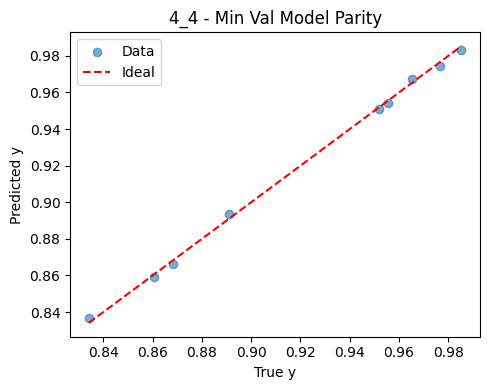

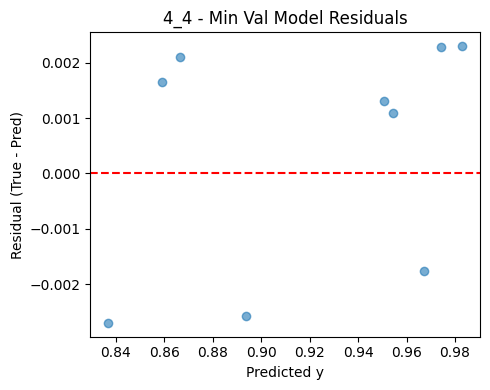

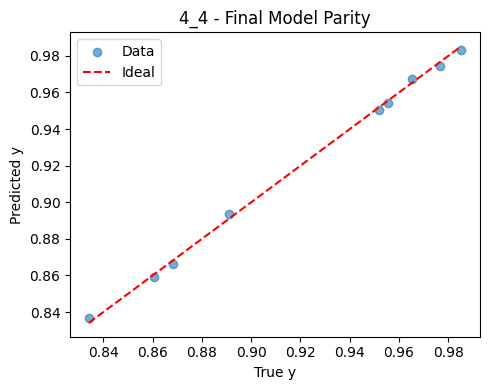

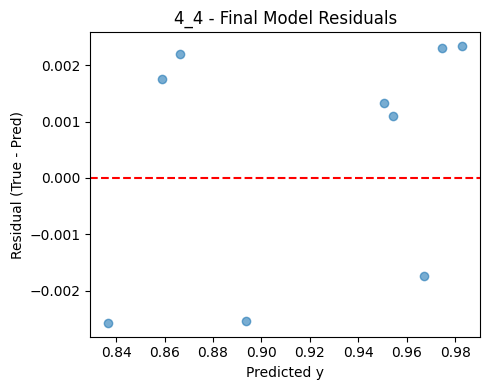

Evaluating config: '4_5'


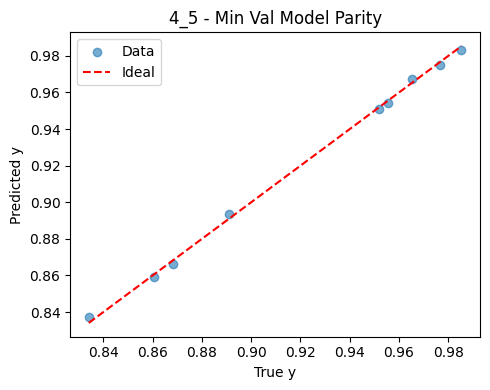

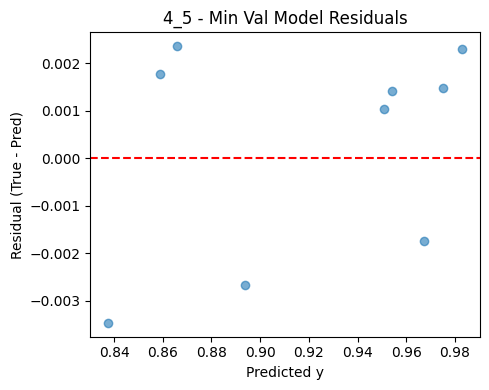

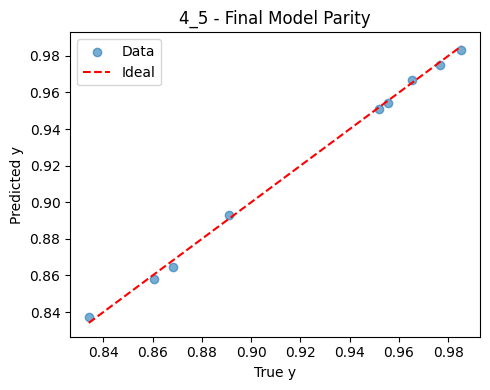

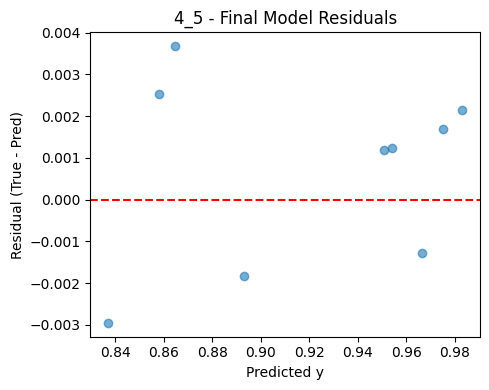

Evaluating config: '5_4'


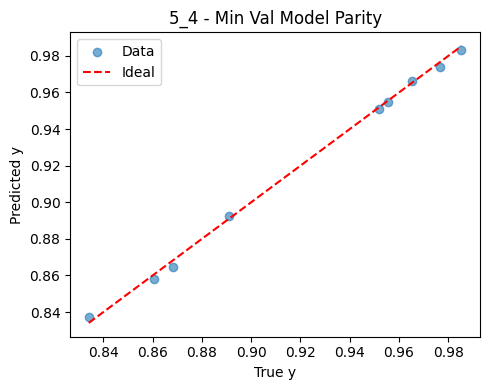

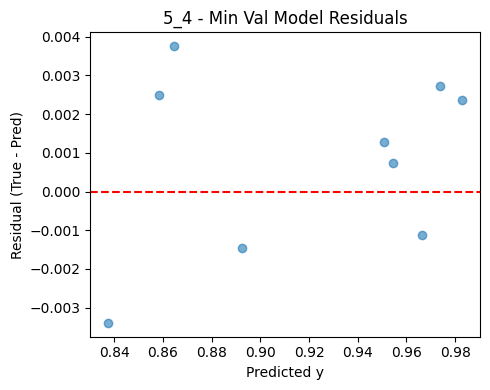

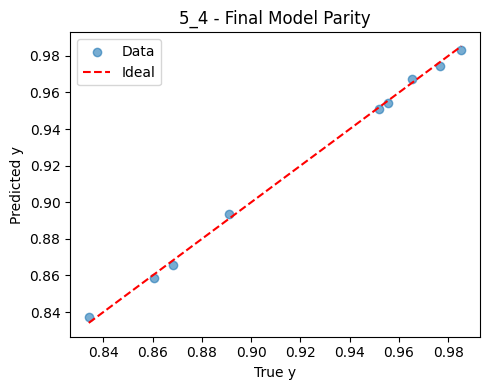

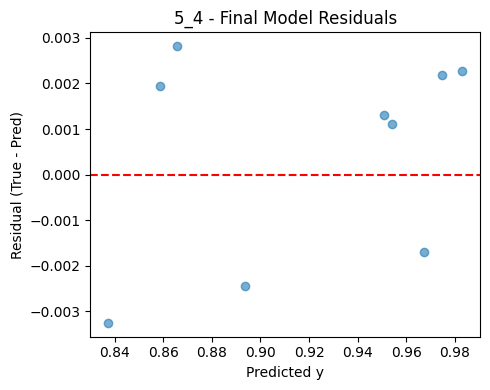

Evaluating config: '5_5'


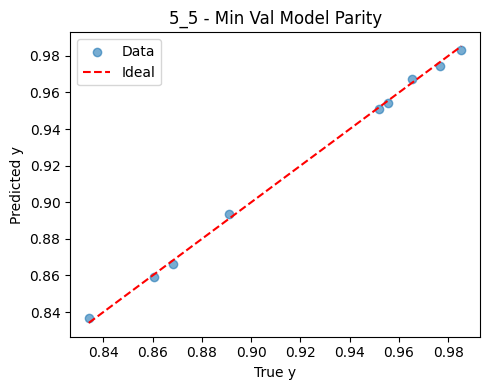

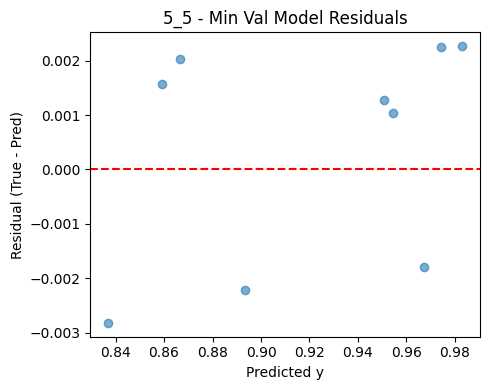

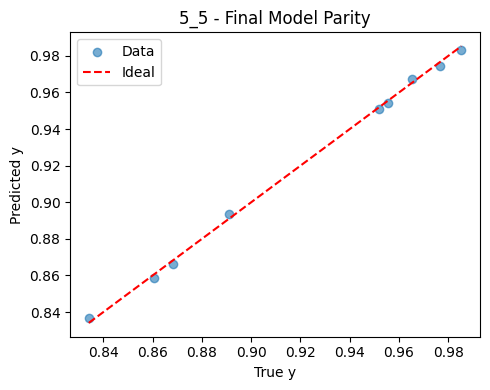

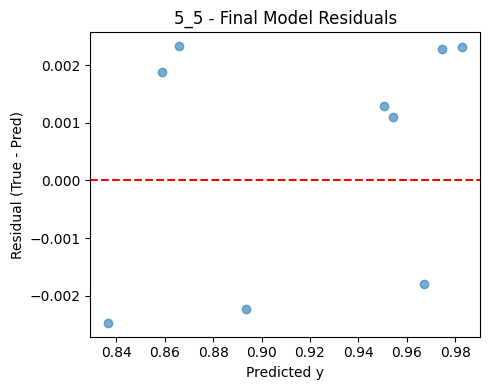

,config_name,train_loss_final,val_loss_final,min_val_loss,MSE_min_val_model,RMSE_min_val_model,MAE_min_val_model,R2_min_val_model,MAPE_min_val_model,MSE_final_model,RMSE_final_model,MAE_final_model,R2_final_model,MAPE_final_model
0,4_4,0.000874,0.001554,0.001486,0.000004,0.002048,0.001978,0.998559,0.216858,0.000004,0.002050,0.001988,0.998556,0.217775
1,4_5,0.000906,0.002428,0.002155,0.000005,0.002144,0.002025,0.998421,0.223674,0.000005,0.002210,0.002058,0.998321,0.228185
2,5_4,0.001327,0.003447,0.002978,0.000006,0.002366,0.002145,0.998077,0.237462,0.000005,0.002213,0.002115,0.998317,0.233226
3,5_5,0.000870,0.001601,0.001471,0.000004,0.001986,0.001916,0.998644,0.210024,0.000004,0.002022,0.001968,0.998596,0.215598


In [ ]:
density_train_ffnn2relu_results = evaluate_ffnn_results(density_train_ffnn2relu,
                                                        FFNN,
                                                        X_test_scaled_density_tsr,
                                                        y_test_scaled_density_tsr,
                                                        scaler_y=y_scaler_density)

density_train_ffnn2relu_results

# Train ANN on uniform cut area features

In [24]:

def get_final_cut_data(property_data, sigma_values, sigma_cuts = None, uniform_gap = 0.008, other_feats_inds = (0, )):
    property_other_feat_data = property_data[:, other_feats_inds]
    # exclude other_feats_inds
    property_p_data = np.delete(property_data, other_feats_inds, axis = 1)
    if sigma_cuts is None:
        sigma_cuts = get_uniform_cuts(uniform_gap)
    cut_areas = get_cut_areas(property_p_data, sigma_values, sigma_cuts)
    return merge_cuts_and_other_feats(cut_areas, property_other_feat_data)


processed_density_data = process_property_data(density_data, cleaned_pure_sigma_df)
X_processed_density_data = processed_density_data[:,:-1]
y_density_data = processed_density_data[:,(-1, )]
X_density_008cut_data = get_final_cut_data(X_processed_density_data, sigma_values, sigma_cuts = None, uniform_gap = 0.008, other_feats_inds = (0, ))

<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]


In [ ]:
X_train_density_008cut_data, \
X_val_density_008cut_data, \
X_test_density_008cut_data, \
y_train_density_008cut_data, \
y_val_density_008cut_data, \
y_test_density_008cut_data, \
rand_ind_density_008cut_data = get_train_val_test(X_density_008cut_data,
                                               y_density_data,
                                               test_size = 0.15,
                                               val_size = 0.15,
                                               random_split = True)
X_train_scaled_density_008cut_data, \
X_val_scaled_density_008cut_data, \
X_test_scaled_density_008cut_data, \
y_train_scaled_density_008cut_data, \
y_val_scaled_density_008cut_data, \
y_test_scaled_density_008cut_data, \
x_scaler_density_008cut_data, \
y_scaler_density_008cut_data = scale_data(X_train_density_008cut_data,
                                       X_val_density_008cut_data,
                                       X_test_density_008cut_data,
                                       y_train_density_008cut_data,
                                       y_val_density_008cut_data,
                                       y_test_density_008cut_data,
                                       method = 'standard')

X_train_scaled_density_008cut_data_tsr = torch.tensor(X_train_scaled_density_008cut_data, dtype=torch.float32)
X_val_scaled_density_008cut_data_tsr = torch.tensor(X_val_scaled_density_008cut_data, dtype=torch.float32)
X_test_scaled_density_008cut_data_tsr = torch.tensor(X_test_scaled_density_008cut_data, dtype=torch.float32)
y_train_scaled_density_008cut_data_tsr = torch.tensor(y_train_scaled_density_008cut_data, dtype=torch.float32)
y_val_scaled_density_008cut_data_tsr = torch.tensor(y_val_scaled_density_008cut_data, dtype=torch.float32)
y_test_scaled_density_008cut_data_tsr = torch.tensor(y_test_scaled_density_008cut_data, dtype=torch.float32)



In [ ]:
y_train_scaled_density_008cut_data.shape

(42, 1)

In [ ]:
# density_008cut_train_ffnn2relu = train_ffnn(
#     train_data=(X_train_scaled_density_008cut_data_tsr, y_train_scaled_density_008cut_data_tsr),
#     val_data=(X_val_scaled_density_008cut_data_tsr, y_val_scaled_density_008cut_data_tsr),
#     layers_nodes_range=[[10, 12], [10, 12]],     # e.g. [[l1_low, l1_high], [l2_low, l2_high], [l3_low, l3_high], ...]
#     activation_fn_layers=[nn.ReLU, nn.ReLU, None],   # e.g. [nn.ReLU, nn.ReLU, nn.Sigmoid, None]
#     input_dimension=X_train_scaled_density_008cut_data_tsr.size()[1],
#     output_dimension=1,
#     optimizer_fn=optim.Adam,
#     learning_rate=0.001,
#     weight_decay=1e-2,
#     loss_fn=nn.MSELoss,
#     max_epochs=15000
# )


# Save the object to a .npy file
# np.save(folder_path+'density_008cut_train_ffnn2relu.npy', density_008cut_train_ffnn2relu, allow_pickle=True)
density_008cut_train_ffnn2relu = np.load(folder_path+'density_008cut_train_ffnn2relu.npy', allow_pickle=True).item()

<ipython-input-26-f9ad15d1a8ee>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_eval_tsr = torch.tensor(X_eval, dtype=torch.float32)
<ipython-input-26-f9ad15d1a8ee>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_eval_tsr = torch.tensor(y_eval, dtype=torch.float32)


Evaluating config: '10_10'


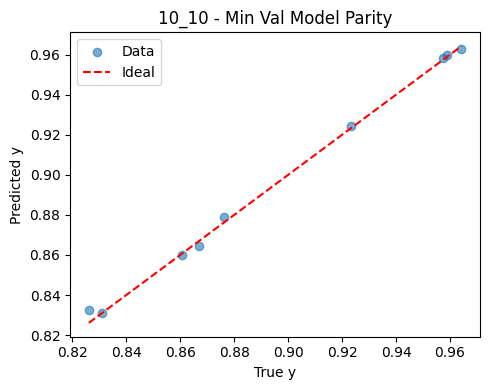

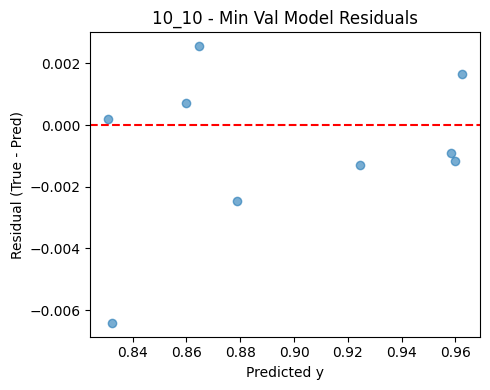

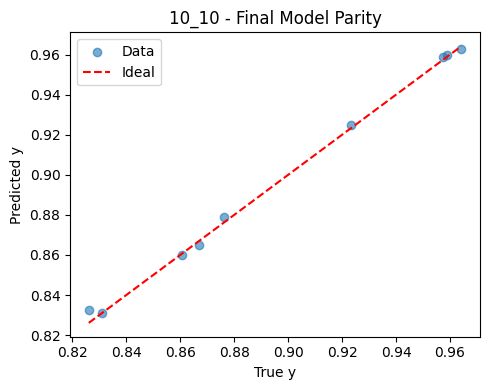

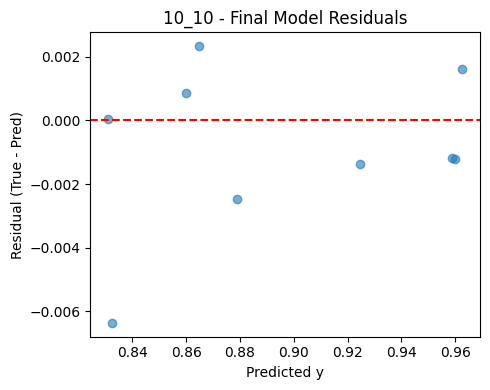

Evaluating config: '10_11'


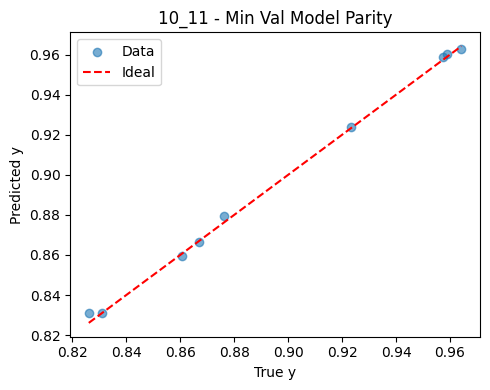

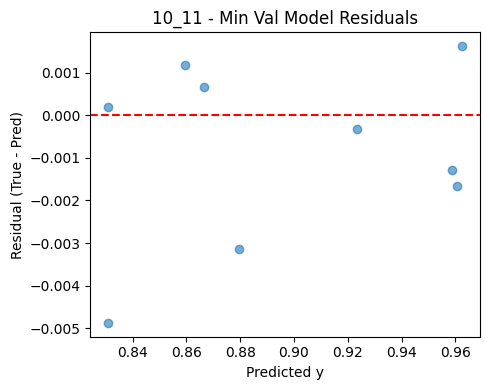

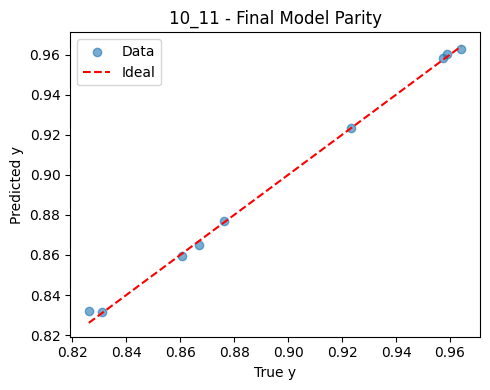

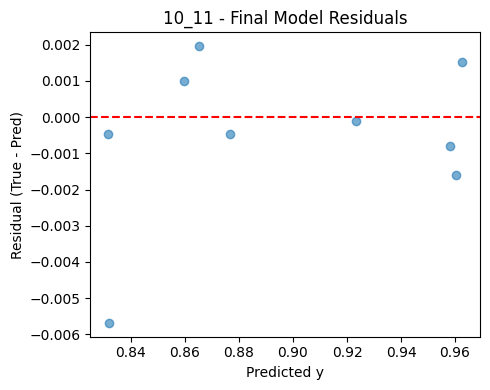

Evaluating config: '11_10'


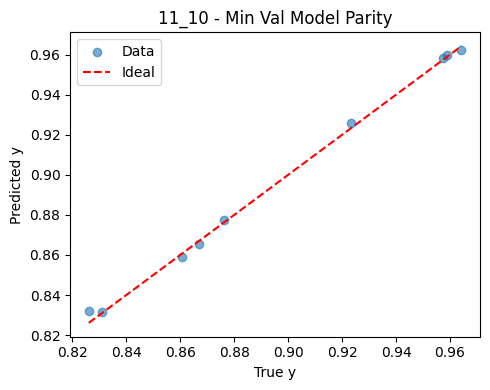

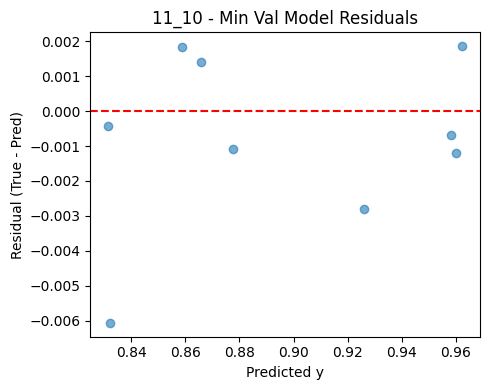

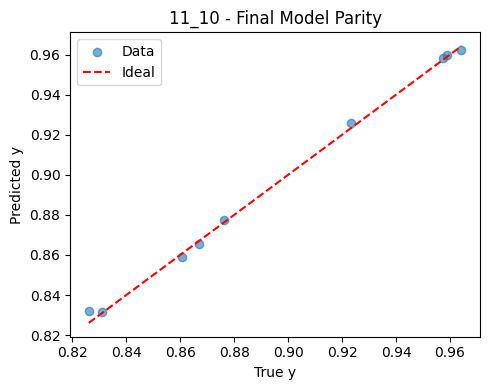

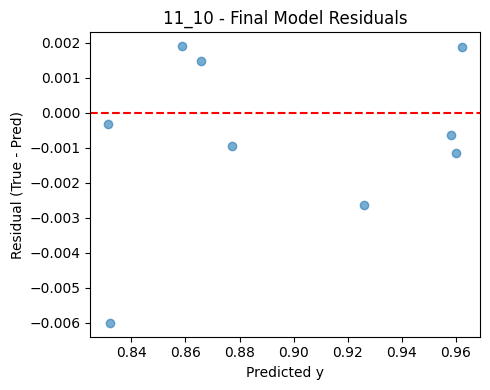

Evaluating config: '11_11'


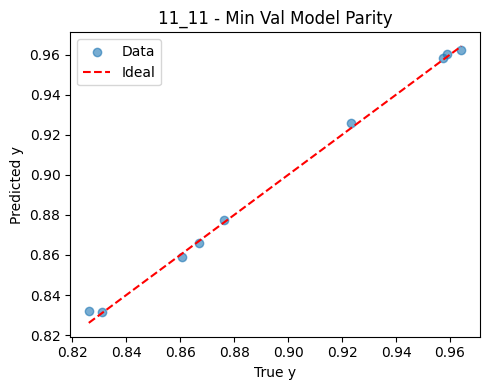

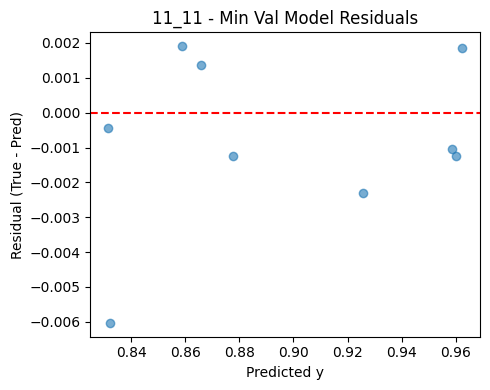

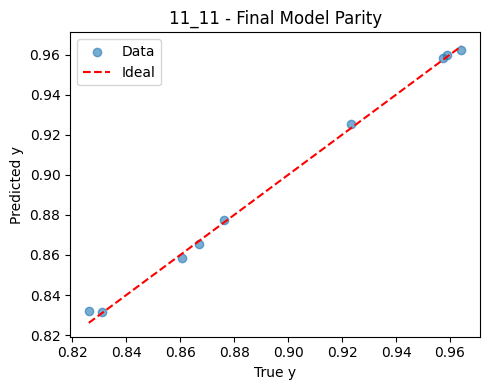

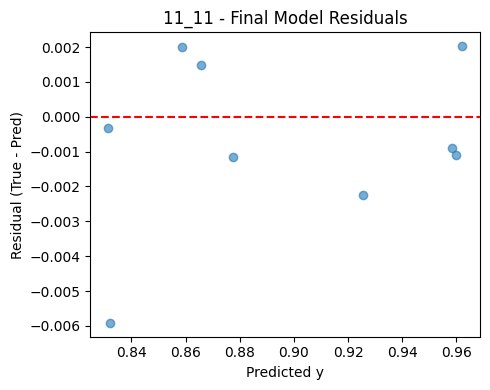

,config_name,train_loss_final,val_loss_final,min_val_loss,MSE_min_val_model,RMSE_min_val_model,MAE_min_val_model,R2_min_val_model,MAPE_min_val_model,MSE_final_model,RMSE_final_model,MAE_final_model,R2_final_model,MAPE_final_model
0,10_10,0.000935,0.001562,0.001460,0.000007,0.002602,0.001930,0.997531,0.220774,0.000007,0.002588,0.001943,0.997558,0.221879
1,10_11,0.000711,0.000879,0.000692,0.000005,0.002176,0.001660,0.998274,0.188407,0.000005,0.002189,0.001510,0.998254,0.173112
2,11_10,0.000860,0.000935,0.000877,0.000006,0.002511,0.001928,0.997702,0.219671,0.000006,0.002476,0.001889,0.997765,0.215188
3,11_11,0.000814,0.000895,0.000837,0.000006,0.002475,0.001940,0.997767,0.220897,0.000006,0.002445,0.001905,0.997820,0.216863


In [ ]:
density_008cut_train_ffnn2relu_results = evaluate_ffnn_results(density_008cut_train_ffnn2relu,
                                                               FFNN,
                                                               X_test_scaled_density_008cut_data_tsr,
                                                               y_test_scaled_density_008cut_data_tsr,
                                                               scaler_y=y_scaler_density_008cut_data)
density_008cut_train_ffnn2relu_results

# Finding optimum cut positions

In [25]:
def cut_process_and_scale_data(
    property_data,
    cleaned_sigma_df,
    sigma_values,
    sigma_cuts=None,
    uniform_gap=None,
    other_feats_inds=(0, ),
    test_size=0.15,
    val_size=0.15,
    random_split=True,
    scaling_method='standard'
):
    """
    Process, split, and scale property data with flexibility for inputs.

    Args:
        property_data: The raw property data to process.
        cleaned_sigma_df: Dataframe with sigma information.
        sigma_values: Sigma values for cutting.
        sigma_cuts: Specific sigma cuts (default None).
        uniform_gap: Uniform gap for cuts (default None).
        other_feats_inds: Indices of other features to include (default (0, )).
        test_size: Proportion of data to use as test set (default 0.15).
        val_size: Proportion of data to use as validation set (default 0.15).
        random_split: Whether to randomly split the data (default True).
        scaling_method: Method to use for scaling, e.g., 'standard' (default 'standard').

    Returns:
        Dictionary with processed, split, and scaled data as tensors.
    """
    # Step 1: Process the property data
    processed_property_data = process_property_data(property_data, cleaned_sigma_df)
    X_processed_property_data = processed_property_data[:, :-1]
    y_property_data = processed_property_data[:, (-1, )]

    # Step 2: Cut data based on sigma values
    X_property_cut_data = get_final_cut_data(
        X_processed_property_data,
        sigma_values,
        sigma_cuts=sigma_cuts,
        uniform_gap=uniform_gap,
        other_feats_inds=other_feats_inds
    )

    # Step 3: Split into training, validation, and test sets
    X_train_property_cut_data, \
    X_val_property_cut_data, \
    X_test_property_cut_data, \
    y_train_property_cut_data, \
    y_val_property_cut_data, \
    y_test_property_cut_data, \
    rand_ind_property_cut_data = get_train_val_test(
        X_property_cut_data,
        y_property_data,
        test_size=test_size,
        val_size=val_size,
        random_split=random_split
    )

    # Step 4: Scale the data
    X_train_scaled_property_cut_data, \
    X_val_scaled_property_cut_data, \
    X_test_scaled_property_cut_data, \
    y_train_scaled_property_cut_data, \
    y_val_scaled_property_cut_data, \
    y_test_scaled_property_cut_data, \
    x_scaler_property_cut_data, \
    y_scaler_property_cut_data = scale_data(
        X_train_property_cut_data,
        X_val_property_cut_data,
        X_test_property_cut_data,
        y_train_property_cut_data,
        y_val_property_cut_data,
        y_test_property_cut_data,
        method=scaling_method
    )

    # Step 5: Convert to tensors
    X_train_scaled_property_cut_data_tsr = torch.tensor(X_train_scaled_property_cut_data, dtype=torch.float32)
    X_val_scaled_property_cut_data_tsr = torch.tensor(X_val_scaled_property_cut_data, dtype=torch.float32)
    X_test_scaled_property_cut_data_tsr = torch.tensor(X_test_scaled_property_cut_data, dtype=torch.float32)
    y_train_scaled_property_cut_data_tsr = torch.tensor(y_train_scaled_property_cut_data, dtype=torch.float32)
    y_val_scaled_property_cut_data_tsr = torch.tensor(y_val_scaled_property_cut_data, dtype=torch.float32)
    y_test_scaled_property_cut_data_tsr = torch.tensor(y_test_scaled_property_cut_data, dtype=torch.float32)

    # Return results as a dictionary
    return {
        "X_train": X_train_scaled_property_cut_data_tsr,
        "X_val": X_val_scaled_property_cut_data_tsr,
        "X_test": X_test_scaled_property_cut_data_tsr,
        "y_train": y_train_scaled_property_cut_data_tsr,
        "y_val": y_val_scaled_property_cut_data_tsr,
        "y_test": y_test_scaled_property_cut_data_tsr,
        "x_scaler": x_scaler_property_cut_data,
        "y_scaler": y_scaler_property_cut_data,
        "random_indices": rand_ind_property_cut_data
    }


In [ ]:
_ = np.array(
    [
        [0,3],
        [3, 2],
        [5, 1]
    ]
)
def sort_cuts(cuts):
    new_cuts = []
    for cut in cuts:
        new_cuts.append(min(cut))
        new_cuts.append(max(cut))
    return np.array(new_cuts)

def count_correct_cuts(new_cuts, min_gap = 0.002):
    correct_cuts = 0


In [26]:
# Step 1: Define a function which takes number of optimum cuts and their positions as input
#         and gives the objective values as output

def cuts_objective(
    cuts,
    property_data = None,
    cleaned_sigma_df = None,
    sigma_values = None,
    uniform_gap=None,
    other_feats_inds=(0, ),
    test_size=0.15,
    val_size=0.15,
    random_split=True,
    scaling_method='standard',
    layers_nodes_range=[[10, 12], [10, 12]],     # e.g. [[l1_low, l1_high], [l2_low, l2_high], [l3_low, l3_high], ...]
    activation_fn_layers=[nn.ReLU, nn.ReLU, None],   # e.g. [nn.ReLU, nn.ReLU, nn.Sigmoid, None]
    optimizer_fn=optim.Adam,
    learning_rate=0.001,
    weight_decay=1e-2,
    loss_fn=nn.MSELoss,
    max_epochs=15000):
    sigma_cuts = cuts
    cut_data = cut_process_and_scale_data(property_data,
                                          cleaned_sigma_df,
                                          sigma_values,
                                          sigma_cuts=sigma_cuts,
                                          uniform_gap=uniform_gap,
                                          other_feats_inds=other_feats_inds,
                                          test_size=test_size,
                                          val_size=val_size,
                                          random_split=random_split,
                                          scaling_method=scaling_method)



    trained_ffn = train_ffnn(train_data=(cut_data["X_train"], cut_data["y_train"]),
                             val_data=(cut_data["X_val"], cut_data["y_val"]),
                             layers_nodes_range=layers_nodes_range,     # e.g. [[l1_low, l1_high], [l2_low, l2_high], [l3_low, l3_high], ...]
                             activation_fn_layers=activation_fn_layers,   # e.g. [nn.ReLU, nn.ReLU, nn.Sigmoid, None]
                             input_dimension=cut_data["X_train"].size()[1],
                             output_dimension=cut_data["y_train"].size()[1],
                             optimizer_fn=optimizer_fn,
                             learning_rate=learning_rate,
                             weight_decay=weight_decay,
                             loss_fn=loss_fn,
                             max_epochs=max_epochs)
    min_val_loss = np.inf

    for config in list(trained_ffn.keys()):
        if trained_ffn[config]['min_val_loss'] < min_val_loss:
            min_val_loss = trained_ffn[config]['min_val_loss']


    return min_val_loss

In [27]:
sigma_values

array([-0.019, -0.018, -0.017, -0.016, -0.015, -0.014, -0.013, -0.012,
       -0.011, -0.01, -0.009, -0.008, -0.007, -0.006, -0.005, -0.004,
       -0.003, -0.002, -0.001, 0, 0.001, 0.002, 0.003, 0.004, 0.005,
       0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014,
       0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023,
       0.024, 0.025, 0.026, 0.027], dtype=object)

In [34]:



# Define the custom problem
class CustomProblem(Problem):
    def __init__(self,
                 cut_obj_fn,
                 property_data=None,
                 cleaned_sigma_df=None,
                 sigma_values=None,
                 uniform_gap=None,
                 other_feats_inds=(0, ),
                 test_size=0.15,
                 val_size=0.15,
                 random_split=True,
                 scaling_method='standard',
                 layers_nodes_range=[[10, 11], [10, 11]],     # e.g. [[l1_low, l1_high], [l2_low, l2_high], [l3_low, l3_high], ...]
                 activation_fn_layers=[nn.ReLU, nn.ReLU, None],   # e.g. [nn.ReLU, nn.ReLU, nn.Sigmoid, None]
                 optimizer_fn=optim.Adam,
                 learning_rate=0.001,
                 weight_decay=1e-2,
                 loss_fn=nn.MSELoss,
                 max_epochs=15000):
        super().__init__(
            n_var=10,          # Number of decision variables
            n_obj=1,          # Number of objectives
            n_constr=5,       # Number of constraints
            xl=np.array([-0.020, ]*10),  # Lower bounds for variables
            xu=np.array([0.028, ]*10)  # Upper bounds for variables
        )
        # Assign input arguments to instance variables
        self.obj_func = cut_obj_fn
        self.property_data = property_data
        self.cleaned_sigma_df = cleaned_sigma_df
        self.sigma_values = sigma_values
        self.uniform_gap = uniform_gap
        self.other_feats_inds = other_feats_inds
        self.test_size = test_size
        self.val_size = val_size
        self.random_split = random_split
        self.scaling_method = scaling_method
        self.layers_nodes_range = layers_nodes_range
        self.activation_fn_layers = activation_fn_layers
        self.optimizer_fn = optimizer_fn
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.loss_fn = loss_fn
        self.max_epochs = max_epochs

    def _evaluate(self, X, out):
        print(X)
        X = X.reshape(-1, 5, 2)
        # constraints
        g1 = 0.002 - (X[:, 0 ,1] - X[:, 0, 0])
        g2 = 0.002 - (X[:, 1, 1] - X[:, 1, 0])
        g3 = 0.002 - (X[:, 2, 1] - X[:, 2, 0])
        g4 = 0.002 - (X[:, 3, 1] - X[:, 3, 0])
        g5 = 0.002 - (X[:, 4, 1] - X[:, 4, 0])
        out["G"] = np.column_stack([g1, g2, g3, g4, g5])
        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        # print(g1)
        # print(out["G"])
        # print("****************************************************************************************")
        # Objectives
        f1 = []
        for xi in X:
            # print(xi)
            f1.append([self.obj_func(xi,
                            property_data = self.property_data,
                            cleaned_sigma_df = self.cleaned_sigma_df,
                            sigma_values = self.sigma_values,
                            uniform_gap=self.uniform_gap,
                            other_feats_inds=self.other_feats_inds,
                            test_size=self.test_size,
                            val_size=self.val_size,
                            random_split=self.random_split,
                            scaling_method=self.scaling_method,
                            layers_nodes_range=self.layers_nodes_range,     # e.g. [[l1_low, l1_high], [l2_low, l2_high], [l3_low, l3_high], ...]
                            activation_fn_layers=self.activation_fn_layers,   # e.g. [nn.ReLU, nn.ReLU, nn.Sigmoid, None]
                            optimizer_fn=self.optimizer_fn,
                            learning_rate=self.learning_rate,
                            weight_decay=self.weight_decay,
                            loss_fn=self.loss_fn,
                            max_epochs=self.max_epochs), ])

        # Store results
        out["F"] = np.array(f1)  # Objectives

# Instantiate the problem
problem = CustomProblem(cuts_objective,
                        property_data = density_data,
                        cleaned_sigma_df = cleaned_pure_sigma_df,
                        sigma_values = sigma_values,
                        uniform_gap=None,
                        max_epochs=15000)

# Use the NSGA-II algorithm
algorithm = NSGA2(pop_size=5)

# Perform the optimization
res = minimize(problem,
               algorithm,
               ('n_gen', 10),  # Number of generations
               seed=1,
               verbose=True)

# Visualize the Pareto front
Scatter(title="Pareto Front").add(res.F).show()

# Print the best solutions
print("Pareto-optimal solutions (Decision Variables):")
print(res.X.reshape(-1, 5, 2))
print("Pareto-optimal solutions (Objectives):")
print(res.F)


[[ 1.70562257e-05  1.45755757e-02 -1.99945100e-02 -5.48803651e-03
  -1.29557172e-02 -1.55677475e-02 -1.10595099e-02 -3.41308510e-03
  -9.55161237e-04  5.86320323e-03]
 [ 1.21336691e-04  1.28905360e-02 -1.01862920e-02  2.21496369e-02
  -1.86853955e-02  1.21824405e-02  3.06305136e-05  6.81711177e-03
  -1.32614269e-02 -1.04911285e-02]
 [ 1.84357393e-02  2.64765556e-02 -4.95563945e-03  1.32314856e-02
   2.20666793e-02  2.29411198e-02 -1.59178779e-02 -1.81253704e-02
  -1.18481399e-02  2.21508402e-02]
 [-1.52793520e-02  2.13166000e-04  2.59786974e-02  5.59193368e-03
   1.32101015e-02 -4.85524971e-03  1.29520445e-02  2.00620323e-02
  -1.91221627e-02  1.60069271e-02]
 [ 2.74653323e-02  1.59119514e-02 -6.53868838e-03  1.78854078e-02
  -1.50451517e-02  1.49888926e-03  2.36125841e-02 -5.90652088e-03
  -6.18678375e-03 -1.37586285e-02]]
Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.015187, Val Loss: 0.973028


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Epoch 1000, Train Loss: 0.006249, Val Loss: 0.004048
Epoch 2000, Train Loss: 0.001621, Val Loss: 0.000916
Epoch 3000, Train Loss: 0.001265, Val Loss: 0.000408
Epoch 4000, Train Loss: 0.001198, Val Loss: 0.000419
Epoch 5000, Train Loss: 0.001192, Val Loss: 0.000477


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.026511, Val Loss: 1.006222
Epoch 1000, Train Loss: 0.010443, Val Loss: 0.004969
Epoch 2000, Train Loss: 0.004377, Val Loss: 0.002522
Epoch 3000, Train Loss: 0.002783, Val Loss: 0.002027
Epoch 4000, Train Loss: 0.002228, Val Loss: 0.001494
Epoch 5000, Train Loss: 0.001965, Val Loss: 0.001458
Epoch 6000, Train Loss: 0.001931, Val Loss: 0.001426
Epoch 7000, Train Loss: 0.001925, Val Loss: 0.001689


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.009601, Val Loss: 0.985686
Epoch 1000, Train Loss: 0.000978, Val Loss: 0.002400
Epoch 2000, Train Loss: 0.000735, Val Loss: 0.001497
Epoch 3000, Train Loss: 0.000692, Val Loss: 0.001418
Epoch 4000, Train Loss: 0.000699, Val Loss: 0.002387


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.014876, Val Loss: 1.000658
Epoch 1000, Train Loss: 0.001061, Val Loss: 0.003686
Epoch 2000, Train Loss: 0.000772, Val Loss: 0.002614
Epoch 3000, Train Loss: 0.000614, Val Loss: 0.001382
Epoch 4000, Train Loss: 0.000642, Val Loss: 0.001196
Epoch 5000, Train Loss: 0.000654, Val Loss: 0.001247


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.000577, Val Loss: 0.977513
Epoch 1000, Train Loss: 0.002473, Val Loss: 0.004648
Epoch 2000, Train Loss: 0.002075, Val Loss: 0.004533
Epoch 3000, Train Loss: 0.002128, Val Loss: 0.004280
Epoch 4000, Train Loss: 0.002049, Val Loss: 0.003411
Epoch 5000, Train Loss: 0.002052, Val Loss: 0.003286
Epoch 6000, Train Loss: 0.002054, Val Loss: 0.003257
Epoch 7000, Train Loss: 0.002061, Val Loss: 0.003260
Epoch 8000, Train Loss: 0.002057, Val Loss: 0.003249
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        5 |      1 |  0.000000E+00 |  0.0214083056 |             - |             -
[[ 1.78509340e-05  1.45755757e-02 -1.99945100e-02 -1.82027974e-02
  -1.31308538e-02 -1.61852635e-02 -1.10595099e-02 -4.15332080e-03
  -1.29331061e-02  5.86320323e-03]
 [-1.53490701e-02  1.35495776e-03  2.59786974e-02 -5.90230217e-03
   1.32101015e-02 -1.55323998e-02  1.29520445e-02  1.89438035e-02


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Epoch 1000, Train Loss: 0.002578, Val Loss: 0.003234
Epoch 2000, Train Loss: 0.001976, Val Loss: 0.002308
Epoch 3000, Train Loss: 0.001884, Val Loss: 0.002251


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.014851, Val Loss: 1.001096
Epoch 1000, Train Loss: 0.000835, Val Loss: 0.001734
Epoch 2000, Train Loss: 0.000731, Val Loss: 0.001226
Epoch 3000, Train Loss: 0.000681, Val Loss: 0.001155
Epoch 4000, Train Loss: 0.000689, Val Loss: 0.001462


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.011654, Val Loss: 0.993808
Epoch 1000, Train Loss: 0.007721, Val Loss: 0.006447
Epoch 2000, Train Loss: 0.002120, Val Loss: 0.003078
Epoch 3000, Train Loss: 0.002285, Val Loss: 0.002754
Epoch 4000, Train Loss: 0.002346, Val Loss: 0.002262
Epoch 5000, Train Loss: 0.002391, Val Loss: 0.001840
Epoch 6000, Train Loss: 0.002428, Val Loss: 0.001620
Epoch 7000, Train Loss: 0.002440, Val Loss: 0.001517
Epoch 8000, Train Loss: 0.002483, Val Loss: 0.001521
Epoch 9000, Train Loss: 0.002491, Val Loss: 0.001523


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.001981, Val Loss: 0.985538
Epoch 1000, Train Loss: 0.015055, Val Loss: 0.009028
Epoch 2000, Train Loss: 0.003229, Val Loss: 0.004562
Epoch 3000, Train Loss: 0.002889, Val Loss: 0.004637
Epoch 4000, Train Loss: 0.002633, Val Loss: 0.004044
Epoch 5000, Train Loss: 0.002516, Val Loss: 0.003935
Epoch 6000, Train Loss: 0.002483, Val Loss: 0.003870
Epoch 7000, Train Loss: 0.002476, Val Loss: 0.003869
Epoch 8000, Train Loss: 0.002464, Val Loss: 0.003857


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.011495, Val Loss: 0.998726
Epoch 1000, Train Loss: 0.003020, Val Loss: 0.002630
Epoch 2000, Train Loss: 0.001671, Val Loss: 0.001127
Epoch 3000, Train Loss: 0.001687, Val Loss: 0.001175
Epoch 4000, Train Loss: 0.001692, Val Loss: 0.001276
     2 |       10 |      1 |  0.000000E+00 |  0.0030160113 |  0.000000E+00 |             f
[[ 8.71812996e-05  1.34337839e-02 -1.99945100e-02 -7.38299512e-03
  -1.31308538e-02 -5.28061702e-03 -1.10595099e-02 -4.15332080e-03
  -1.29366447e-02  1.66533900e-02]
 [ 1.67371437e-05  1.35245548e-02 -1.99945100e-02 -5.91779102e-03
  -1.29557172e-02 -1.61238261e-02 -1.10595099e-02 -4.53111953e-03
  -1.08173171e-03  5.17554104e-03]
 [-2.35175959e-03  1.28905360e-02 -1.01862920e-02  2.21496369e-02
  -1.85100592e-02  1.25724709e-02  3.06305136e-05  6.76553452e-03
  -1.41257262e-03 -1.04911285e-02]
 [ 8.72380888e-05  1.44848048e-02 -1.99945100e-02  6.43595385e-03
  -1.29557172e-02 -4.92776414e-03 -

<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Epoch 1000, Train Loss: 0.018047, Val Loss: 0.014833
Epoch 2000, Train Loss: 0.002972, Val Loss: 0.002080
Epoch 3000, Train Loss: 0.002773, Val Loss: 0.001984
Epoch 4000, Train Loss: 0.002729, Val Loss: 0.001970
Epoch 5000, Train Loss: 0.002696, Val Loss: 0.001952
Epoch 6000, Train Loss: 0.002684, Val Loss: 0.001952
Epoch 7000, Train Loss: 0.002689, Val Loss: 0.001965
Epoch 8000, Train Loss: 0.002686, Val Loss: 0.001952
Epoch 9000, Train Loss: 0.002676, Val Loss: 0.001957
Epoch 10000, Train Loss: 0.002680, Val Loss: 0.001955


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.011401, Val Loss: 1.000359
Epoch 1000, Train Loss: 0.004990, Val Loss: 0.003251
Epoch 2000, Train Loss: 0.001509, Val Loss: 0.000627
Epoch 3000, Train Loss: 0.001324, Val Loss: 0.000472
Epoch 4000, Train Loss: 0.001251, Val Loss: 0.000489


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.011654, Val Loss: 0.993808
Epoch 1000, Train Loss: 0.007721, Val Loss: 0.006447
Epoch 2000, Train Loss: 0.002120, Val Loss: 0.003078
Epoch 3000, Train Loss: 0.002285, Val Loss: 0.002754
Epoch 4000, Train Loss: 0.002346, Val Loss: 0.002262
Epoch 5000, Train Loss: 0.002391, Val Loss: 0.001840
Epoch 6000, Train Loss: 0.002428, Val Loss: 0.001620
Epoch 7000, Train Loss: 0.002440, Val Loss: 0.001517
Epoch 8000, Train Loss: 0.002483, Val Loss: 0.001521
Epoch 9000, Train Loss: 0.002491, Val Loss: 0.001523


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.001915, Val Loss: 0.985629
Epoch 1000, Train Loss: 0.006404, Val Loss: 0.005589
Epoch 2000, Train Loss: 0.001968, Val Loss: 0.003705
Epoch 3000, Train Loss: 0.001726, Val Loss: 0.003573


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.003229, Val Loss: 0.987026
Epoch 1000, Train Loss: 0.003702, Val Loss: 0.002493
Epoch 2000, Train Loss: 0.001618, Val Loss: 0.003110
Epoch 3000, Train Loss: 0.001265, Val Loss: 0.002554
     3 |       15 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
[[ 8.74415935e-05  1.34337839e-02 -1.99945100e-02 -1.91691807e-02
  -1.33006370e-02 -5.67955751e-03 -1.10595099e-02 -4.88974695e-03
  -1.32527621e-02  1.66533900e-02]
 [ 8.71810403e-05  1.35173386e-02 -1.99945100e-02 -7.89966755e-03
  -1.29557172e-02 -5.27945307e-03 -1.10595099e-02 -4.53111953e-03
  -1.28441239e-02  1.66095651e-02]
 [-2.35175759e-03  1.28905360e-02 -1.01862920e-02  2.21496369e-02
  -1.85154470e-02  1.25813810e-02  3.06305136e-05  6.76180250e-03
  -1.29453096e-02 -1.04911285e-02]
 [ 8.72383482e-05  1.44012501e-02 -1.99945100e-02  6.95262636e-03
  -1.31308538e-02 -4.92892808e-03 -1.10595099e-02 -4.15332080e-03
  -3.56327414e-04  1.7

<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Epoch 1000, Train Loss: 0.014561, Val Loss: 0.020933
Epoch 2000, Train Loss: 0.002372, Val Loss: 0.003152
Epoch 3000, Train Loss: 0.001601, Val Loss: 0.001498
Epoch 4000, Train Loss: 0.001468, Val Loss: 0.001610


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.008320, Val Loss: 0.989013
Epoch 1000, Train Loss: 0.016057, Val Loss: 0.010108
Epoch 2000, Train Loss: 0.003077, Val Loss: 0.001958
Epoch 3000, Train Loss: 0.002514, Val Loss: 0.001735
Epoch 4000, Train Loss: 0.002230, Val Loss: 0.001424
Epoch 5000, Train Loss: 0.002191, Val Loss: 0.001422


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025689, Val Loss: 1.003991
Epoch 1000, Train Loss: 0.014005, Val Loss: 0.007381
Epoch 2000, Train Loss: 0.003698, Val Loss: 0.001771
Epoch 3000, Train Loss: 0.003597, Val Loss: 0.001551
Epoch 4000, Train Loss: 0.003482, Val Loss: 0.001369
Epoch 5000, Train Loss: 0.003036, Val Loss: 0.001184
Epoch 6000, Train Loss: 0.002945, Val Loss: 0.001129
Epoch 7000, Train Loss: 0.002914, Val Loss: 0.001108
Epoch 8000, Train Loss: 0.002909, Val Loss: 0.001203
Epoch 9000, Train Loss: 0.002878, Val Loss: 0.001210


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.001558, Val Loss: 0.984908
Epoch 1000, Train Loss: 0.002273, Val Loss: 0.002320
Epoch 2000, Train Loss: 0.001564, Val Loss: 0.003337
Epoch 3000, Train Loss: 0.001630, Val Loss: 0.004144


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.008748, Val Loss: 0.989826
Epoch 1000, Train Loss: 0.005870, Val Loss: 0.003960
Epoch 2000, Train Loss: 0.002210, Val Loss: 0.001557
Epoch 3000, Train Loss: 0.002062, Val Loss: 0.001582
     4 |       20 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002819325 |             f
[[-2.33291045e-03  1.28905360e-02 -1.01862920e-02  8.76032187e-03
  -1.85206417e-02  1.21733268e-02  3.06305136e-05  5.97014502e-03
  -1.32529932e-02 -1.04911285e-02]
 [ 8.70253028e-05  1.29337235e-02 -1.99945100e-02 -8.48704639e-03
  -1.31308538e-02 -5.91721279e-03 -1.10595099e-02 -5.27123264e-03
  -1.32539643e-02 -1.22198240e-02]
 [-2.37034374e-03  1.28905360e-02 -1.01862920e-02  2.21496369e-02
  -1.86802008e-02  1.25904948e-02  3.06305136e-05  6.81683291e-03
  -1.29537433e-02 -1.04911285e-02]
 [ 1.21492688e-04  1.33905965e-02 -1.01862920e-02  2.32412070e-02
  -1.86853955e-02  1.21225382e-02  3.06305136e-05  6.81711177e-03
  -1.22466942e-02  1.8

<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Epoch 1000, Train Loss: 0.012901, Val Loss: 0.011363
Epoch 2000, Train Loss: 0.004358, Val Loss: 0.003278
Epoch 3000, Train Loss: 0.003069, Val Loss: 0.002563
Epoch 4000, Train Loss: 0.003001, Val Loss: 0.002530
Epoch 5000, Train Loss: 0.002978, Val Loss: 0.002493
Epoch 6000, Train Loss: 0.002969, Val Loss: 0.002500
Epoch 7000, Train Loss: 0.002951, Val Loss: 0.002453
Epoch 8000, Train Loss: 0.002960, Val Loss: 0.002494
Epoch 9000, Train Loss: 0.002951, Val Loss: 0.002488
Epoch 10000, Train Loss: 0.002947, Val Loss: 0.002435


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 0.996725, Val Loss: 0.965697
Epoch 1000, Train Loss: 0.020088, Val Loss: 0.008520
Epoch 2000, Train Loss: 0.005060, Val Loss: 0.003185
Epoch 3000, Train Loss: 0.004065, Val Loss: 0.002561
Epoch 4000, Train Loss: 0.003282, Val Loss: 0.001995
Epoch 5000, Train Loss: 0.002805, Val Loss: 0.001436
Epoch 6000, Train Loss: 0.002746, Val Loss: 0.001335
Epoch 7000, Train Loss: 0.002740, Val Loss: 0.001315
Epoch 8000, Train Loss: 0.002752, Val Loss: 0.001347
Epoch 9000, Train Loss: 0.002759, Val Loss: 0.001348
Epoch 10000, Train Loss: 0.002752, Val Loss: 0.001334
Epoch 11000, Train Loss: 0.002752, Val Loss: 0.001354


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025689, Val Loss: 1.003991
Epoch 1000, Train Loss: 0.014005, Val Loss: 0.007381
Epoch 2000, Train Loss: 0.003698, Val Loss: 0.001771
Epoch 3000, Train Loss: 0.003597, Val Loss: 0.001551
Epoch 4000, Train Loss: 0.003482, Val Loss: 0.001369
Epoch 5000, Train Loss: 0.003036, Val Loss: 0.001184
Epoch 6000, Train Loss: 0.002945, Val Loss: 0.001129
Epoch 7000, Train Loss: 0.002914, Val Loss: 0.001108
Epoch 8000, Train Loss: 0.002909, Val Loss: 0.001203
Epoch 9000, Train Loss: 0.002878, Val Loss: 0.001210


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.019864, Val Loss: 1.008387
Epoch 1000, Train Loss: 0.004345, Val Loss: 0.005173
Epoch 2000, Train Loss: 0.002884, Val Loss: 0.004199
Epoch 3000, Train Loss: 0.002625, Val Loss: 0.002843
Epoch 4000, Train Loss: 0.002336, Val Loss: 0.002404
Epoch 5000, Train Loss: 0.002205, Val Loss: 0.002572


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025925, Val Loss: 1.004064
Epoch 1000, Train Loss: 0.015031, Val Loss: 0.007068
Epoch 2000, Train Loss: 0.004260, Val Loss: 0.002891
Epoch 3000, Train Loss: 0.003901, Val Loss: 0.002754
Epoch 4000, Train Loss: 0.003436, Val Loss: 0.002508
Epoch 5000, Train Loss: 0.003152, Val Loss: 0.002370
Epoch 6000, Train Loss: 0.003082, Val Loss: 0.002307
Epoch 7000, Train Loss: 0.002413, Val Loss: 0.001299
Epoch 8000, Train Loss: 0.002430, Val Loss: 0.001469
     5 |       25 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0002819325 |             f
[[-1.11854879e-02  1.28905360e-02 -1.01862920e-02  2.21496369e-02
  -1.84637574e-02  1.25903622e-02  3.06305136e-05  6.81690345e-03
  -1.29452836e-02 -1.08976725e-02]
 [ 4.62179662e-05  1.28905360e-02 -1.01862920e-02  2.21496369e-02
  -1.86853955e-02  1.03240709e-02  3.06305136e-05  6.81711891e-03
  -1.29320355e-02 -1.04911285e-02]
 [-2.35175759e-03  1.28905360e-02 -1.01862920e-02  2.214

<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Epoch 1000, Train Loss: 0.010674, Val Loss: 0.025312
Epoch 2000, Train Loss: 0.008627, Val Loss: 0.022469
Epoch 3000, Train Loss: 0.007560, Val Loss: 0.019573
Epoch 4000, Train Loss: 0.007030, Val Loss: 0.018275
Epoch 5000, Train Loss: 0.006807, Val Loss: 0.017718
Epoch 6000, Train Loss: 0.006753, Val Loss: 0.017517
Epoch 7000, Train Loss: 0.006748, Val Loss: 0.017557
Epoch 8000, Train Loss: 0.006770, Val Loss: 0.017414
Epoch 9000, Train Loss: 0.006753, Val Loss: 0.017486
Epoch 10000, Train Loss: 0.006632, Val Loss: 0.019903
Epoch 11000, Train Loss: 0.006620, Val Loss: 0.019986


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.026347, Val Loss: 1.004318
Epoch 1000, Train Loss: 0.015356, Val Loss: 0.007609
Epoch 2000, Train Loss: 0.003268, Val Loss: 0.002252
Epoch 3000, Train Loss: 0.002932, Val Loss: 0.001511
Epoch 4000, Train Loss: 0.002893, Val Loss: 0.001362
Epoch 5000, Train Loss: 0.002549, Val Loss: 0.001214
Epoch 6000, Train Loss: 0.002490, Val Loss: 0.001203
Epoch 7000, Train Loss: 0.002485, Val Loss: 0.001199
Epoch 8000, Train Loss: 0.002483, Val Loss: 0.001222
Epoch 9000, Train Loss: 0.002415, Val Loss: 0.001535
Epoch 10000, Train Loss: 0.002364, Val Loss: 0.001592


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025689, Val Loss: 1.003991
Epoch 1000, Train Loss: 0.014005, Val Loss: 0.007381
Epoch 2000, Train Loss: 0.003698, Val Loss: 0.001771
Epoch 3000, Train Loss: 0.003597, Val Loss: 0.001551
Epoch 4000, Train Loss: 0.003482, Val Loss: 0.001369
Epoch 5000, Train Loss: 0.003036, Val Loss: 0.001184
Epoch 6000, Train Loss: 0.002945, Val Loss: 0.001129
Epoch 7000, Train Loss: 0.002914, Val Loss: 0.001108
Epoch 8000, Train Loss: 0.002909, Val Loss: 0.001203
Epoch 9000, Train Loss: 0.002878, Val Loss: 0.001210


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025594, Val Loss: 1.005458
Epoch 1000, Train Loss: 0.015908, Val Loss: 0.007366
Epoch 2000, Train Loss: 0.003996, Val Loss: 0.001720
Epoch 3000, Train Loss: 0.003895, Val Loss: 0.001576
Epoch 4000, Train Loss: 0.003580, Val Loss: 0.001466
Epoch 5000, Train Loss: 0.003377, Val Loss: 0.001394
Epoch 6000, Train Loss: 0.003332, Val Loss: 0.001395
Epoch 7000, Train Loss: 0.003295, Val Loss: 0.001375
Epoch 8000, Train Loss: 0.003164, Val Loss: 0.001129
Epoch 9000, Train Loss: 0.003137, Val Loss: 0.001145
Epoch 10000, Train Loss: 0.003076, Val Loss: 0.001045
Epoch 11000, Train Loss: 0.002790, Val Loss: 0.000757
Epoch 12000, Train Loss: 0.002780, Val Loss: 0.000699
Epoch 13000, Train Loss: 0.002768, Val Loss: 0.000684


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.026871, Val Loss: 1.006451
Epoch 1000, Train Loss: 0.008748, Val Loss: 0.004660
Epoch 2000, Train Loss: 0.002948, Val Loss: 0.001691
Epoch 3000, Train Loss: 0.001967, Val Loss: 0.001240
Epoch 4000, Train Loss: 0.001930, Val Loss: 0.001200
Epoch 5000, Train Loss: 0.001914, Val Loss: 0.001172
Epoch 6000, Train Loss: 0.001900, Val Loss: 0.001185
Epoch 7000, Train Loss: 0.001907, Val Loss: 0.001182
Epoch 8000, Train Loss: 0.001911, Val Loss: 0.001170
Epoch 9000, Train Loss: 0.001910, Val Loss: 0.001179
     6 |       30 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0007371680 |             f
[[-5.46152679e-03  1.28905360e-02 -1.10776695e-02  2.21496369e-02
  -1.86798227e-02  1.25815138e-02 -9.92678848e-04  6.76180272e-03
  -1.29455646e-02 -1.04911285e-02]
 [-5.68929863e-03  1.28905360e-02 -1.01862920e-02  2.21496369e-02
  -1.85154470e-02  1.08190578e-02  3.06305136e-05  6.81862898e-03
  -1.29446779e-02 -1.04911285e-02]
 [-

<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Epoch 1000, Train Loss: 0.013065, Val Loss: 0.009033
Epoch 2000, Train Loss: 0.011199, Val Loss: 0.007781
Epoch 3000, Train Loss: 0.010002, Val Loss: 0.006409
Epoch 4000, Train Loss: 0.009246, Val Loss: 0.005564
Epoch 5000, Train Loss: 0.008941, Val Loss: 0.005283
Epoch 6000, Train Loss: 0.005593, Val Loss: 0.003355
Epoch 7000, Train Loss: 0.005461, Val Loss: 0.003294
Epoch 8000, Train Loss: 0.005417, Val Loss: 0.003357
Epoch 9000, Train Loss: 0.005417, Val Loss: 0.003443
Epoch 10000, Train Loss: 0.005416, Val Loss: 0.003304
Epoch 11000, Train Loss: 0.005416, Val Loss: 0.003323


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.026308, Val Loss: 1.005969
Epoch 1000, Train Loss: 0.016500, Val Loss: 0.007425
Epoch 2000, Train Loss: 0.003913, Val Loss: 0.001650
Epoch 3000, Train Loss: 0.003699, Val Loss: 0.001565
Epoch 4000, Train Loss: 0.003383, Val Loss: 0.001575
Epoch 5000, Train Loss: 0.003181, Val Loss: 0.001647


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025594, Val Loss: 1.005458
Epoch 1000, Train Loss: 0.015908, Val Loss: 0.007366
Epoch 2000, Train Loss: 0.003996, Val Loss: 0.001720
Epoch 3000, Train Loss: 0.003895, Val Loss: 0.001576
Epoch 4000, Train Loss: 0.003580, Val Loss: 0.001466
Epoch 5000, Train Loss: 0.003377, Val Loss: 0.001394
Epoch 6000, Train Loss: 0.003332, Val Loss: 0.001395
Epoch 7000, Train Loss: 0.003295, Val Loss: 0.001375
Epoch 8000, Train Loss: 0.003164, Val Loss: 0.001129
Epoch 9000, Train Loss: 0.003137, Val Loss: 0.001145
Epoch 10000, Train Loss: 0.003076, Val Loss: 0.001045
Epoch 11000, Train Loss: 0.002790, Val Loss: 0.000757
Epoch 12000, Train Loss: 0.002780, Val Loss: 0.000699
Epoch 13000, Train Loss: 0.002768, Val Loss: 0.000684


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.013610, Val Loss: 0.997574
Epoch 1000, Train Loss: 0.014097, Val Loss: 0.009904
Epoch 2000, Train Loss: 0.003654, Val Loss: 0.005285
Epoch 3000, Train Loss: 0.002484, Val Loss: 0.002047
Epoch 4000, Train Loss: 0.002372, Val Loss: 0.001487
Epoch 5000, Train Loss: 0.002408, Val Loss: 0.001389
Epoch 6000, Train Loss: 0.002404, Val Loss: 0.001349
Epoch 7000, Train Loss: 0.002405, Val Loss: 0.001334
Epoch 8000, Train Loss: 0.002384, Val Loss: 0.001305
Epoch 9000, Train Loss: 0.002393, Val Loss: 0.001351
Epoch 10000, Train Loss: 0.002408, Val Loss: 0.001355
Epoch 11000, Train Loss: 0.002399, Val Loss: 0.001339
Epoch 12000, Train Loss: 0.002399, Val Loss: 0.001328


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.019504, Val Loss: 0.998941
Epoch 1000, Train Loss: 0.019527, Val Loss: 0.008935
Epoch 2000, Train Loss: 0.007592, Val Loss: 0.003856
Epoch 3000, Train Loss: 0.006500, Val Loss: 0.003751
Epoch 4000, Train Loss: 0.006399, Val Loss: 0.003775
Epoch 5000, Train Loss: 0.006508, Val Loss: 0.003829
     7 |       35 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0007371680 |             f
[[-3.43564897e-03  1.25389553e-02 -1.32199089e-02  2.21496369e-02
  -1.86822498e-02  1.25815137e-02  3.06305136e-05  6.76173197e-03
  -1.29537692e-02 -1.04911285e-02]
 [-5.56476394e-03  1.28905360e-02 -7.66483509e-03  2.21496369e-02
  -1.86802008e-02  1.25815021e-02  2.17585982e-04  6.76156257e-03
  -1.29537684e-02 -1.04911285e-02]
 [-5.52552360e-03  1.50215143e-02 -1.10667198e-02  2.21496369e-02
  -1.86822498e-02  1.25815137e-02  3.06305136e-05  1.02217261e-02
  -1.29537692e-02 -1.04911285e-02]
 [-5.52552360e-03  1.28833007e-02 -1.10667198e-0

<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Epoch 1000, Train Loss: 0.012277, Val Loss: 0.025874
Epoch 2000, Train Loss: 0.006000, Val Loss: 0.015294
Epoch 3000, Train Loss: 0.005449, Val Loss: 0.013697
Epoch 4000, Train Loss: 0.005515, Val Loss: 0.013815
Epoch 5000, Train Loss: 0.005737, Val Loss: 0.014210
Epoch 6000, Train Loss: 0.004619, Val Loss: 0.011089
Epoch 7000, Train Loss: 0.004567, Val Loss: 0.011244


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.026008, Val Loss: 1.005699
Epoch 1000, Train Loss: 0.016499, Val Loss: 0.006736
Epoch 2000, Train Loss: 0.004106, Val Loss: 0.001687
Epoch 3000, Train Loss: 0.003896, Val Loss: 0.001596
Epoch 4000, Train Loss: 0.003602, Val Loss: 0.001433
Epoch 5000, Train Loss: 0.003403, Val Loss: 0.001383
Epoch 6000, Train Loss: 0.003354, Val Loss: 0.001343
Epoch 7000, Train Loss: 0.003189, Val Loss: 0.001135
Epoch 8000, Train Loss: 0.003149, Val Loss: 0.001165


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025910, Val Loss: 1.006115
Epoch 1000, Train Loss: 0.018891, Val Loss: 0.008950
Epoch 2000, Train Loss: 0.004977, Val Loss: 0.002205
Epoch 3000, Train Loss: 0.004629, Val Loss: 0.002156
Epoch 4000, Train Loss: 0.004134, Val Loss: 0.001864
Epoch 5000, Train Loss: 0.003781, Val Loss: 0.001872
Epoch 6000, Train Loss: 0.003749, Val Loss: 0.001998


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025594, Val Loss: 1.005458
Epoch 1000, Train Loss: 0.015908, Val Loss: 0.007366
Epoch 2000, Train Loss: 0.003996, Val Loss: 0.001720
Epoch 3000, Train Loss: 0.003895, Val Loss: 0.001576
Epoch 4000, Train Loss: 0.003580, Val Loss: 0.001466
Epoch 5000, Train Loss: 0.003377, Val Loss: 0.001394
Epoch 6000, Train Loss: 0.003332, Val Loss: 0.001395
Epoch 7000, Train Loss: 0.003295, Val Loss: 0.001375
Epoch 8000, Train Loss: 0.003164, Val Loss: 0.001129
Epoch 9000, Train Loss: 0.003137, Val Loss: 0.001145
Epoch 10000, Train Loss: 0.003076, Val Loss: 0.001045
Epoch 11000, Train Loss: 0.002790, Val Loss: 0.000757
Epoch 12000, Train Loss: 0.002780, Val Loss: 0.000699
Epoch 13000, Train Loss: 0.002768, Val Loss: 0.000684


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025787, Val Loss: 1.004080
Epoch 1000, Train Loss: 0.014319, Val Loss: 0.007507
Epoch 2000, Train Loss: 0.003741, Val Loss: 0.001780
Epoch 3000, Train Loss: 0.003622, Val Loss: 0.001533
Epoch 4000, Train Loss: 0.003502, Val Loss: 0.001377
Epoch 5000, Train Loss: 0.003053, Val Loss: 0.001189
Epoch 6000, Train Loss: 0.002969, Val Loss: 0.001184
Epoch 7000, Train Loss: 0.002941, Val Loss: 0.001171
Epoch 8000, Train Loss: 0.002917, Val Loss: 0.001150
Epoch 9000, Train Loss: 0.002916, Val Loss: 0.001177
Epoch 10000, Train Loss: 0.002603, Val Loss: 0.001565
Epoch 11000, Train Loss: 0.002575, Val Loss: 0.001698
     8 |       40 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0007371680 |             f
[[-5.52552360e-03  1.28949985e-02 -1.10667198e-02  2.40714536e-02
  -1.86822498e-02  1.32854225e-02  3.06305136e-05  6.76173197e-03
  -1.29537692e-02 -1.04911285e-02]
 [-2.33110340e-03  1.25368358e-02 -1.12118746e-02  2.21496369e

<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Epoch 1000, Train Loss: 0.011509, Val Loss: 0.021097
Epoch 2000, Train Loss: 0.007621, Val Loss: 0.014975
Epoch 3000, Train Loss: 0.007163, Val Loss: 0.013162
Epoch 4000, Train Loss: 0.005385, Val Loss: 0.008727
Epoch 5000, Train Loss: 0.004972, Val Loss: 0.008216
Epoch 6000, Train Loss: 0.004936, Val Loss: 0.008160
Epoch 7000, Train Loss: 0.004917, Val Loss: 0.008098
Epoch 8000, Train Loss: 0.004893, Val Loss: 0.008043
Epoch 9000, Train Loss: 0.004893, Val Loss: 0.008024


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.013997, Val Loss: 0.995050
Epoch 1000, Train Loss: 0.004328, Val Loss: 0.006294
Epoch 2000, Train Loss: 0.003153, Val Loss: 0.005126
Epoch 3000, Train Loss: 0.002360, Val Loss: 0.004330
Epoch 4000, Train Loss: 0.002300, Val Loss: 0.004262


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025624, Val Loss: 1.005481
Epoch 1000, Train Loss: 0.015902, Val Loss: 0.007351
Epoch 2000, Train Loss: 0.003994, Val Loss: 0.001709
Epoch 3000, Train Loss: 0.003888, Val Loss: 0.001555
Epoch 4000, Train Loss: 0.003578, Val Loss: 0.001467
Epoch 5000, Train Loss: 0.003385, Val Loss: 0.001477
Epoch 6000, Train Loss: 0.003331, Val Loss: 0.001400
Epoch 7000, Train Loss: 0.003302, Val Loss: 0.001408
Epoch 8000, Train Loss: 0.003165, Val Loss: 0.001185
Epoch 9000, Train Loss: 0.003138, Val Loss: 0.001145
Epoch 10000, Train Loss: 0.003131, Val Loss: 0.001135
Epoch 11000, Train Loss: 0.003136, Val Loss: 0.001184
Epoch 12000, Train Loss: 0.002797, Val Loss: 0.001578


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025746, Val Loss: 1.004063
Epoch 1000, Train Loss: 0.014292, Val Loss: 0.007537
Epoch 2000, Train Loss: 0.003738, Val Loss: 0.001777
Epoch 3000, Train Loss: 0.003622, Val Loss: 0.001526
Epoch 4000, Train Loss: 0.003508, Val Loss: 0.001360
Epoch 5000, Train Loss: 0.003055, Val Loss: 0.001183
Epoch 6000, Train Loss: 0.002965, Val Loss: 0.001166
Epoch 7000, Train Loss: 0.002941, Val Loss: 0.001130


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025740, Val Loss: 1.005438
Epoch 1000, Train Loss: 0.013809, Val Loss: 0.006225
Epoch 2000, Train Loss: 0.003508, Val Loss: 0.001647
Epoch 3000, Train Loss: 0.003361, Val Loss: 0.001687
Epoch 4000, Train Loss: 0.002926, Val Loss: 0.001448
Epoch 5000, Train Loss: 0.002719, Val Loss: 0.001247
Epoch 6000, Train Loss: 0.002667, Val Loss: 0.001226
Epoch 7000, Train Loss: 0.002642, Val Loss: 0.001215
Epoch 8000, Train Loss: 0.002630, Val Loss: 0.001219
Epoch 9000, Train Loss: 0.002626, Val Loss: 0.001219
Epoch 10000, Train Loss: 0.002621, Val Loss: 0.001204
Epoch 11000, Train Loss: 0.002238, Val Loss: 0.001478
Epoch 12000, Train Loss: 0.002206, Val Loss: 0.001516
     9 |       45 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0007371680 |             f
[[-5.52552360e-03  1.28949985e-02 -1.10667198e-02  2.40714536e-02
  -1.86822498e-02  1.32854225e-02  3.06305136e-05  6.76173197e-03
  -1.29537692e-02 -1.04911285e-02]
 [-2.331

<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Epoch 1000, Train Loss: 0.011509, Val Loss: 0.021097
Epoch 2000, Train Loss: 0.007621, Val Loss: 0.014975
Epoch 3000, Train Loss: 0.007163, Val Loss: 0.013162
Epoch 4000, Train Loss: 0.005385, Val Loss: 0.008727
Epoch 5000, Train Loss: 0.004972, Val Loss: 0.008216
Epoch 6000, Train Loss: 0.004936, Val Loss: 0.008160
Epoch 7000, Train Loss: 0.004917, Val Loss: 0.008098
Epoch 8000, Train Loss: 0.004893, Val Loss: 0.008043
Epoch 9000, Train Loss: 0.004893, Val Loss: 0.008024


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.013997, Val Loss: 0.995050
Epoch 1000, Train Loss: 0.004328, Val Loss: 0.006294
Epoch 2000, Train Loss: 0.003153, Val Loss: 0.005126
Epoch 3000, Train Loss: 0.002360, Val Loss: 0.004330
Epoch 4000, Train Loss: 0.002300, Val Loss: 0.004262


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025746, Val Loss: 1.004063
Epoch 1000, Train Loss: 0.014292, Val Loss: 0.007537
Epoch 2000, Train Loss: 0.003738, Val Loss: 0.001777
Epoch 3000, Train Loss: 0.003622, Val Loss: 0.001526
Epoch 4000, Train Loss: 0.003508, Val Loss: 0.001360
Epoch 5000, Train Loss: 0.003055, Val Loss: 0.001183
Epoch 6000, Train Loss: 0.002965, Val Loss: 0.001166
Epoch 7000, Train Loss: 0.002941, Val Loss: 0.001130


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025740, Val Loss: 1.005438
Epoch 1000, Train Loss: 0.013809, Val Loss: 0.006225
Epoch 2000, Train Loss: 0.003508, Val Loss: 0.001647
Epoch 3000, Train Loss: 0.003361, Val Loss: 0.001687
Epoch 4000, Train Loss: 0.002926, Val Loss: 0.001448
Epoch 5000, Train Loss: 0.002719, Val Loss: 0.001247
Epoch 6000, Train Loss: 0.002667, Val Loss: 0.001226
Epoch 7000, Train Loss: 0.002642, Val Loss: 0.001215
Epoch 8000, Train Loss: 0.002630, Val Loss: 0.001219
Epoch 9000, Train Loss: 0.002626, Val Loss: 0.001219
Epoch 10000, Train Loss: 0.002621, Val Loss: 0.001204
Epoch 11000, Train Loss: 0.002238, Val Loss: 0.001478
Epoch 12000, Train Loss: 0.002206, Val Loss: 0.001516


<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.027705, Val Loss: 1.010421
Epoch 1000, Train Loss: 0.007219, Val Loss: 0.004148
Epoch 2000, Train Loss: 0.003230, Val Loss: 0.002763
Epoch 3000, Train Loss: 0.002460, Val Loss: 0.001816
Epoch 4000, Train Loss: 0.002282, Val Loss: 0.001522
Epoch 5000, Train Loss: 0.002218, Val Loss: 0.001515
Epoch 6000, Train Loss: 0.002205, Val Loss: 0.001463
Epoch 7000, Train Loss: 0.002178, Val Loss: 0.001361
Epoch 8000, Train Loss: 0.002184, Val Loss: 0.001362
Epoch 9000, Train Loss: 0.002185, Val Loss: 0.001346
Epoch 10000, Train Loss: 0.002195, Val Loss: 0.001307
Epoch 11000, Train Loss: 0.002190, Val Loss: 0.001585
Epoch 12000, Train Loss: 0.001980, Val Loss: 0.001051
Epoch 13000, Train Loss: 0.001981, Val Loss: 0.001099
    10 |       50 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0007371680 |             f
Pareto-optimal solutions (Decision Variables):
[[[-5.52552360e-03  1.28905360e-02]
  [-1.10667198e-02  2.21496369e-02]
  

In [ ]:
# include molecular weight also
optimal cuts:


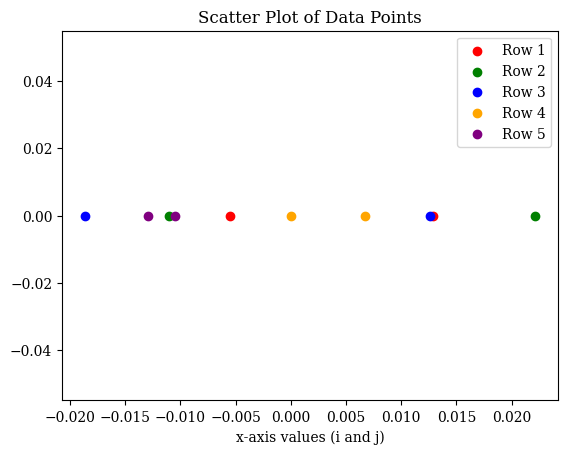

In [38]:

import matplotlib.pyplot as plt

_ = [[-5.52552360e-03,  1.28905360e-02],
 [-1.10667198e-02,  2.21496369e-02],
 [-1.86822498e-02,  1.25815137e-02],
 [ 3.06305136e-05,  6.76173197e-03],
 [-1.29537692e-02, -1.04911285e-02]]

data = np.array(_)

colors = ['red', 'green', 'blue', 'orange', 'purple']

for i in range(len(data)):
  plt.scatter(data[i, 0], [0], color=colors[i], label=f'Row {i+1}')
  plt.scatter(data[i, 1], [0], color=colors[i])

plt.xlabel('x-axis values (i and j)')
plt.title('Scatter Plot of Data Points')
plt.legend()
plt.show()

# Check optimum cuts

In [39]:

def get_final_cut_data(property_data, sigma_values, sigma_cuts = None, uniform_gap = 0.008, other_feats_inds = (0, )):
    property_other_feat_data = property_data[:, other_feats_inds]
    # exclude other_feats_inds
    property_p_data = np.delete(property_data, other_feats_inds, axis = 1)
    if sigma_cuts is None:
        sigma_cuts = get_uniform_cuts(uniform_gap)
    cut_areas = get_cut_areas(property_p_data, sigma_values, sigma_cuts)
    return merge_cuts_and_other_feats(cut_areas, property_other_feat_data)


sigma_cuts = [[-5.52552360e-03,  1.28905360e-02],
 [-1.10667198e-02,  2.21496369e-02],
 [-1.86822498e-02,  1.25815137e-02],
 [ 3.06305136e-05,  6.76173197e-03],
 [-1.29537692e-02, -1.04911285e-02]]

processed_density_data = process_property_data(density_data, cleaned_pure_sigma_df)
X_processed_density_data = processed_density_data[:,:-1]
y_density_data = processed_density_data[:,(-1, )]
X_density_008cut_data = get_final_cut_data(X_processed_density_data, sigma_values, sigma_cuts = sigma_cuts, uniform_gap = None, other_feats_inds = (0, ))

<ipython-input-17-ea5243a830c0>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]


In [40]:
X_train_density_008cut_data, \
X_val_density_008cut_data, \
X_test_density_008cut_data, \
y_train_density_008cut_data, \
y_val_density_008cut_data, \
y_test_density_008cut_data, \
rand_ind_density_008cut_data = get_train_val_test(X_density_008cut_data,
                                               y_density_data,
                                               test_size = 0.15,
                                               val_size = 0.15,
                                               random_split = True)
X_train_scaled_density_008cut_data, \
X_val_scaled_density_008cut_data, \
X_test_scaled_density_008cut_data, \
y_train_scaled_density_008cut_data, \
y_val_scaled_density_008cut_data, \
y_test_scaled_density_008cut_data, \
x_scaler_density_008cut_data, \
y_scaler_density_008cut_data = scale_data(X_train_density_008cut_data,
                                       X_val_density_008cut_data,
                                       X_test_density_008cut_data,
                                       y_train_density_008cut_data,
                                       y_val_density_008cut_data,
                                       y_test_density_008cut_data,
                                       method = 'standard')

X_train_scaled_density_008cut_data_tsr = torch.tensor(X_train_scaled_density_008cut_data, dtype=torch.float32)
X_val_scaled_density_008cut_data_tsr = torch.tensor(X_val_scaled_density_008cut_data, dtype=torch.float32)
X_test_scaled_density_008cut_data_tsr = torch.tensor(X_test_scaled_density_008cut_data, dtype=torch.float32)
y_train_scaled_density_008cut_data_tsr = torch.tensor(y_train_scaled_density_008cut_data, dtype=torch.float32)
y_val_scaled_density_008cut_data_tsr = torch.tensor(y_val_scaled_density_008cut_data, dtype=torch.float32)
y_test_scaled_density_008cut_data_tsr = torch.tensor(y_test_scaled_density_008cut_data, dtype=torch.float32)



In [41]:
density_008cut_train_ffnn2relu = train_ffnn(
    train_data=(X_train_scaled_density_008cut_data_tsr, y_train_scaled_density_008cut_data_tsr),
    val_data=(X_val_scaled_density_008cut_data_tsr, y_val_scaled_density_008cut_data_tsr),
    layers_nodes_range=[[10, 12], [10, 12]],     # e.g. [[l1_low, l1_high], [l2_low, l2_high], [l3_low, l3_high], ...]
    activation_fn_layers=[nn.ReLU, nn.ReLU, None],   # e.g. [nn.ReLU, nn.ReLU, nn.Sigmoid, None]
    input_dimension=X_train_scaled_density_008cut_data_tsr.size()[1],
    output_dimension=1,
    optimizer_fn=optim.Adam,
    learning_rate=0.001,
    weight_decay=1e-2,
    loss_fn=nn.MSELoss,
    max_epochs=15000
)

<ipython-input-29-29740f75afdd>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tsr = torch.tensor(X_val_scaled, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:61: UserWarning: To copy construct from a tensor, it is recommended to use sou

Training model with hidden layers = (10, 10)
Epoch 0, Train Loss: 1.025594, Val Loss: 1.005458
Epoch 1000, Train Loss: 0.015908, Val Loss: 0.007366
Epoch 2000, Train Loss: 0.003996, Val Loss: 0.001720
Epoch 3000, Train Loss: 0.003895, Val Loss: 0.001576
Epoch 4000, Train Loss: 0.003580, Val Loss: 0.001466
Epoch 5000, Train Loss: 0.003377, Val Loss: 0.001394
Epoch 6000, Train Loss: 0.003332, Val Loss: 0.001395
Epoch 7000, Train Loss: 0.003295, Val Loss: 0.001375
Epoch 8000, Train Loss: 0.003164, Val Loss: 0.001129
Epoch 9000, Train Loss: 0.003137, Val Loss: 0.001145
Epoch 10000, Train Loss: 0.003076, Val Loss: 0.001045
Epoch 11000, Train Loss: 0.002790, Val Loss: 0.000757
Epoch 12000, Train Loss: 0.002780, Val Loss: 0.000699
Epoch 13000, Train Loss: 0.002768, Val Loss: 0.000684
Training model with hidden layers = (10, 11)
Epoch 0, Train Loss: 1.034529, Val Loss: 1.088493
Epoch 1000, Train Loss: 0.006553, Val Loss: 0.002299
Epoch 2000, Train Loss: 0.003116, Val Loss: 0.001596
Epoch 3000,

<ipython-input-29-29740f75afdd>:213: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_eval_tsr = torch.tensor(X_eval, dtype=torch.float32)
<ipython-input-29-29740f75afdd>:214: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_eval_tsr = torch.tensor(y_eval, dtype=torch.float32)


Evaluating config: '10_10'


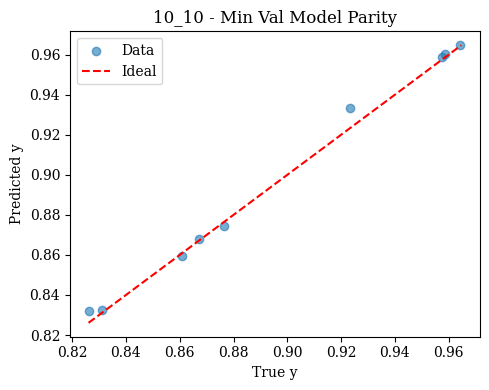

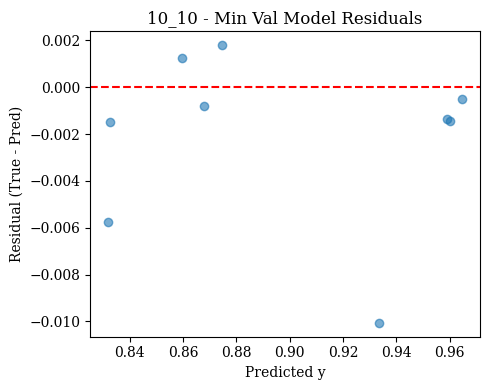

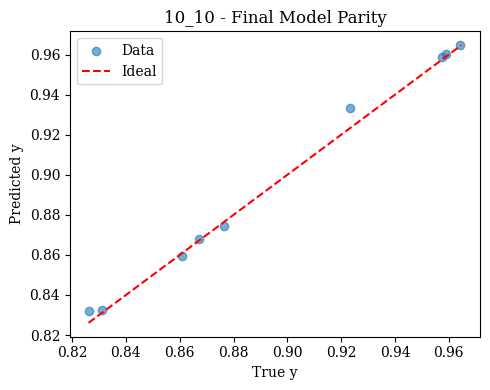

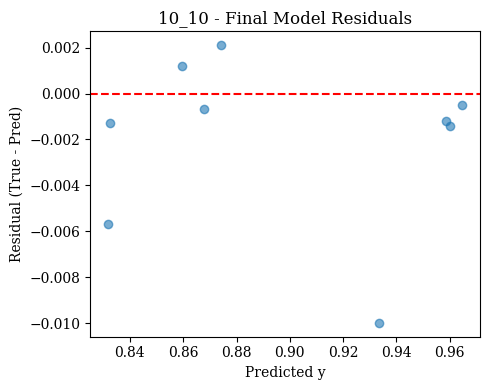

Evaluating config: '10_11'


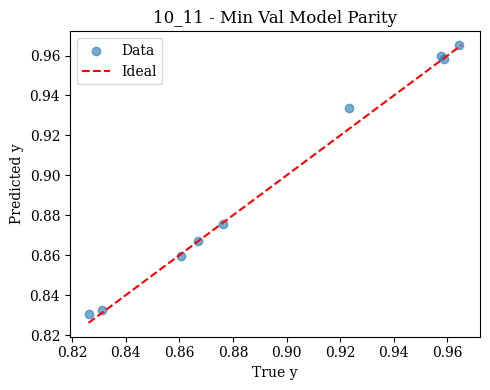

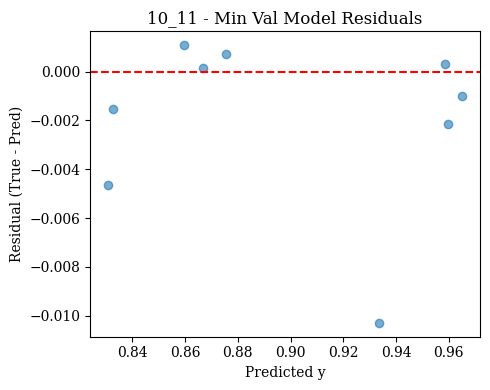

In [ ]:
density_008cut_train_ffnn2relu_results = evaluate_ffnn_results(density_008cut_train_ffnn2relu,
                                                               FFNN,
                                                               X_test_scaled_density_008cut_data_tsr,
                                                               y_test_scaled_density_008cut_data_tsr,
                                                               scaler_y=y_scaler_density_008cut_data)
density_008cut_train_ffnn2relu_results

In [43]:
density_008cut_train_ffnn2relu_results

,config_name,train_loss_final,val_loss_final,min_val_loss,MSE_min_val_model,RMSE_min_val_model,MAE_min_val_model,R2_min_val_model,MAPE_min_val_model,MSE_final_model,RMSE_final_model,MAE_final_model,R2_final_model,MAPE_final_model
0,10_10,0.002777,0.000747,0.000637,0.000016,0.004032,0.002717,0.994074,0.305810,0.000016,0.003995,0.002670,0.994180,0.300440
1,10_11,0.002672,0.001865,0.001173,0.000015,0.003902,0.002422,0.994448,0.270931,0.000014,0.003800,0.002618,0.994734,0.292985
2,11_10,0.003168,0.001906,0.001724,0.000021,0.004537,0.003363,0.992495,0.378159,0.000020,0.004469,0.003346,0.992718,0.376245
3,11_11,0.002668,0.001790,0.001668,0.000015,0.003817,0.002610,0.994690,0.294741,0.000014,0.003774,0.002617,0.994808,0.295363


# Apply CNN to full data

In [ ]:

# CNN1D Architecture Design
class CNN1D(nn.Module):
    def __init__(self, layer_details):
        """
        Args:
            layer_details (dict): Specifies details for each layer.
                Example:
                {
                    "conv1": {
                        "in_channels": 1,
                        "out_channels": 16,
                        "kernel_size": 3,
                        "stride": 1,
                        "padding": 1,
                        "activation_fn": nn.ReLU
                    },
                    "pool1": {
                        "kernel_size": 2,
                        "stride": 2,
                        "ceil_mode": True,
                        "type": "avg"  # Use "max" for max pooling
                    },
                    "fc": {
                        "input_dimension": <int>,
                        "output_dimension": <int>,
                        "activation_fn": nn.Sigmoid
                    }
                }
        """
        super(CNN1D, self).__init__()
        self.convlayers = nn.ModuleList()
        self.denselayers = nn.ModuleList()


        # Add convolution and pooling layers
        for layer_name, details in layer_details.items():
            if "conv" in layer_name:
                self.convlayers.append(
                    nn.Conv1d(
                        in_channels=details["in_channels"],
                        out_channels=details["out_channels"],
                        kernel_size=details["kernel_size"],
                        stride=details["stride"],
                        padding=details["padding"],
                    )
                )
                if details["activation_fn"] is not None:
                    self.convlayers.append(details["activation_fn"]())
            elif "pool" in layer_name:
                if details["type"] == "avg":
                    self.convlayers.append(nn.AvgPool1d(kernel_size=details["kernel_size"],
                                                        stride=details["stride"],
                                                        ceil_mode = details['ceil_mode']))
                elif details["type"] == "max":
                    self.convlayers.append(nn.MaxPool1d(kernel_size=details["kernel_size"],
                                                        stride=details["stride"],
                                                        ceil_mode = details['ceil_mode']))
            elif "fc" in layer_name:  # Fully connected layer
                self.denselayers.append(nn.Linear(details["input_dimension"],
                                                  details["output_dimension"]))
                if details["activation_fn"] is not None:
                    self.denselayers.append(details["activation_fn"]())


    def forward(self, x, additional_input=None):
        # print(x.size())
        # Forward pass through convolutional layers
        for layer in self.convlayers:
            x = layer(x)
            # print(x.size())

        # Flatten the output
        x = torch.flatten(x, start_dim=1)
        # print(x.size())
        # Concatenate additional input if provided
        if additional_input is not None:
            x = torch.cat((x, additional_input), dim=1)
            # print(x.size())
        # Pass through fully connected layer
        for layer in self.denselayers:
            x = layer(x)
            # print(x.size())
        return x


# Training Function
def train_cnn1d(
    train_data=None,
    val_data=None,
    conv_layer_details=None,  # Dictionary defining CNN architecture
    additional_input_dim=None,  # Dimensionality of additional input (if any)
    input_channels=1,
    output_dimension=None,
    optimizer_fn=optim.Adam,
    learning_rate=0.001,
    weight_decay=1e-2,
    loss_fn=nn.MSELoss,
    max_epochs=25000,
):
    """
    Trains a 1D CNN with given parameters.

    Args:
        train_data (tuple): (X_train_scaled, y_train_scaled).
        val_data (tuple): (X_val_scaled, y_val_scaled).
        conv_layer_details (dict): Specifies convolutional layer details.
        additional_input_dim (int): Dimensionality of additional input.
        input_channels (int): Number of channels in input data.
        output_dimension (int): Output dimensionality.
        optimizer_fn (callable): Optimizer class.
        learning_rate (float): Learning rate.
        weight_decay (float): Weight decay (L2 regularization).
        loss_fn (callable): Loss function.
        max_epochs (int): Maximum number of epochs.

    Returns:
        dict: Training results including model state, losses, etc.
    """

    # Basic checks
    if conv_layer_details is None or len(conv_layer_details) == 0:
        raise ValueError("conv_layer_details must specify the CNN architecture.")

    # Unpack training and validation data
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    additional_train_input = X_train_scaled[:,additional_input_dim]
    additional_val_input = X_val_scaled[:,additional_input_dim]


    # Convert to tensors
    X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
    X_val_tsr = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    y_val_tsr = torch.tensor(y_val_scaled, dtype=torch.float32)
    # delete additional_input_dim from X_train_tsr
    remaining_indices = [i for i in range(X_train_tsr.shape[2]) if i not in additional_input_dim]
    X_train_tsr = X_train_tsr[:,:,remaining_indices]
    X_val_tsr = X_val_tsr[:,:,remaining_indices]

    # Initialize model
    cnn_model = CNN1D(conv_layer_details)

    # Initialize optimizer
    optimizer = optimizer_fn(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Loss function
    criterion = loss_fn()

    train_losses = []
    val_losses = []
    min_val_loss = float('inf')
    min_val_model = None


    # Training loop
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        # Forward pass on training data
        train_pred = cnn_model(X_train_tsr, additional_input=additional_train_input)
        train_loss = criterion(train_pred, y_train_tsr)

        # Forward pass on validation data
        val_pred = cnn_model(X_val_tsr, additional_input=additional_val_input)
        val_loss = criterion(val_pred, y_val_tsr)

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Track the best validation model
        if val_loss.item() < min_val_loss:
            min_val_loss = val_loss.item()
            min_val_model = copy.deepcopy(cnn_model.state_dict())#cnn_model.state_dict()
            print(f"best val epoch is {epoch}")

        # Backpropagation
        train_loss.backward()
        optimizer.step()

        # Print progress every 1000 epochs (optional)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

    # Return training results
    return {
        "layer_details": conv_layer_details,
        "final_model": cnn_model.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "min_val_loss": min_val_loss,
        "min_val_model": min_val_model,
    }


In [ ]:
cnnlayer_details = {
    "conv1": {
        "in_channels": 1,
        "out_channels": 16,
        "kernel_size": 4,
        "stride": 1,
        "padding": 0,
        "activation_fn": nn.ReLU,
    },
    "pool1": {
        "kernel_size": 2,
        "stride": 2,
        "ceil_mode": True,
        "type": "avg",
    },
    "conv2": {
        "in_channels": 16,
        "out_channels": 1,
        "kernel_size": 4,
        "stride": 1,
        "padding": 1,
        "activation_fn": nn.ReLU,
    },
    "pool2": {
        "kernel_size": 3,
        "stride": 3,
        "ceil_mode": True,
        "type": "avg",
    },
    "fc1": {
        "input_dimension": 8,
        "output_dimension": 10,
        "activation_fn": nn.ReLU,
    },
    "fc2": {
        "input_dimension": 10,
        "output_dimension": 10,
        "activation_fn": nn.ReLU,
    },
    "fc3": {
        "input_dimension": 10,
        "output_dimension": 1,
        "activation_fn": None,
    },
}





density_train_cnn = train_cnn1d(
    train_data=(X_train_scaled_density_tsr,y_train_scaled_density_tsr),
    val_data=(X_val_scaled_density_tsr,y_val_scaled_density_tsr),
    conv_layer_details=cnnlayer_details,  # Dictionary defining CNN architecture
    additional_input_dim=(0, ),  # Dimensionality of additional input (if any)
    input_channels=1,
    output_dimension=1,
    optimizer_fn=optim.Adam,
    learning_rate=0.001,
    weight_decay=1e-2,
    loss_fn=nn.MSELoss,
    max_epochs=1000,
)

<ipython-input-22-969bee6d1d83>:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
<ipython-input-22-969bee6d1d83>:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
<ipython-input-22-969bee6d1d83>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tsr = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
<ipython-input-22-969bee6d1d83>

best val epoch is 0
Epoch 0, Train Loss: 1.072827, Val Loss: 1.178648
best val epoch is 53
best val epoch is 54
best val epoch is 55
best val epoch is 56
best val epoch is 57
best val epoch is 58
best val epoch is 59
best val epoch is 60
best val epoch is 61
best val epoch is 62
best val epoch is 63
best val epoch is 64
best val epoch is 65
best val epoch is 66
best val epoch is 67
best val epoch is 68
best val epoch is 69
best val epoch is 70
best val epoch is 71
best val epoch is 72
best val epoch is 73
best val epoch is 74
best val epoch is 75
best val epoch is 76
best val epoch is 77
best val epoch is 78
best val epoch is 79
best val epoch is 80
best val epoch is 81
best val epoch is 82
best val epoch is 83
best val epoch is 84
best val epoch is 85
best val epoch is 86
best val epoch is 87
best val epoch is 88
best val epoch is 89
best val epoch is 90
best val epoch is 91
best val epoch is 92
best val epoch is 93
best val epoch is 94
best val epoch is 95
best val epoch is 96
best v

In [ ]:

def evaluate_cnn_results(
    property_cnn_results,
    cnn_class,
    X_eval,
    y_eval,
    additional_input_dim=(0, ),
    scaler_y=None,
):
    """
    Evaluate trained CNN models.
    Uses 'cnnlayer_details' (including activation functions) to rebuild the exact architecture.

    Args:
        property_cnn_results (dict):
            A dictionary where each key is a config_name (e.g. "4_5" for two hidden layers),
            and each value is another dict with at least:
                {
                    "layer_details": { ... }        # All layers + activation_fns used in training
                    "min_val_model": state_dict,    # best validation weights
                    "final_model": state_dict,      # final epoch weights
                    "train_losses": [...],
                    "val_losses": [...],
                    "min_val_loss": float
                }
        cnn_class (nn.Module): The CNN class definition used for training.
        X_eval (np.ndarray): Inputs for evaluation, shape: (num_samples, input_dim).
        y_eval (np.ndarray): Targets for evaluation, shape: (num_samples,) or (num_samples, 1).
        scaler_y (object or None):
            If y was scaled (e.g. StandardScaler), provide that scaler so predictions
            can be inverse-transformed for metrics/plots. If None, no inverse transform is done.

    Returns:
        pd.DataFrame:
            Summary of final training/validation loss, best validation loss,
            and standard regression metrics for both min_val (best) and final models.
    """

    def compute_metrics(y_true, y_pred):
        mse_val = mean_squared_error(y_true, y_pred)
        rmse_val = np.sqrt(mse_val)
        mae_val = mean_absolute_error(y_true, y_pred)
        r2_val = r2_score(y_true, y_pred)
        # MAPE if y_true not zero
        mask = (y_true != 0)
        mape_val = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan
        return mse_val, rmse_val, mae_val, r2_val, mape_val





    # Unpack training and validation data
    additional_eval_input = X_eval[:,additional_input_dim]


    # Convert to tensors
    X_eval_tsr = torch.tensor(X_eval, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    y_eval_tsr = torch.tensor(y_eval, dtype=torch.float32)
    # delete additional_input_dim from X_eval_tsr
    remaining_indices = [i for i in range(X_eval_tsr.shape[2]) if i not in additional_input_dim]
    X_eval_tsr = X_eval_tsr[:,:,remaining_indices]

    # Initialize model
    layer_details = property_cnn_results['layer_details']
    # Create two model instances: best (min_val) and final
    model_min_val = cnn_class(layer_details)
    model_final = cnn_class(layer_details)

    # Load the saved state_dicts
    model_min_val.load_state_dict(property_cnn_results["min_val_model"])
    model_final.load_state_dict(property_cnn_results["final_model"])


    # Retrieve the losses across epochs
    train_losses = property_cnn_results["train_losses"]
    val_losses = property_cnn_results["val_losses"]
    min_val_loss = property_cnn_results["min_val_loss"]


    model_min_val.eval()
    model_final.eval()

    with torch.no_grad():
        y_pred_min_val_tsr = model_min_val(X_eval_tsr, additional_input=additional_eval_input)
        y_pred_final_tsr = model_final(X_eval_tsr, additional_input=additional_eval_input)

    # Convert to numpy
    y_pred_min_val = y_pred_min_val_tsr.numpy().flatten()
    y_pred_final = y_pred_final_tsr.numpy().flatten()
    y_eval = y_eval.numpy().flatten()

    # If y was scaled, inverse-transform predictions (and y_eval)
    if scaler_y is not None:
        y_pred_min_val = scaler_y.inverse_transform(y_pred_min_val.reshape(-1, 1)).flatten()
        y_pred_final = scaler_y.inverse_transform(y_pred_final.reshape(-1, 1)).flatten()
        y_eval_unscaled = scaler_y.inverse_transform(y_eval.reshape(-1, 1)).flatten()
    else:
        y_eval_unscaled = y_eval.flatten()

    # Compute regression metrics
    mse_min, rmse_min, mae_min, r2_min, mape_min = compute_metrics(y_eval_unscaled, y_pred_min_val)
    mse_fin, rmse_fin, mae_fin, r2_fin, mape_fin = compute_metrics(y_eval_unscaled, y_pred_final)

    # Collect results
    results = {
        "train_loss_final": train_losses[-1],
        "val_loss_final": val_losses[-1],
        "min_val_loss": min_val_loss,

        "MSE_min_val_model": mse_min,
        "RMSE_min_val_model": rmse_min,
        "MAE_min_val_model": mae_min,
        "R2_min_val_model": r2_min,
        "MAPE_min_val_model": mape_min,

        "MSE_final_model": mse_fin,
        "RMSE_final_model": rmse_fin,
        "MAE_final_model": mae_fin,
        "R2_final_model": r2_fin,
        "MAPE_final_model": mape_fin
    }




    # ------------------------------------------------
    # 3) Generate Parity & Residual Plots (Optional)
    # ------------------------------------------------
    # Parity: min_val_model
    plt.figure(figsize=(5, 4))
    plt.scatter(y_eval_unscaled, y_pred_min_val, alpha=0.6, label='Data')
    diag_min = min(y_eval_unscaled.min(), y_pred_min_val.min())
    diag_max = max(y_eval_unscaled.max(), y_pred_min_val.max())
    plt.plot([diag_min, diag_max], [diag_min, diag_max], 'r--', label='Ideal')
    plt.title(f"Min Val Model Parity")
    plt.xlabel("True y")
    plt.ylabel("Predicted y")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Residual: min_val_model
    residual_min = y_eval_unscaled - y_pred_min_val
    plt.figure(figsize=(5, 4))
    plt.scatter(y_pred_min_val, residual_min, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f"Min Val Model Residuals")
    plt.xlabel("Predicted y")
    plt.ylabel("Residual (True - Pred)")
    plt.tight_layout()
    plt.show()

    # Parity: final_model
    plt.figure(figsize=(5, 4))
    plt.scatter(y_eval_unscaled, y_pred_final, alpha=0.6, label='Data')
    diag_min = min(y_eval_unscaled.min(), y_pred_final.min())
    diag_max = max(y_eval_unscaled.max(), y_pred_final.max())
    plt.plot([diag_min, diag_max], [diag_min, diag_max], 'r--', label='Ideal')
    plt.title(f"Final Model Parity")
    plt.xlabel("True y")
    plt.ylabel("Predicted y")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Residual: final_model
    residual_fin = y_eval_unscaled - y_pred_final
    plt.figure(figsize=(5, 4))
    plt.scatter(y_pred_final, residual_fin, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f"Final Model Residuals")
    plt.xlabel("Predicted y")
    plt.ylabel("Residual (True - Pred)")
    plt.tight_layout()
    plt.show()


    return results



<ipython-input-24-9bcb5e237266>:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_eval_tsr = torch.tensor(X_eval, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
<ipython-input-24-9bcb5e237266>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_eval_tsr = torch.tensor(y_eval, dtype=torch.float32)


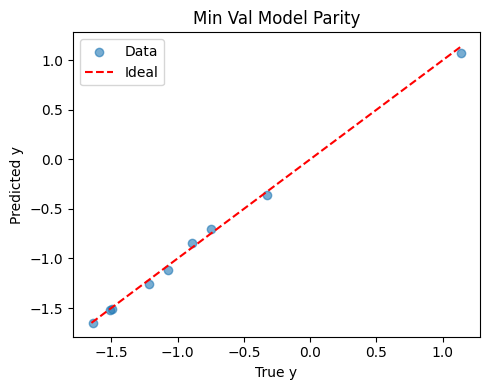

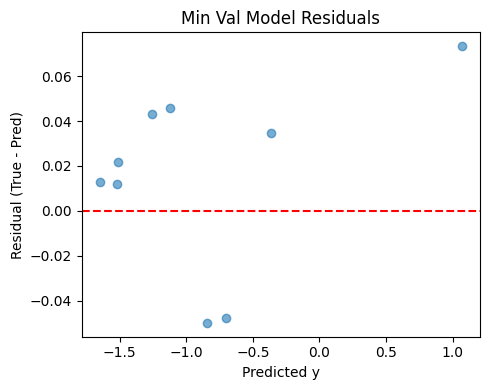

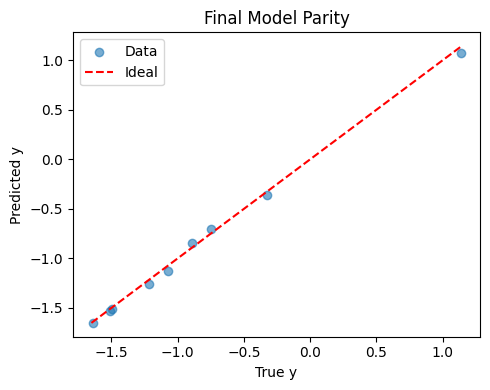

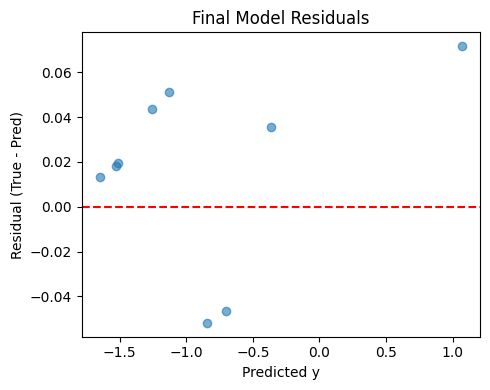

In [ ]:
_ = evaluate_cnn_results(
    density_train_cnn,
    CNN1D,
    X_test_scaled_density_tsr,
    y_test_scaled_density_tsr,
    additional_input_dim=(0, ),
    scaler_y=None
)


In [ ]:
_

{'train_loss_final': 0.001601336756721139,
 'val_loss_final': 0.004632220137864351,
 'min_val_loss': 0.004522380884736776,
 'MSE_min_val_model': 0.0017905845306813717,
 'RMSE_min_val_model': 0.042315299014438874,
 'MAE_min_val_model': 0.03793425112962723,
 'R2_min_val_model': 0.9972700476646423,
 'MAPE_min_val_model': 4.435398057103157,
 'MSE_final_model': 0.0018466520123183727,
 'RMSE_final_model': 0.04297268914459942,
 'MAE_final_model': 0.03896060585975647,
 'R2_final_model': 0.9971845746040344,
 'MAPE_final_model': 4.529251158237457}

# apply catboost

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.3 MB/s eta 0:00:00


<ipython-input-44-1f9148c92a94>:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vapor_pressure = vapor_pressure.ffill()
<ipython-input-44-1f9148c92a94>:82: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]


====== Test Metrics (Density) ======
MSE  : 0.0000
RMSE : 0.0042
MAE  : 0.0026
R^2  : 0.9936
MAPE : 0.30%


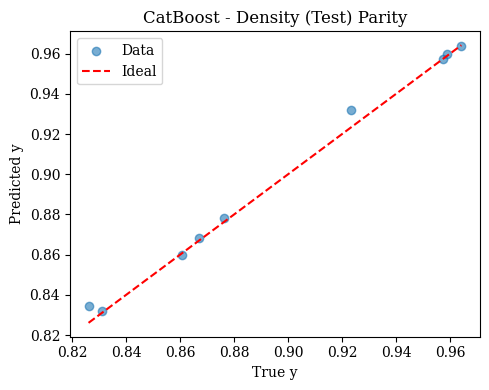

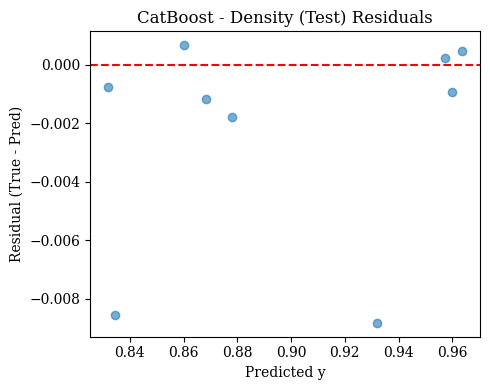

In [44]:
##############################################################################
# 1) Imports and Basic Setup
##############################################################################
from google.colab import drive
drive.mount('/content/drive')

import os
!pip install pymoo
!pip install catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import itertools
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

##############################################################################
# 2) Utility Functions for Data Handling
##############################################################################
def mix_sigma(series_list, weights):
    final_sigma = pd.Series(np.zeros(len(series_list[0])), index=series_list[0].index)
    for i in range(len(series_list)):
        final_sigma += series_list[i] * weights[i]
    return final_sigma

def make_df_from_series(series_list):
    df = pd.DataFrame()
    for i in range(len(series_list)):
        df[series_list[i].name] = series_list[i]
    return df

def df_to_np(df):
    return df.to_numpy()

def trapezoidal_area(arr, x_gap=0.001):
    area = np.zeros((arr.shape[0], 1))
    for i in range(arr.shape[1] - 1):
        area += (arr[:,(i,)] + arr[:,(i + 1,)]) / 2 * x_gap
    return area

def process_property_data(data, cleaned_pure_sigma_df):
    # Initialize variables
    components = []
    composition = []
    mole_fractions = []

    pure_components = ["DBU", "BuOH", "hol", 'mol', 'eol']
    _ = data['CO2BOL']
    for i in _:
        composition.append([i[-4], i[-2]])
        components.append([i[:3], i[4:-6]])
        mole_fractions.append([float(i[-4])/(float(i[-4])+float(i[-2])),
                               float(i[-2])/(float(i[-4])+float(i[-2]))])

    # Collect property data
    property_all_data = []
    for i in data['CO2BOL'].values:
        for j in list(data.columns)[1:]:
            property_all_data.append([])
            property_all_data[-1] += [float(j[:-2]), ]
            components = [i[:3], i[4:-6]]
            mole_fractions = [float(i[-4])/(float(i[-4])+float(i[-2])),
                              float(i[-2])/(float(i[-4])+float(i[-2]))]
            c1 = cleaned_pure_sigma_df[components[0]]
            c2 = cleaned_pure_sigma_df[components[1]]
            property_all_data[-1] += list(mix_sigma([c1, c2], mole_fractions))
            property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]
    property_all_data_np = np.array(property_all_data)
    property_all_data_np = property_all_data_np[~np.isnan(property_all_data_np).any(axis=1)]
    return property_all_data_np

def get_cut_areas(property_p_data, sigma_values, sigma_cuts):
    """
    sigma_cuts is a list with elements as [low, high] for each cut
    """
    areas = []
    for low, high in sigma_cuts:
        valid_cols = (sigma_values>=low) & (sigma_values<high)
        valid_p_data = property_p_data[:,valid_cols]
        areas.append(trapezoidal_area(valid_p_data, x_gap = 0.001))
    return np.concatenate(areas, axis = 1)

def get_uniform_cuts(gap, _start = -0.019, _end = 0.027):
    cuts = []
    while _start < _end:
        cuts.append([_start, _start + gap])
        _start += gap
    return cuts

def merge_cuts_and_other_feats(cut_areas, other_feats):
    # both must be 2D array
    return np.hstack((cut_areas, other_feats))

def get_train_val_test(X_data, y_data, test_size = 0.15, val_size = 0.15, random_split = True):
    rand_ind = np.random.permutation(len(X_data))
    X_data = X_data[rand_ind]
    y_data = y_data[rand_ind]
    X_test = X_data[int(len(X_data)*(1-test_size)):]
    y_test = y_data[int(len(X_data)*(1-test_size)):]
    X_val = X_data[int(len(X_data)*(1-test_size-val_size)):int(len(X_data)*(1-test_size))]
    y_val = y_data[int(len(X_data)*(1-test_size-val_size)):int(len(X_data)*(1-test_size))]
    X_train = X_data[:int(len(X_data)*(1-test_size-val_size))]
    y_train = y_data[:int(len(X_data)*(1-test_size-val_size))]
    return X_train, X_val, X_test, y_train, y_val, y_test, rand_ind

def scale_data(X_train, X_val, X_test, y_train, y_val, y_test, method = 'standard'):
    if method == 'standard':
        x_scaler = StandardScaler()
        X_train = x_scaler.fit_transform(X_train)
        X_val = x_scaler.transform(X_val)
        X_test = x_scaler.transform(X_test)
        y_scaler = StandardScaler()
        y_train = y_scaler.fit_transform(y_train)
        y_val = y_scaler.transform(y_val)
        y_test = y_scaler.transform(y_test)

    elif method == 'min_max':
        x_scaler = MinMaxScaler()
        X_train = x_scaler.fit_transform(X_train)
        X_val = x_scaler.transform(X_val)
        X_test = x_scaler.transform(X_test)
        y_scaler = MinMaxScaler()
        y_train = y_scaler.fit_transform(y_train)
        y_val = y_scaler.transform(y_val)
        y_test = y_scaler.transform(y_test)
    else:
        raise ValueError("Invalid scaling method. Choose 'standard' or 'min_max'.")
    return X_train, X_val, X_test, y_train, y_val, y_test, x_scaler, y_scaler

def descale_data(X_data = None, y_data = None, x_scaler = None, y_scaler = None):
    if X_data is not None:
        X_data = x_scaler.inverse_transform(X_data)
    if y_data is not None:
        y_data = y_scaler.inverse_transform(y_data)
    return X_data, y_data


##############################################################################
# 3) Load Data
##############################################################################
folder_path = r"/content/drive/MyDrive/Colab Notebooks/D PhD/All codes/Objective 4/Safique_solvents"
file_path = r"/content/drive/MyDrive/Colab Notebooks/D PhD/All codes/Objective 4/Safique_solvents/sigma profile_BOLs.xls"

# Load all sheets into a dictionary
data_sheets = pd.read_excel(file_path, sheet_name=None)
experimental_data_file_path =r"/content/drive/MyDrive/Colab Notebooks/D PhD/All codes/Objective 4/Safique_solvents/Experimental data...BOLS.xlsx"
experimental_data = pd.read_excel(experimental_data_file_path, sheet_name=None)

density_data = experimental_data['density']
viscosity_data = experimental_data['viscosity']
vapor_pressure = experimental_data['vapor pressure']

# --- Clean/format density_data ---
density_data.columns = density_data.iloc[3]
density_data = density_data.iloc[4:]
density_data = density_data.drop(density_data.columns[0], axis=1)
density_data = density_data.drop(density_data.columns[0], axis=1)

# --- Clean/format viscosity_data ---
viscosity_data.columns = viscosity_data.iloc[2]
viscosity_data = viscosity_data.iloc[3:]
viscosity_data = viscosity_data.drop(viscosity_data.columns[0], axis=1)

# --- Clean/format vapor_pressure ---
vapor_pressure = vapor_pressure.iloc[2:,2:]
vapor_pressure = vapor_pressure.ffill()
vapor_pressure_copy = {}
vapor_pressure_copy_keys = ["CO2BOL",]+[str(i) + " K"  for i in vapor_pressure["Unnamed: 3"].unique()]
for i in vapor_pressure_copy_keys:
    vapor_pressure_copy[i] = []
vapor_pressure_copy[vapor_pressure_copy_keys[0]] = [i for i in vapor_pressure["Unnamed: 2"].unique()]
for i in vapor_pressure_copy[vapor_pressure_copy_keys[0]]:
    _ = vapor_pressure[vapor_pressure["Unnamed: 2"] == i]
    for t in [i  for i in vapor_pressure["Unnamed: 3"].unique()]:
        vapor_pressure_copy[str(t)+" K"].append(np.nan)
        try:
            vapor_pressure_copy[str(t)+" K"][-1] = _[_["Unnamed: 3"] == t]["Unnamed: 4"].item()
        except:
            None
vapor_pressure_data = pd.DataFrame(vapor_pressure_copy)

# --- Clean/format sigma data ---
pure_sigmas_df = data_sheets['SIGMA PROFILES\n No.2 298.15 K']
pure_sigmas_df.columns = pure_sigmas_df.iloc[0]
pure_sigmas_df = pure_sigmas_df.iloc[1:]
pure_sigmas_df = pure_sigmas_df.iloc[:61]
pure_sigmas_df_column_names = ["sigma", "DBU", "BuOH", "HexOH", 'EGME', 'EGEE']
pure_sigmas_df.columns = pure_sigmas_df_column_names

cleaned_pure_sigma_df = pure_sigmas_df.copy()
cleaned_pure_sigma_df['all'] = mix_sigma([cleaned_pure_sigma_df[i] for i in pure_sigmas_df_column_names[1:]],
                                         [1, 1, 1, 1, 1])
cleaned_pure_sigma_df = pure_sigmas_df[cleaned_pure_sigma_df['all'] != 0]
sigma_values = np.array(cleaned_pure_sigma_df['sigma'])


##############################################################################
# 4) Prepare Single-Property Data (Example: Density)
##############################################################################
processed_density_data = process_property_data(density_data, cleaned_pure_sigma_df)

# X: all columns except last
X_density_data = processed_density_data[:,:-1]
# y: only the last column
y_density_data = processed_density_data[:,(-1,)]

# Split into train, val, test
X_train_density, X_val_density, X_test_density, \
y_train_density, y_val_density, y_test_density, rand_ind_density = get_train_val_test(
    X_density_data, y_density_data,
    test_size = 0.15,
    val_size = 0.15,
    random_split = True
)

# Scale
(X_train_scaled_density,
 X_val_scaled_density,
 X_test_scaled_density,
 y_train_scaled_density,
 y_val_scaled_density,
 y_test_scaled_density,
 x_scaler_density,
 y_scaler_density) = scale_data(
    X_train_density, X_val_density, X_test_density,
    y_train_density, y_val_density, y_test_density,
    method='standard'
)


##############################################################################
# 5) Train & Evaluate with CatBoost
##############################################################################
from catboost import CatBoostRegressor

# -------------------------------
# 5a) Initialize a CatBoost model
# -------------------------------
# You can tune iterations, depth, learning_rate, etc.
cat_model = CatBoostRegressor(
    iterations=5000,    # Increase for more thorough training (watch for overfitting)
    learning_rate=0.01, # Tweak as needed
    depth=6,            # Tweak as needed
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=seed,
    verbose=False       # Set to True for more logs
)

# ----------------------------------
# 5b) Fit the model on TRAIN + VAL
# ----------------------------------
# Often, you can do:
#   cat_model.fit(X_train_scaled_density, y_train_scaled_density,
#                 eval_set=(X_val_scaled_density, y_val_scaled_density),
#                 use_best_model=True)
#
# But if you prefer not to do "use_best_model", just do:
cat_model.fit(X_train_scaled_density, y_train_scaled_density,
              eval_set=(X_val_scaled_density, y_val_scaled_density))

# -----------------------------------
# 5c) Evaluate on TEST
# -----------------------------------
y_pred_test = cat_model.predict(X_test_scaled_density)
y_test_unscaled = y_scaler_density.inverse_transform(y_test_scaled_density.reshape(-1,1)).flatten()
y_pred_test_unscaled = y_scaler_density.inverse_transform(y_pred_test.reshape(-1,1)).flatten()

mse_val = mean_squared_error(y_test_unscaled, y_pred_test_unscaled)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_test_unscaled, y_pred_test_unscaled)
r2_val = r2_score(y_test_unscaled, y_pred_test_unscaled)
mape_val = np.mean(
    np.abs((y_test_unscaled - y_pred_test_unscaled) / y_test_unscaled)
)*100 if np.any(y_test_unscaled != 0) else np.nan

print("====== Test Metrics (Density) ======")
print(f"MSE  : {mse_val:.4f}")
print(f"RMSE : {rmse_val:.4f}")
print(f"MAE  : {mae_val:.4f}")
print(f"R^2  : {r2_val:.4f}")
print(f"MAPE : {mape_val:.2f}%")

# Optional: Parity plot
plt.figure(figsize=(5, 4))
plt.scatter(y_test_unscaled, y_pred_test_unscaled, alpha=0.6, label='Data')
diag_min = min(y_test_unscaled.min(), y_pred_test_unscaled.min())
diag_max = max(y_test_unscaled.max(), y_pred_test_unscaled.max())
plt.plot([diag_min, diag_max], [diag_min, diag_max], 'r--', label='Ideal')
plt.title("CatBoost - Density (Test) Parity")
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Residuals plot
residuals = y_test_unscaled - y_pred_test_unscaled
plt.figure(figsize=(5, 4))
plt.scatter(y_pred_test_unscaled, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title("CatBoost - Density (Test) Residuals")
plt.xlabel("Predicted y")
plt.ylabel("Residual (True - Pred)")
plt.tight_layout()
plt.show()


<ipython-input-45-122040e39f43>:222: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vapor_pressure_data_raw = vapor_pressure_data_raw.ffill()
<ipython-input-45-122040e39f43>:122: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]


====== CatBoost on Density (Cut=0.008) - Test Metrics ======
MSE  : 0.0000
RMSE : 0.0037
MAE  : 0.0025
R^2  : 0.9950
MAPE : 0.28%


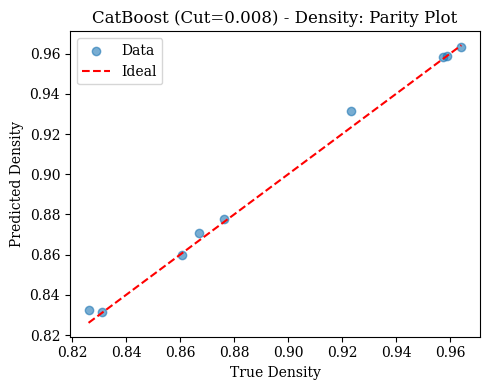

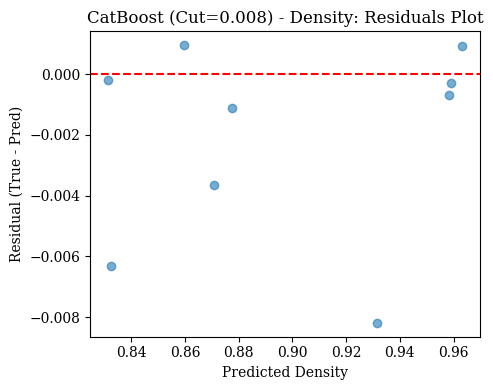

In [45]:
##############################################################################
# 1) Mount Drive and Install Dependencies (if in Google Colab)
##############################################################################
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install pymoo
# !pip install catboost

##############################################################################
# 2) Import Modules
##############################################################################
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import itertools
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Multi-objective library (if needed):
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

##############################################################################
# 3) Utility Functions for Data Handling
##############################################################################
def mix_sigma(series_list, weights):
    final_sigma = pd.Series(np.zeros(len(series_list[0])), index=series_list[0].index)
    for i in range(len(series_list)):
        final_sigma += series_list[i] * weights[i]
    return final_sigma

def make_df_from_series(series_list):
    df = pd.DataFrame()
    for i in range(len(series_list)):
        df[series_list[i].name] = series_list[i]
    return df

def df_to_np(df):
    return df.to_numpy()

def trapezoidal_area(arr, x_gap=0.001):
    area = np.zeros((arr.shape[0], 1))
    for i in range(arr.shape[1] - 1):
        area += (arr[:,(i,)] + arr[:,(i + 1,)]) / 2 * x_gap
    return area

def get_uniform_cuts(gap, _start=-0.019, _end=0.027):
    """
    Generate consecutive [low, high] intervals of size 'gap' between _start and _end.
    """
    cuts = []
    while _start < _end:
        cuts.append([_start, _start + gap])
        _start += gap
    return cuts

def get_cut_areas(property_p_data, sigma_values, sigma_cuts):
    """
    For each interval in sigma_cuts (e.g. [-0.019, -0.011], [-0.011, -0.003], ...),
    compute the trapezoidal area for that sub-range of columns in property_p_data.
    """
    areas = []
    for low, high in sigma_cuts:
        valid_cols = (sigma_values>=low) & (sigma_values<high)
        valid_p_data = property_p_data[:,valid_cols]
        areas.append(trapezoidal_area(valid_p_data, x_gap=0.001))
    return np.concatenate(areas, axis=1)

def merge_cuts_and_other_feats(cut_areas, other_feats):
    # Combine the trapezoidal area features with whatever "other" features we have
    return np.hstack((cut_areas, other_feats))

def process_property_data(data, cleaned_pure_sigma_df):
    """
    Transforms raw property DataFrame into a NumPy array of shape (num_samples, some_features+1).
    The last column is the target property.
    """
    # Initialize variables
    components = []
    composition = []
    mole_fractions = []

    pure_components = ["DBU", "BuOH", "hol", 'mol', 'eol']
    _ = data['CO2BOL']
    for i in _:
        composition.append([i[-4], i[-2]])
        components.append([i[:3], i[4:-6]])
        mole_fractions.append([
            float(i[-4])/(float(i[-4])+float(i[-2])),
            float(i[-2])/(float(i[-4])+float(i[-2]))
        ])

    # Collect property data
    property_all_data = []
    for i in data['CO2BOL'].values:
        for j in list(data.columns)[1:]:
            property_all_data.append([])
            property_all_data[-1] += [float(j[:-2]), ]  # temperature?
            components = [i[:3], i[4:-6]]
            mole_fractions = [
                float(i[-4])/(float(i[-4])+float(i[-2])),
                float(i[-2])/(float(i[-4])+float(i[-2]))
            ]
            c1 = cleaned_pure_sigma_df[components[0]]
            c2 = cleaned_pure_sigma_df[components[1]]
            # Mix the relevant columns with the mole fractions
            property_all_data[-1] += list(mix_sigma([c1, c2], mole_fractions))
            property_all_data[-1] += [float(data[data['CO2BOL'] == i][j]), ]

    property_all_data_np = np.array(property_all_data)
    # Remove any rows with NaN
    property_all_data_np = property_all_data_np[~np.isnan(property_all_data_np).any(axis=1)]
    return property_all_data_np

def get_train_val_test(X_data, y_data, test_size=0.15, val_size=0.15, random_split=True):
    """
    Shuffle data and split into train, val, test sets.
    """
    rand_ind = np.random.permutation(len(X_data))
    X_data = X_data[rand_ind]
    y_data = y_data[rand_ind]

    X_test = X_data[int(len(X_data)*(1 - test_size)):]
    y_test = y_data[int(len(X_data)*(1 - test_size)):]

    X_val = X_data[int(len(X_data)*(1 - test_size - val_size)):int(len(X_data)*(1 - test_size))]
    y_val = y_data[int(len(X_data)*(1 - test_size - val_size)):int(len(X_data)*(1 - test_size))]

    X_train = X_data[:int(len(X_data)*(1 - test_size - val_size))]
    y_train = y_data[:int(len(X_data)*(1 - test_size - val_size))]

    return X_train, X_val, X_test, y_train, y_val, y_test, rand_ind

def scale_data(X_train, X_val, X_test, y_train, y_val, y_test, method='standard'):
    """
    Scale features and targets. Returns scaled splits + the scalers.
    """
    if method == 'standard':
        x_scaler = StandardScaler()
        X_train = x_scaler.fit_transform(X_train)
        X_val = x_scaler.transform(X_val)
        X_test = x_scaler.transform(X_test)

        y_scaler = StandardScaler()
        y_train = y_scaler.fit_transform(y_train)
        y_val = y_scaler.transform(y_val)
        y_test = y_scaler.transform(y_test)

    elif method == 'min_max':
        x_scaler = MinMaxScaler()
        X_train = x_scaler.fit_transform(X_train)
        X_val = x_scaler.transform(X_val)
        X_test = x_scaler.transform(X_test)

        y_scaler = MinMaxScaler()
        y_train = y_scaler.fit_transform(y_train)
        y_val = y_scaler.transform(y_val)
        y_test = y_scaler.transform(y_test)

    else:
        raise ValueError("Invalid scaling method. Choose 'standard' or 'min_max'.")

    return (X_train, X_val, X_test,
            y_train, y_val, y_test,
            x_scaler, y_scaler)

def descale_data(X_data=None, y_data=None, x_scaler=None, y_scaler=None):
    """
    Inverse transform scaled data if desired.
    """
    if X_data is not None:
        X_data = x_scaler.inverse_transform(X_data)
    if y_data is not None:
        y_data = y_scaler.inverse_transform(y_data)
    return X_data, y_data


##############################################################################
# 4) Load Excel Data (You Provided This in Earlier Messages)
##############################################################################
folder_path = r"/content/drive/MyDrive/Colab Notebooks/D PhD/All codes/Objective 4/Safique_solvents"
file_path = r"/content/drive/MyDrive/Colab Notebooks/D PhD/All codes/Objective 4/Safique_solvents/sigma profile_BOLs.xls"

# Load all sheets into a dictionary
data_sheets = pd.read_excel(file_path, sheet_name=None)
experimental_data_file_path = (
    r"/content/drive/MyDrive/Colab Notebooks/D PhD/All codes/Objective 4/Safique_solvents/Experimental data...BOLS.xlsx"
)
experimental_data = pd.read_excel(experimental_data_file_path, sheet_name=None)

density_data = experimental_data['density']
viscosity_data = experimental_data['viscosity']
vapor_pressure_data_raw = experimental_data['vapor pressure']

# Cleanup for density_data
density_data.columns = density_data.iloc[3]
density_data = density_data.iloc[4:]
density_data = density_data.drop(density_data.columns[0], axis=1)
density_data = density_data.drop(density_data.columns[0], axis=1)

# Cleanup for viscosity_data
viscosity_data.columns = viscosity_data.iloc[2]
viscosity_data = viscosity_data.iloc[3:]
viscosity_data = viscosity_data.drop(viscosity_data.columns[0], axis=1)

# Cleanup for vapor_pressure_data
vapor_pressure_data_raw = vapor_pressure_data_raw.iloc[2:, 2:]
vapor_pressure_data_raw = vapor_pressure_data_raw.ffill()

vapor_pressure_copy = {}
vapor_pressure_copy_keys = ["CO2BOL",] + [
    str(i) + " K" for i in vapor_pressure_data_raw["Unnamed: 3"].unique()
]
for i in vapor_pressure_copy_keys:
    vapor_pressure_copy[i] = []
vapor_pressure_copy[vapor_pressure_copy_keys[0]] = [
    i for i in vapor_pressure_data_raw["Unnamed: 2"].unique()
]
for i in vapor_pressure_copy[vapor_pressure_copy_keys[0]]:
    _ = vapor_pressure_data_raw[vapor_pressure_data_raw["Unnamed: 2"] == i]
    for t in [i for i in vapor_pressure_data_raw["Unnamed: 3"].unique()]:
        vapor_pressure_copy[str(t) + " K"].append(np.nan)
        try:
            vapor_pressure_copy[str(t) + " K"][-1] = _[_["Unnamed: 3"] == t]["Unnamed: 4"].item()
        except:
            pass
vapor_pressure_data = pd.DataFrame(vapor_pressure_copy)

# Sigma profiles
pure_sigmas_df = data_sheets['SIGMA PROFILES\n No.2 298.15 K']
pure_sigmas_df.columns = pure_sigmas_df.iloc[0]
pure_sigmas_df = pure_sigmas_df.iloc[1:]
pure_sigmas_df = pure_sigmas_df.iloc[:61]
pure_sigmas_df_column_names = ["sigma", "DBU", "BuOH", "HexOH", 'EGME', 'EGEE']
pure_sigmas_df.columns = pure_sigmas_df_column_names

# Remove zero rows
cleaned_pure_sigma_df = pure_sigmas_df.copy()
cleaned_pure_sigma_df["all"] = mix_sigma(
    [cleaned_pure_sigma_df[i] for i in pure_sigmas_df_column_names[1:]],
    [1,1,1,1,1]
)
cleaned_pure_sigma_df = pure_sigmas_df[cleaned_pure_sigma_df["all"] != 0]
sigma_values = np.array(cleaned_pure_sigma_df["sigma"])


##############################################################################
# 5) Define get_final_cut_data(...) for “Cut Data”
##############################################################################
def get_final_cut_data(property_data, sigma_values, sigma_cuts=None,
                       uniform_gap=0.008, other_feats_inds=(0,)):
    """
    1) property_data: 2D array with columns: [some features..., sigma-based columns..., property?].
    2) sigma_values: the array of sigma indices to slice the property_data's sigma columns.
    3) sigma_cuts: if None, we create uniform cuts (size=uniform_gap).
    4) other_feats_inds: which columns in 'property_data' are "non-sigma" features to keep directly.

    Returns: A new 2D array with:
       - Columns of trapezoidal "cut" areas for each sigma interval
       - Then appended the 'other_feats_inds' columns
    """
    property_other_feat_data = property_data[:, other_feats_inds]
    # Delete those 'other_feats_inds' columns from 'property_p_data' so we only have the sigma-based columns.
    property_p_data = np.delete(property_data, other_feats_inds, axis=1)

    if sigma_cuts is None:
        sigma_cuts = get_uniform_cuts(uniform_gap)

    # For each sigma interval, compute trapezoidal area on relevant columns
    cut_areas = get_cut_areas(property_p_data, sigma_values, sigma_cuts)

    # Merge the cut areas with the other features
    return merge_cuts_and_other_feats(cut_areas, property_other_feat_data)


##############################################################################
# 6) Example: Prepare Density Data with 0.008 Cut
##############################################################################
processed_density_data = process_property_data(density_data, cleaned_pure_sigma_df)

# X: everything except the last column (which is the property)
X_processed_density_data = processed_density_data[:,:-1]
# y: the last column
y_density_data = processed_density_data[:,(-1, )]

# Use get_final_cut_data to create new features
X_density_008cut_data = get_final_cut_data(
    X_processed_density_data,
    sigma_values,
    sigma_cuts=None,      # so it auto uses uniform_gap=0.008
    uniform_gap=0.008,
    other_feats_inds=(0,) # i.e. keep the first column (temp) as a direct feature,
                          # then "cut" the remaining sigma-based columns
)

# Train/Val/Test split
(
    X_train_density_008cut,
    X_val_density_008cut,
    X_test_density_008cut,
    y_train_density_008cut,
    y_val_density_008cut,
    y_test_density_008cut,
    rand_ind_density_008cut
) = get_train_val_test(
    X_density_008cut_data,
    y_density_data,
    test_size=0.15,
    val_size=0.15,
    random_split=True
)

# Scale
(
    X_train_scaled_density_008cut,
    X_val_scaled_density_008cut,
    X_test_scaled_density_008cut,
    y_train_scaled_density_008cut,
    y_val_scaled_density_008cut,
    y_test_scaled_density_008cut,
    x_scaler_density_008cut,
    y_scaler_density_008cut
) = scale_data(
    X_train_density_008cut,
    X_val_density_008cut,
    X_test_density_008cut,
    y_train_density_008cut,
    y_val_density_008cut,
    y_test_density_008cut,
    method='standard'
)


##############################################################################
# 7) Train & Evaluate CatBoost on 0.008 Cut Data
##############################################################################
from catboost import CatBoostRegressor

# Initialize the model (tweak hyperparameters as needed)
cat_model_density_008cut = CatBoostRegressor(
    iterations=3000,    # Increase if needed
    learning_rate=0.01, # Adjust as needed
    depth=6,            # Adjust as needed
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=seed,
    verbose=False       # Set True for more logs
)

# Train on TRAIN set, provide VAL set for monitoring
cat_model_density_008cut.fit(
    X_train_scaled_density_008cut,
    y_train_scaled_density_008cut,
    eval_set=(X_val_scaled_density_008cut, y_val_scaled_density_008cut)
)

# Predict on TEST
y_pred_test_cat_008cut = cat_model_density_008cut.predict(X_test_scaled_density_008cut)

# Inverse-transform the predictions and the test targets
y_test_unscaled_008cut = y_scaler_density_008cut.inverse_transform(
    y_test_scaled_density_008cut.reshape(-1,1)
).flatten()

y_pred_unscaled_008cut = y_scaler_density_008cut.inverse_transform(
    y_pred_test_cat_008cut.reshape(-1,1)
).flatten()

# Evaluate
mse_val_008cut = mean_squared_error(y_test_unscaled_008cut, y_pred_unscaled_008cut)
rmse_val_008cut = np.sqrt(mse_val_008cut)
mae_val_008cut = mean_absolute_error(y_test_unscaled_008cut, y_pred_unscaled_008cut)
r2_val_008cut = r2_score(y_test_unscaled_008cut, y_pred_unscaled_008cut)

if np.any(y_test_unscaled_008cut != 0):
    mape_val_008cut = (
        np.mean(np.abs((y_test_unscaled_008cut - y_pred_unscaled_008cut) / y_test_unscaled_008cut)) * 100
    )
else:
    mape_val_008cut = np.nan

print("====== CatBoost on Density (Cut=0.008) - Test Metrics ======")
print(f"MSE  : {mse_val_008cut:.4f}")
print(f"RMSE : {rmse_val_008cut:.4f}")
print(f"MAE  : {mae_val_008cut:.4f}")
print(f"R^2  : {r2_val_008cut:.4f}")
print(f"MAPE : {mape_val_008cut:.2f}%")

# Parity Plot
plt.figure(figsize=(5,4))
plt.scatter(y_test_unscaled_008cut, y_pred_unscaled_008cut, alpha=0.6, label='Data')
_diag_min = min(y_test_unscaled_008cut.min(), y_pred_unscaled_008cut.min())
_diag_max = max(y_test_unscaled_008cut.max(), y_pred_unscaled_008cut.max())
plt.plot([_diag_min, _diag_max], [_diag_min, _diag_max], 'r--', label='Ideal')
plt.title("CatBoost (Cut=0.008) - Density: Parity Plot")
plt.xlabel("True Density")
plt.ylabel("Predicted Density")
plt.legend()
plt.tight_layout()
plt.show()

# Residuals Plot
residuals_008cut = y_test_unscaled_008cut - y_pred_unscaled_008cut
plt.figure(figsize=(5,4))
plt.scatter(y_pred_unscaled_008cut, residuals_008cut, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title("CatBoost (Cut=0.008) - Density: Residuals Plot")
plt.xlabel("Predicted Density")
plt.ylabel("Residual (True - Pred)")
plt.tight_layout()
plt.show()


In [47]:
##############################################################################
# 1) Imports & Basic Setup
##############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Pymoo (for multi-objective / constrained optimization)
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# PyTorch (if needed for converting data to tensors)
import torch
import torch.nn as nn
from torch import optim

# CatBoost
!pip install catboost
from catboost import CatBoostRegressor

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

##############################################################################
# 2) Utility Functions for Data Loading & Processing
##############################################################################
def mix_sigma(series_list, weights):
    final_sigma = pd.Series(np.zeros(len(series_list[0])), index=series_list[0].index)
    for i in range(len(series_list)):
        final_sigma += series_list[i] * weights[i]
    return final_sigma

def trapezoidal_area(arr, x_gap=0.001):
    area = np.zeros((arr.shape[0], 1))
    for i in range(arr.shape[1] - 1):
        area += (arr[:, (i,)] + arr[:, (i + 1,)]) / 2 * x_gap
    return area

def get_uniform_cuts(gap, _start=-0.019, _end=0.027):
    cuts = []
    while _start < _end:
        cuts.append([_start, _start + gap])
        _start += gap
    return cuts

def get_cut_areas(property_p_data, sigma_values, sigma_cuts):
    areas = []
    for low, high in sigma_cuts:
        valid_cols = (sigma_values >= low) & (sigma_values < high)
        valid_p_data = property_p_data[:, valid_cols]
        areas.append(trapezoidal_area(valid_p_data, x_gap=0.001))
    return np.concatenate(areas, axis=1)

def merge_cuts_and_other_feats(cut_areas, other_feats):
    return np.hstack((cut_areas, other_feats))

def process_property_data(data, cleaned_pure_sigma_df):
    """
    Transforms raw property DataFrame into numeric arrays.
    Last column is the target property.
    """
    property_all_data = []
    for i in data['CO2BOL'].values:
        for j in list(data.columns)[1:]:
            row = []
            row.append(float(j[:-2]))  # e.g. temperature
            # parse compositions
            comps = [i[:3], i[4:-6]]
            x1 = float(i[-4]) / (float(i[-4]) + float(i[-2]))
            x2 = float(i[-2]) / (float(i[-4]) + float(i[-2]))
            c1 = cleaned_pure_sigma_df[comps[0]]
            c2 = cleaned_pure_sigma_df[comps[1]]
            row += list(mix_sigma([c1, c2], [x1, x2]))
            row.append(float(data[data['CO2BOL'] == i][j]))
            property_all_data.append(row)

    property_all_data_np = np.array(property_all_data)
    property_all_data_np = property_all_data_np[~np.isnan(property_all_data_np).any(axis=1)]
    return property_all_data_np

def get_train_val_test(X_data, y_data, test_size=0.15, val_size=0.15, random_split=True):
    rand_ind = np.random.permutation(len(X_data)) if random_split else np.arange(len(X_data))
    X_data = X_data[rand_ind]
    y_data = y_data[rand_ind]

    # index boundaries
    test_start = int(len(X_data) * (1 - test_size))
    val_start  = int(len(X_data) * (1 - test_size - val_size))

    X_train = X_data[:val_start]
    y_train = y_data[:val_start]

    X_val = X_data[val_start:test_start]
    y_val = y_data[val_start:test_start]

    X_test = X_data[test_start:]
    y_test = y_data[test_start:]

    return X_train, X_val, X_test, y_train, y_val, y_test, rand_ind

def scale_data(X_train, X_val, X_test, y_train, y_val, y_test, method='standard'):
    if method == 'standard':
        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
    elif method == 'min_max':
        x_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling method. Choose 'standard' or 'min_max'.")

    X_train = x_scaler.fit_transform(X_train)
    X_val   = x_scaler.transform(X_val)
    X_test  = x_scaler.transform(X_test)

    y_train = y_scaler.fit_transform(y_train)
    y_val   = y_scaler.transform(y_val)
    y_test  = y_scaler.transform(y_test)

    return (X_train, X_val, X_test,
            y_train, y_val, y_test,
            x_scaler, y_scaler)

##############################################################################
# 3) The get_final_cut_data(...) & cut_process_and_scale_data(...)
##############################################################################
def get_final_cut_data(property_data, sigma_values, sigma_cuts=None,
                       uniform_gap=None, other_feats_inds=(0,)):
    property_other_feat_data = property_data[:, other_feats_inds]
    property_p_data = np.delete(property_data, other_feats_inds, axis=1)

    if sigma_cuts is None and uniform_gap is not None:
        sigma_cuts = get_uniform_cuts(uniform_gap)

    cut_areas = get_cut_areas(property_p_data, sigma_values, sigma_cuts)
    return merge_cuts_and_other_feats(cut_areas, property_other_feat_data)

def cut_process_and_scale_data(
    property_data,
    cleaned_sigma_df,
    sigma_values,
    sigma_cuts=None,
    uniform_gap=None,
    other_feats_inds=(0, ),
    test_size=0.15,
    val_size=0.15,
    random_split=True,
    scaling_method='standard'
):
    """
    Process, cut, split, and scale property data (example: density).
    Returns a dict with scaled Tensors + scalers.
    """
    # 1) Process the property data
    processed_property_data = process_property_data(property_data, cleaned_sigma_df)
    X_processed_property_data = processed_property_data[:, :-1]
    y_property_data = processed_property_data[:, (-1, )]

    # 2) Apply cut-based transformation
    X_property_cut_data = get_final_cut_data(
        X_processed_property_data,
        sigma_values,
        sigma_cuts=sigma_cuts,
        uniform_gap=uniform_gap,
        other_feats_inds=other_feats_inds
    )

    # 3) Train/Val/Test split
    (X_train, X_val, X_test,
     y_train, y_val, y_test,
     rand_ind) = get_train_val_test(
        X_property_cut_data,
        y_property_data,
        test_size=test_size,
        val_size=val_size,
        random_split=random_split
    )

    # 4) Scale
    (X_train_scaled, X_val_scaled, X_test_scaled,
     y_train_scaled, y_val_scaled, y_test_scaled,
     x_scaler, y_scaler) = scale_data(
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        method=scaling_method
    )

    # 5) Convert to Torch tensors (if you still need them)
    X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_val_tsr   = torch.tensor(X_val_scaled,   dtype=torch.float32)
    X_test_tsr  = torch.tensor(X_test_scaled,  dtype=torch.float32)

    y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_val_tsr   = torch.tensor(y_val_scaled,   dtype=torch.float32)
    y_test_tsr  = torch.tensor(y_test_scaled,  dtype=torch.float32)

    return {
        "X_train": X_train_tsr,
        "X_val":   X_val_tsr,
        "X_test":  X_test_tsr,
        "y_train": y_train_tsr,
        "y_val":   y_val_tsr,
        "y_test":  y_test_tsr,
        "x_scaler": x_scaler,
        "y_scaler": y_scaler,
        "random_indices": rand_ind
    }

##############################################################################
# 4) CatBoost Training + Validation MSE
##############################################################################
def train_catboost_and_get_val_loss(
    X_train, y_train,
    X_val,   y_val,
    iterations=3000,
    learning_rate=0.01,
    depth=6,
    seed=42
):
    """
    Trains a CatBoostRegressor on (X_train, y_train) and returns Val MSE.
    """
    # Convert Torch tensors -> NumPy
    if isinstance(X_train, torch.Tensor):
        X_train = X_train.detach().cpu().numpy()
    if isinstance(X_val, torch.Tensor):
        X_val = X_val.detach().cpu().numpy()
    if isinstance(y_train, torch.Tensor):
        y_train = y_train.detach().cpu().numpy().ravel()
    if isinstance(y_val, torch.Tensor):
        y_val = y_val.detach().cpu().numpy().ravel()

    cat_model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=seed,
        verbose=False
    )
    cat_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val)
    )

    # Evaluate on val set
    y_val_pred = cat_model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)

    # Return the MSE
    return val_mse

##############################################################################
# 5) The Objective Function for the Cuts (Single-Objective)
##############################################################################
def cuts_objective(
    cuts,
    property_data=None,
    cleaned_sigma_df=None,
    sigma_values=None,
    uniform_gap=None,
    other_feats_inds=(0,),
    test_size=0.15,
    val_size=0.15,
    random_split=True,
    scaling_method='standard',
    cat_iterations=3000,
    cat_learning_rate=0.01,
    cat_depth=6,
    max_epochs=15000
):
    """
    Applies 'cuts' to the data, trains CatBoost, returns val MSE.
    """
    cut_data = cut_process_and_scale_data(
        property_data,
        cleaned_sigma_df,
        sigma_values,
        sigma_cuts=cuts,
        uniform_gap=uniform_gap,
        other_feats_inds=other_feats_inds,
        test_size=test_size,
        val_size=val_size,
        random_split=random_split,
        scaling_method=scaling_method
    )

    val_mse = train_catboost_and_get_val_loss(
        X_train=cut_data["X_train"],
        y_train=cut_data["y_train"],
        X_val=cut_data["X_val"],
        y_val=cut_data["y_val"],
        iterations=cat_iterations,
        learning_rate=cat_learning_rate,
        depth=cat_depth,
        seed=seed
    )
    return val_mse

##############################################################################
# 6) The CustomProblem Class (Constraints + Single-Objective)
##############################################################################
class CustomProblem(Problem):
    def __init__(
        self,
        cut_obj_fn,
        property_data=None,
        cleaned_sigma_df=None,
        sigma_values=None,
        uniform_gap=None,
        other_feats_inds=(0,),
        test_size=0.15,
        val_size=0.15,
        random_split=True,
        scaling_method='standard',
        cat_iterations=3000,
        cat_learning_rate=0.01,
        cat_depth=6,
        max_epochs=15000
    ):
        super().__init__(
            n_var=10,   # 5 intervals => [low, high]*5
            n_obj=1,    # single objective
            n_constr=5, # 5 constraints
            xl=np.array([-0.020]*10),
            xu=np.array([ 0.028]*10)
        )
        self.obj_func = cut_obj_fn
        self.property_data = property_data
        self.cleaned_sigma_df = cleaned_sigma_df
        self.sigma_values = sigma_values
        self.uniform_gap = uniform_gap
        self.other_feats_inds = other_feats_inds
        self.test_size = test_size
        self.val_size = val_size
        self.random_split = random_split
        self.scaling_method = scaling_method

        self.cat_iterations = cat_iterations
        self.cat_learning_rate = cat_learning_rate
        self.cat_depth = cat_depth
        self.max_epochs = max_epochs

    def _evaluate(self, X, out):
        # X shape => (pop_size, 10)
        X_reshaped = X.reshape(-1, 5, 2)

        # Constraints: each interval's width >= 0.002
        # => g = 0.002 - (x[1] - x[0]) <= 0
        # we'll store 5 such constraints
        g_list = []
        for i_intvl in range(5):
            g_list.append(0.002 - (X_reshaped[:, i_intvl, 1] - X_reshaped[:, i_intvl, 0]))
        G = np.column_stack(g_list)

        # Single-objective => val MSE
        f1 = []
        for xi in X_reshaped:
            val_mse = self.obj_func(
                cuts=xi,
                property_data=self.property_data,
                cleaned_sigma_df=self.cleaned_sigma_df,
                sigma_values=self.sigma_values,
                uniform_gap=self.uniform_gap,
                other_feats_inds=self.other_feats_inds,
                test_size=self.test_size,
                val_size=self.val_size,
                random_split=self.random_split,
                scaling_method=self.scaling_method,
                cat_iterations=self.cat_iterations,
                cat_learning_rate=self.cat_learning_rate,
                cat_depth=self.cat_depth,
                max_epochs=self.max_epochs
            )
            f1.append([val_mse])

        out["F"] = np.array(f1)
        out["G"] = G

##############################################################################
# 7) Run the Optimization to Find Optimum Cuts
##############################################################################

# Suppose we want to optimize "density_data"
# We assume "cleaned_pure_sigma_df" and "sigma_values" are already loaded
problem = CustomProblem(
    cut_obj_fn=cuts_objective,
    property_data=density_data,
    cleaned_sigma_df=cleaned_pure_sigma_df,
    sigma_values=sigma_values,
    uniform_gap=None,
    cat_iterations=1000,       # keep smaller for demonstration
    cat_learning_rate=0.01,
    cat_depth=6,
    max_epochs=15000
)

algorithm = NSGA2(pop_size=50)
res = minimize(
    problem,
    algorithm,
    ('n_gen', 50),  # Number of generations
    seed=1,
    verbose=True
)

##############################################################################
# 8) Extract the Best Solution & Re-Train CatBoost on Train+Val, Evaluate on Test
##############################################################################

# Because it's single objective, "Pareto front" is basically a single best solution
# (or multiple if they have the same objective). We'll choose the best.
best_f = np.min(res.F)             # best (lowest) MSE found
best_idx = np.argmin(res.F)        # index of best solution
best_cuts = res.X.reshape(5,2)

print("\n========== Best Cuts Found by NSGA2 ==========")
print(best_cuts)
print(f"Best val MSE found: {best_f:.6f}")

# ----- Now we apply these cuts and do final training + test evaluation -----

# Step A: Prepare data with best cuts
final_data = cut_process_and_scale_data(
    property_data=density_data,
    cleaned_sigma_df=cleaned_pure_sigma_df,
    sigma_values=sigma_values,
    sigma_cuts=best_cuts,    # use the best intervals
    uniform_gap=None,
    other_feats_inds=(0,),   # or your choice
    test_size=0.15,
    val_size=0.15,
    random_split=True,
    scaling_method='standard'
)

# Step B: If you want to combine train+val for final training, you can:
X_train_plus_val = torch.cat([final_data["X_train"], final_data["X_val"]], dim=0)
y_train_plus_val = torch.cat([final_data["y_train"], final_data["y_val"]], dim=0)

X_test_final = final_data["X_test"]
y_test_final = final_data["y_test"]

# Convert Tensors -> NumPy
X_train_plus_val_np = X_train_plus_val.detach().cpu().numpy()
y_train_plus_val_np = y_train_plus_val.detach().cpu().numpy().ravel()

X_test_final_np = X_test_final.detach().cpu().numpy()
y_test_final_np = y_test_final.detach().cpu().numpy().ravel()

# Step C: Train final CatBoost on train+val
cat_model_final = CatBoostRegressor(
    iterations=3000,    # or more, to finalize
    learning_rate=0.01,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=seed,
    verbose=False
)
cat_model_final.fit(
    X_train_plus_val_np,
    y_train_plus_val_np
    # we don't necessarily need an eval_set here, since we're doing final training
)

# Step D: Evaluate on Test
y_test_pred = cat_model_final.predict(X_test_final_np)

# Inverse-transform test data for metrics
y_scaler = final_data["y_scaler"]
y_test_final_unscaled = y_scaler.inverse_transform(y_test_final_np.reshape(-1,1)).flatten()
y_test_pred_unscaled = y_scaler.inverse_transform(y_test_pred.reshape(-1,1)).flatten()

mse_final  = mean_squared_error(y_test_final_unscaled, y_test_pred_unscaled)
rmse_final = np.sqrt(mse_final)
mae_final  = mean_absolute_error(y_test_final_unscaled, y_test_pred_unscaled)
r2_final   = r2_score(y_test_final_unscaled, y_test_pred_unscaled)

if np.any(y_test_final_unscaled != 0):
    mape_final = (
        np.mean(np.abs((y_test_final_unscaled - y_test_pred_unscaled) / y_test_final_unscaled)) * 100
    )
else:
    mape_final = np.nan

print("\n========== Final Test Metrics Using Best Cuts & CatBoost ==========")
print(f"MSE  : {mse_final:.4f}")
print(f"RMSE : {rmse_final:.4f}")
print(f"MAE  : {mae_final:.4f}")
print(f"R^2  : {r2_final:.4f}")
print(f"MAPE : {mape_final:.2f}%")

# Optional: Parity & Residual Plots
plt.figure(figsize=(5,4))
plt.scatter(y_test_final_unscaled, y_test_pred_unscaled, alpha=0.6, label='Data')
_diag_min = min(y_test_final_unscaled.min(), y_test_pred_unscaled.min())
_diag_max = max(y_test_final_unscaled.max(), y_test_pred_unscaled.max())
plt.plot([_diag_min, _diag_max], [_diag_min, _diag_max], 'r--', label='Ideal')
plt.title("Final CatBoost - Parity Plot (Using Best Cuts)")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.tight_layout()
plt.show()
residuals = y_test_final_unscaled - y_test_pred_unscaled
plt.figure(figsize=(5,4))
plt.scatter(y_test_pred_unscaled, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title("Final CatBoost - Residuals Plot (Using Best Cuts)")
plt.xlabel("Predicted")
plt.ylabel("Residual (True - Pred)")
plt.tight_layout()
plt.show()


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      1 |  0.000000E+00 |  0.0406643884 |             - |             -


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

     2 |      100 |      1 |  0.000000E+00 |  0.0145882763 |  0.0019033418 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

     3 |      150 |      1 |  0.000000E+00 |  0.0047559518 |  0.0243773973 |         ideal


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

     4 |      200 |      1 |  0.000000E+00 |  0.0011837597 |  0.0027715078 |         ideal


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

     5 |      250 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

     6 |      300 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0005228779 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

     7 |      350 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0017321698 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

     8 |      400 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0017321698 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

     9 |      450 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0017321698 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    10 |      500 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0017321698 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    11 |      550 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0017321698 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    12 |      600 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0017321698 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    13 |      650 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0017321698 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    14 |      700 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0017321698 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    15 |      750 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0017321698 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    16 |      800 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    17 |      850 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    18 |      900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    19 |      950 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    20 |     1000 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    21 |     1050 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    22 |     1100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    23 |     1150 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    24 |     1200 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    25 |     1250 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    26 |     1300 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    27 |     1350 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    28 |     1400 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    29 |     1450 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    30 |     1500 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    31 |     1550 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    32 |     1600 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    33 |     1650 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    34 |     1700 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    35 |     1750 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    36 |     1800 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    37 |     1850 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    38 |     1900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    39 |     1950 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    40 |     2000 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    41 |     2050 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    42 |     2100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    43 |     2150 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    44 |     2200 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    45 |     2250 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0018374542 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    46 |     2300 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0020165426 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    47 |     2350 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0020165426 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    48 |     2400 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0020165426 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    49 |     2450 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0020165426 |             f


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element

    50 |     2500 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0020165426 |             f


ValueError: cannot reshape array of size 1 into shape (5,2)


========== Best Cuts Found by NSGA2 ==========
[[-0.01728193  0.02599402]
 [-0.01084692  0.02727245]
 [ 0.00750612  0.02028672]
 [ 0.00184687  0.0242713 ]
 [-0.00020266  0.00782971]]
Best val MSE found: 0.000861


<ipython-input-47-dfe447a1cd79>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))



========== Final Test Metrics Using Best Cuts & CatBoost ==========
MSE  : 0.0000
RMSE : 0.0027
MAE  : 0.0022
R^2  : 0.9975
MAPE : 0.24%


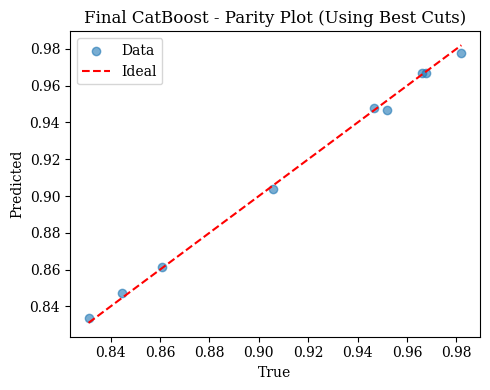

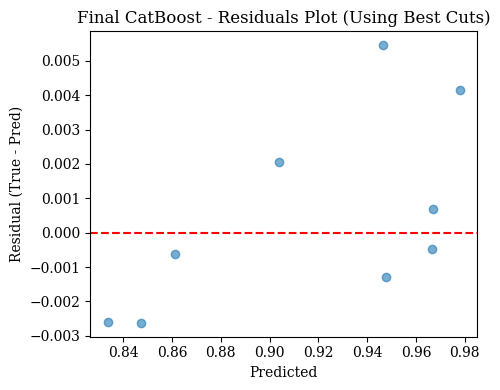

<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       20 |      1 |  0.000000E+00 |  0.0369173078 |             - |             -


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

     2 |       40 |      1 |  0.000000E+00 |  0.0118777164 |  0.000000E+00 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

     3 |       60 |      1 |  0.000000E+00 |  0.0026310551 |  0.0000983497 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

     4 |       80 |      1 |  0.000000E+00 |  0.0000935422 |  0.0001715280 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

     5 |      100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0001774829 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

     6 |      120 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002349258 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

     7 |      140 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002349258 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

     8 |      160 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002483139 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

     9 |      180 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002654553 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

    10 |      200 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002654553 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

    11 |      220 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002905443 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

    12 |      240 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002905443 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

    13 |      260 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002905443 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

    14 |      280 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002905443 |             f


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))
<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single el

    15 |      300 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002905443 |             f

========== Best Cuts Found by NSGA2 (Max Train R²) ==========
[[ 0.00024658  0.01204141]
 [-0.01587189 -0.00946649]
 [-0.01856825 -0.00173186]
 [-0.0013699   0.00737336]
 [-0.01545786 -0.01051921]]
Max training R² found: 0.9998


<ipython-input-56-db5f5bd14d0f>:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  row.append(float(data[data['CO2BOL'] == i][j]))



========== Final Test Metrics ===========
MSE  : 0.0000
RMSE : 0.0021
MAE  : 0.0018
R²   : 0.9986
MAPE : 0.19%


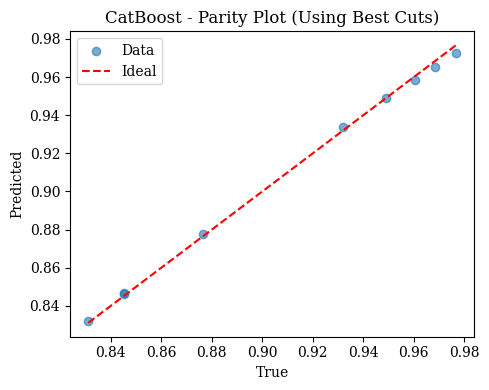

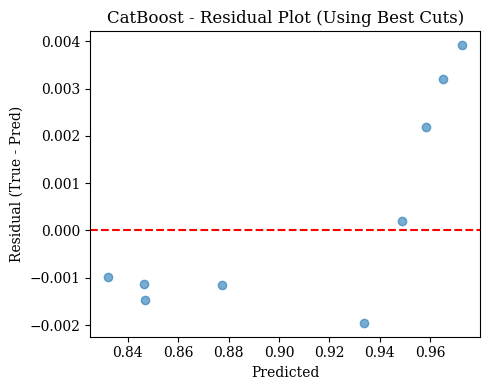

In [56]:
##############################################################################
# 1) Imports & Basic Setup
##############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Pymoo (for multi-objective / constrained optimization)
!pip install catboost
!pip install pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

import torch
import torch.nn as nn
from torch import optim

# CatBoost
from catboost import CatBoostRegressor

# Set random seed
seed = 40
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

##############################################################################
# 2) Utility Functions
##############################################################################
def mix_sigma(series_list, weights):
    """
    Weighted sum of sigma profiles.
    """
    final_sigma = pd.Series(np.zeros(len(series_list[0])), index=series_list[0].index)
    for i in range(len(series_list)):
        final_sigma += series_list[i] * weights[i]
    return final_sigma

def trapezoidal_area(arr, x_gap=0.001):
    """
    Numerical integration to compute area for sigma cuts.
    """
    area = np.zeros((arr.shape[0], 1))
    for i in range(arr.shape[1] - 1):
        area += (arr[:, (i,)] + arr[:, (i + 1,)]) / 2 * x_gap
    return area

def get_uniform_cuts(gap, _start=-0.019, _end=0.027):
    """
    Generate uniform intervals in [start, end] of size 'gap'.
    """
    cuts = []
    while _start < _end:
        cuts.append([_start, _start + gap])
        _start += gap
    return cuts

def get_cut_areas(property_p_data, sigma_values, sigma_cuts):
    """
    For each interval [low, high], pick columns in 'property_p_data' whose
    sigma_values fall in [low, high], then compute area by trapezoidal integration.
    """
    areas = []
    for low, high in sigma_cuts:
        valid_cols = (sigma_values >= low) & (sigma_values < high)
        valid_p_data = property_p_data[:, valid_cols]
        areas.append(trapezoidal_area(valid_p_data, x_gap=0.001))
    return np.concatenate(areas, axis=1)

def merge_cuts_and_other_feats(cut_areas, other_feats):
    """
    Merge the newly computed cut-area features with any other features (e.g. temperature).
    """
    return np.hstack((cut_areas, other_feats))

def process_property_data(data, cleaned_pure_sigma_df):
    """
    From your property DataFrame, create a numeric array of shape:
      [ [temp, integrated sigmas..., property_value], ... ]
    Last column is the target property.
    """
    property_all_data = []
    for i in data['CO2BOL'].values:
        for j in list(data.columns)[1:]:
            row = []
            row.append(float(j[:-2]))  # e.g. temperature
            # Parse compositions
            comps = [i[:3], i[4:-6]]
            x1 = float(i[-4]) / (float(i[-4]) + float(i[-2]))
            x2 = float(i[-2]) / (float(i[-4]) + float(i[-2]))
            c1 = cleaned_pure_sigma_df[comps[0]]
            c2 = cleaned_pure_sigma_df[comps[1]]
            row += list(mix_sigma([c1, c2], [x1, x2]))
            # property value
            row.append(float(data[data['CO2BOL'] == i][j]))
            property_all_data.append(row)

    property_all_data_np = np.array(property_all_data)
    # remove any row with NaN
    property_all_data_np = property_all_data_np[~np.isnan(property_all_data_np).any(axis=1)]
    return property_all_data_np

def get_train_test(X_data, y_data, test_size=0.15, random_split=True):
    """
    We only want Train + Test now (no validation).
    """
    if random_split:
        rand_ind = np.random.permutation(len(X_data))
    else:
        rand_ind = np.arange(len(X_data))
    X_data = X_data[rand_ind]
    y_data = y_data[rand_ind]

    test_start = int(len(X_data) * (1 - test_size))

    X_train = X_data[:test_start]
    y_train = y_data[:test_start]

    X_test  = X_data[test_start:]
    y_test  = y_data[test_start:]

    return X_train, X_test, y_train, y_test

def scale_data(X_train, X_test, y_train, y_test, method='standard'):
    """
    Scale for train and test only.
    """
    if method == 'standard':
        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
    elif method == 'min_max':
        x_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling method. Choose 'standard' or 'min_max'.")

    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled  = x_scaler.transform(X_test)

    y_train_scaled = y_scaler.fit_transform(y_train)
    y_test_scaled  = y_scaler.transform(y_test)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, x_scaler, y_scaler

##############################################################################
# 3) Functions to apply sigma cuts and scale data (Train+Test only)
##############################################################################
def get_final_cut_data(property_data, sigma_values,
                       sigma_cuts=None, uniform_gap=None,
                       other_feats_inds=(0,)):
    """
    Convert property_data columns to cut-based trapezoidal areas, optionally keep
    columns in other_feats_inds (like temperature).
    """
    property_other_feat_data = property_data[:, other_feats_inds]
    property_p_data = np.delete(property_data, other_feats_inds, axis=1)

    if sigma_cuts is None and uniform_gap is not None:
        sigma_cuts = get_uniform_cuts(uniform_gap)

    cut_areas = get_cut_areas(property_p_data, sigma_values, sigma_cuts)
    return merge_cuts_and_other_feats(cut_areas, property_other_feat_data)

def cut_process_and_scale_data(
    property_data,
    cleaned_sigma_df,
    sigma_values,
    sigma_cuts=None,
    uniform_gap=None,
    other_feats_inds=(0, ),
    test_size=0.15,
    random_split=True,
    scaling_method='standard'
):
    """
    1) Process property data => numeric array
    2) Apply final cut => new features
    3) Split into train/test (no val)
    4) Scale
    """
    # 1) process
    processed_property_data = process_property_data(property_data, cleaned_sigma_df)
    X_processed = processed_property_data[:, :-1]
    y_processed = processed_property_data[:, -1].reshape(-1,1)

    # 2) get final cut data
    X_cut = get_final_cut_data(
        X_processed,
        sigma_values,
        sigma_cuts=sigma_cuts,
        uniform_gap=uniform_gap,
        other_feats_inds=other_feats_inds
    )

    # 3) train/test
    X_train, X_test, y_train, y_test = get_train_test(
        X_cut,
        y_processed,
        test_size=test_size,
        random_split=random_split
    )

    # 4) scale
    (X_train_scaled,
     X_test_scaled,
     y_train_scaled,
     y_test_scaled,
     x_scaler,
     y_scaler) = scale_data(X_train, X_test, y_train, y_test, method=scaling_method)

    # convert to torch if you like
    X_train_tsr = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tsr  = torch.tensor(X_test_scaled,  dtype=torch.float32)

    y_train_tsr = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tsr  = torch.tensor(y_test_scaled,  dtype=torch.float32)

    return {
        "X_train": X_train_tsr,
        "X_test":  X_test_tsr,
        "y_train": y_train_tsr,
        "y_test":  y_test_tsr,
        "x_scaler": x_scaler,
        "y_scaler": y_scaler
    }

##############################################################################
# 4) Objective = MAXIMIZE Training R² => MINIMIZE (-R²)
##############################################################################
def train_catboost_and_get_neg_r2(
    X_train,
    y_train,
    iterations=2000,
    learning_rate=0.01,
    depth=6,
    seed=42
):
    """
    Train on (X_train, y_train).
    Return negative R² on the same training set (no separate test).
    """
    # convert to numpy
    if isinstance(X_train, torch.Tensor):
        X_train = X_train.detach().cpu().numpy()
    if isinstance(y_train, torch.Tensor):
        y_train = y_train.detach().cpu().numpy().ravel()

    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=seed,
        verbose=False
    )
    model.fit(X_train, y_train)

    # predictions on training set
    y_pred_train = model.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)

    # we want to maximize r2 => minimize -r2
    return -r2_train

##############################################################################
# 5) The objective function for the cuts: negative training R²
##############################################################################
def cuts_objective(
    cuts,
    property_data=None,
    cleaned_sigma_df=None,
    sigma_values=None,
    uniform_gap=None,
    other_feats_inds=(0,),
    test_size=0.15,
    random_split=True,
    scaling_method='standard',
    cat_iterations=2000,
    cat_learning_rate=0.01,
    cat_depth=6
):
    # 1) get data with given cuts
    data_dict = cut_process_and_scale_data(
        property_data=property_data,
        cleaned_sigma_df=cleaned_sigma_df,
        sigma_values=sigma_values,
        sigma_cuts=cuts,
        uniform_gap=uniform_gap,
        other_feats_inds=other_feats_inds,
        test_size=test_size,
        random_split=random_split,
        scaling_method=scaling_method
    )
    # 2) train catboost on train => measure train R² => return negative
    neg_r2 = train_catboost_and_get_neg_r2(
        data_dict["X_train"],
        data_dict["y_train"],
        iterations=cat_iterations,
        learning_rate=cat_learning_rate,
        depth=cat_depth,
        seed=seed
    )
    return neg_r2  # Minimizing negative R² => Maximizing R²

##############################################################################
# 6) CustomProblem: 5 intervals => 10 decision variables => constraints
##############################################################################
class CustomProblem(Problem):
    def __init__(
        self,
        cut_obj_fn,
        property_data=None,
        cleaned_sigma_df=None,
        sigma_values=None,
        uniform_gap=None,
        other_feats_inds=(0,),
        test_size=0.15,
        random_split=True,
        scaling_method='standard',
        cat_iterations=2000,
        cat_learning_rate=0.01,
        cat_depth=6
    ):
        super().__init__(
            n_var=10,   # (low, high) for 5 intervals => 5x2
            n_obj=1,    # single objective => negative R²
            n_constr=5, # intervals must be >= 0.002 wide
            xl=np.array([-0.020]*10),
            xu=np.array([0.028]*10)
        )
        self.obj_func = cut_obj_fn
        self.property_data = property_data
        self.cleaned_sigma_df = cleaned_sigma_df
        self.sigma_values = sigma_values
        self.uniform_gap = uniform_gap
        self.other_feats_inds = other_feats_inds
        self.test_size = test_size
        self.random_split = random_split
        self.scaling_method = scaling_method

        self.cat_iterations = cat_iterations
        self.cat_learning_rate = cat_learning_rate
        self.cat_depth = cat_depth

    def _evaluate(self, X, out):
        """
        For each row in X, interpret as 5 intervals => compute negative R².
        Also compute constraints => each interval must be at least 0.002 wide.
        """
        X_reshaped = X.reshape(-1, 5, 2)

        # constraints => (x[1] - x[0]) >= 0.002 => 0.002 - (x[1] - x[0]) <= 0
        # do it for each of the 5 intervals
        g_list = []
        for i_intvl in range(5):
            diff = X_reshaped[:, i_intvl, 1] - X_reshaped[:, i_intvl, 0]
            g_list.append(0.002 - diff)
        G = np.column_stack(g_list)

        f1 = []
        for xi in X_reshaped:
            val = self.obj_func(
                cuts=xi,
                property_data=self.property_data,
                cleaned_sigma_df=self.cleaned_sigma_df,
                sigma_values=self.sigma_values,
                uniform_gap=self.uniform_gap,
                other_feats_inds=self.other_feats_inds,
                test_size=self.test_size,
                random_split=self.random_split,
                scaling_method=self.scaling_method,
                cat_iterations=self.cat_iterations,
                cat_learning_rate=self.cat_learning_rate,
                cat_depth=self.cat_depth
            )
            f1.append([val])  # remember it's negative R²

        out["F"] = np.array(f1)
        out["G"] = G

##############################################################################
# 7) Example Usage with density_data
#    (Assume you have loaded "density_data", "cleaned_pure_sigma_df", "sigma_values")
##############################################################################
# Instantiate problem to minimize negative R² => maximize R²
problem = CustomProblem(
    cut_obj_fn=cuts_objective,
    property_data=density_data,        # your DataFrame
    cleaned_sigma_df=cleaned_pure_sigma_df,
    sigma_values=sigma_values,
    uniform_gap=None,
    cat_iterations=1000,               # short runs for example
    cat_learning_rate=0.01,
    cat_depth=6
)

algorithm = NSGA2(pop_size=20)

res = minimize(
    problem,
    algorithm,
    ('n_gen', 15),  # e.g. 10 generations
    seed=1,
    verbose=True
)

##############################################################################
# 8) Extract the Best Solution => Train => Evaluate on Test
##############################################################################
# Because it's single objective, we can pick the solution with min negative R² => max R²
best_neg_r2 = np.min(res.F)
best_idx = np.argmin(res.F)
best_cuts = res.X.reshape(5,2)

max_train_r2 = -best_neg_r2  # we stored negative R²
print("\n========== Best Cuts Found by NSGA2 (Max Train R²) ==========")
print(best_cuts)
print(f"Max training R² found: {max_train_r2:.4f}")

# Now apply these best cuts, do final training on entire train set, evaluate on test
final_data = cut_process_and_scale_data(
    property_data=density_data,
    cleaned_sigma_df=cleaned_pure_sigma_df,
    sigma_values=sigma_values,
    sigma_cuts=best_cuts,
    uniform_gap=None,
    other_feats_inds=(0,),
    test_size=0.15,
    random_split=True,
    scaling_method='standard'
)

X_train_final = final_data["X_train"]
y_train_final = final_data["y_train"]
X_test_final  = final_data["X_test"]
y_test_final  = final_data["y_test"]

# Convert to NumPy
X_train_np = X_train_final.detach().cpu().numpy()
y_train_np = y_train_final.detach().cpu().numpy().ravel()
X_test_np  = X_test_final.detach().cpu().numpy()
y_test_np  = y_test_final.detach().cpu().numpy().ravel()

cat_model_final = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.01,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=seed,
    verbose=False
)
cat_model_final.fit(
    X_train_np, y_train_np
    # no eval_set needed => final training
)

# Evaluate on test
y_test_pred = cat_model_final.predict(X_test_np)

# Inverse transform to real scale
y_scaler = final_data["y_scaler"]
y_test_unscaled  = y_scaler.inverse_transform(y_test_np.reshape(-1,1)).flatten()
y_pred_unscaled  = y_scaler.inverse_transform(y_test_pred.reshape(-1,1)).flatten()

mse_val  = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse_val = np.sqrt(mse_val)
mae_val  = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
r2_val   = r2_score(y_test_unscaled, y_pred_unscaled)
mape_val = (
    np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled))*100
    if np.any(y_test_unscaled != 0) else np.nan
)

print("\n========== Final Test Metrics ===========")
print(f"MSE  : {mse_val:.4f}")
print(f"RMSE : {rmse_val:.4f}")
print(f"MAE  : {mae_val:.4f}")
print(f"R²   : {r2_val:.4f}")
print(f"MAPE : {mape_val:.2f}%")

# Optional: Parity & Residuals Plots
plt.figure(figsize=(5,4))
plt.scatter(y_test_unscaled, y_pred_unscaled, alpha=0.6, label='Data')
_diag_min = min(y_test_unscaled.min(), y_pred_unscaled.min())
_diag_max = max(y_test_unscaled.max(), y_pred_unscaled.max())
plt.plot([_diag_min, _diag_max], [_diag_min, _diag_max], 'r--', label='Ideal')
plt.title("CatBoost - Parity Plot (Using Best Cuts)")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.tight_layout()
plt.show()

residuals = y_test_unscaled - y_pred_unscaled
plt.figure(figsize=(5,4))
plt.scatter(y_pred_unscaled, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title("CatBoost - Residual Plot (Using Best Cuts)")
plt.xlabel("Predicted")
plt.ylabel("Residual (True - Pred)")
plt.tight_layout()
plt.show()
